Please Follow this Docker container installation process in your MacBook/Laptop before running this Python+R Notebook below.

  - Installation setup of environment where this notebook runs can be found i 
  Container with Jupyter+H2o.ai+Python3+R+Spark in this [link_here](https://github.com/jpacerqueira/project_lost_saturn)
  
  Also :
  - You need a Strong bandwith the install the Container environment it takes about 10-11 minutes to finish.
  
  - Good Luck,  stay safe! But investigate Corona virus(covid-19 or SARS-Cov-2) in your area and give the information back to the comunity!
  
  - Folium maps have custom Javascript and won't display in GitHub : https://stackoverflow.com/questions/53240378/folium-map-fail-to-render-in-notebook-on-github


# CoronaVirus Prediction

### Number of Day to Predict 14

In [1]:
num_days_R_prediction=14

In [2]:
#!pip install rpy2
import rpy2
%load_ext rpy2.ipython
%Rpush num_days_R_prediction

In [3]:
%%R
max_days_prediction<-num_days_R_prediction

In [4]:
bypass_weather=0 # =1 bypass weather_pi api calls
#
number_past_days_training=8 # =(8/14) * num_days_R_prediction  # Number of Past days on training # max to be on 6.Feb.2020
#
max_countries_map=51
#
## DROP_N=15 => 06/02
## DROP_N=45 => 08/03
## DROP_N=75 => 07/04
## DROP_N=145 => 15/06
## DROP_N=175 => 15/07
#
drop_n_dataset_days=175
#

### Load Data from Github - John Hopkins Institute 

In [5]:
# Get data from Github
import numpy as np
from math import sqrt
from sklearn.metrics import mean_squared_error
import pandas as pd

#url_1 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv'
url_1 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
confirmed = pd.read_csv(url_1, error_bad_lines=False)

#url_2 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv'
url_2 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
death = pd.read_csv(url_2, error_bad_lines=False)

#url_3 = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv'
url_3 = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
recover = pd.read_csv(url_3, error_bad_lines=False)

# fix region names
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("Mainland China", "China")
confirmed['Country/Region']= confirmed['Country/Region'].str.replace("US", "United States")

death['Country/Region']= death['Country/Region'].str.replace("Mainland China", "China")
death['Country/Region']= death['Country/Region'].str.replace("US", "United States")

recover['Country/Region']= recover['Country/Region'].str.replace("Mainland China", "China")
recover['Country/Region']= recover['Country/Region'].str.replace("US", "United States")

In [6]:
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
238                           NaN                Thailand  15.870032   
239                           NaN             Timor-Leste  -8.874217   
240                           NaN                    Togo   8.619500   
241                           NaN     Trinidad and Tobago  10.691800   
242                           NaN                 Tunisia  33.886917   
243                           NaN                  Turkey  38.963700   
244                           NaN           United States  40.000000   
245                           NaN                  Uganda   1.373333   
246                           NaN                 Ukraine  48.379400   
247                           NaN    United Arab Emirates  23.424076   
248                      Anguilla          United Kingdom  18.220600   
249                       Bermuda          United Kingdom  32.307800   
250        British Virgin Islands          United Kingdom  18.420700   
251                Cayman Islands          United Kingdom  19.313300   
252               Channel Islands          United Kingdom  49.372300   
253   Falkland Islands (Malvinas)          United Kingdom -51.796300   
254                     Gibraltar          United Kingdom  36.140800   
255                   Isle of Man          United Kingdom  54.236100   
256                    Montserrat          United Kingdom  16.742498   
257      Turks and Caicos Islands          United Kingdom  21.694000   
258                           NaN          United Kingdom  55.378100   
259                           NaN                 Uruguay -32.522800   
260                           NaN              Uzbekistan  41.377491   
261                           NaN               Venezuela  

## Get Population

In [7]:
population=pd.read_csv('/home/notebookuser/notebooks/covid19/data/population.csv', sep=',', encoding='latin1') 
confirmed=pd.merge(confirmed, population,how='left' ,on=['Province/State','Country/Region'])
death=pd.merge(death, population,how='left' ,on=['Province/State','Country/Region'])
recover=pd.merge(recover, population,how='left' ,on=['Province/State','Country/Region'])

In [8]:
# merge region confirmed + death + recover
confirmed['region']=confirmed['Country/Region'].map(str)+'_'+confirmed['Province/State'].map(str)
death['region']=death['Country/Region'].map(str)+'_'+death['Province/State'].map(str)
recover['region']=recover['Country/Region'].map(str)+'_'+recover['Province/State'].map(str)
confirmed.iloc[:,:]

Province/State          Country/Region        Lat  \
0                             NaN             Afghanistan  33.939110   
1                             NaN                 Albania  41.153300   
2                             NaN                 Algeria  28.033900   
3                             NaN                 Andorra  42.506300   
4                             NaN                  Angola -11.202700   
5                             NaN     Antigua and Barbuda  17.060800   
6                             NaN               Argentina -38.416100   
7                             NaN                 Armenia  40.069100   
8    Australian Capital Territory               Australia -35.473500   
9                 New South Wales               Australia -33.868800   
10             Northern Territory               Australia -12.463400   
11                     Queensland               Australia -27.469800   
12                South Australia               Australia -34.928500   
13                       Tasmania               Australia -42.882100   
14                       Victoria               Australia -37.813600   
15              Western Australia               Australia -31.950500   
16                            NaN                 Austria  47.516200   
17                            NaN              Azerbaijan  40.143100   
18                            NaN                 Bahamas  25.025885   
19                            NaN                 Bahrain  26.027500   
20                            NaN              Bangladesh  23.685000   
21                            NaN                Barbados  13.193900   
22                            NaN                 Belarus  53.709800   
23                            NaN                 Belgium  50.833300   
24                            NaN                  Belize  17.189900   
25                            NaN                   Benin   9.307700   
26                            NaN                  Bhutan  27.514200   
27                            NaN                 Bolivia -16.290200   
28                            NaN  Bosnia and Herzegovina  43.915900   
29                            NaN                Botswana -22.328500   
..                            ...                     ...        ...   
244                           NaN                Thailand  15.870032   
245                           NaN             Timor-Leste  -8.874217   
246                           NaN                    Togo   8.619500   
247                           NaN     Trinidad and Tobago  10.691800   
248                           NaN                 Tunisia  33.886917   
249                           NaN                  Turkey  38.963700   
250                           NaN           United States  40.000000   
251                           NaN                  Uganda   1.373333   
252                           NaN                 Ukraine  48.379400   
253                           NaN    United Arab Emirates  23.424076   
254                      Anguilla          United Kingdom  18.220600   
255                       Bermuda          United Kingdom  32.307800   
256        British Virgin Islands          United Kingdom  18.420700   
257                Cayman Islands          United Kingdom  19.313300   
258               Channel Islands          United Kingdom  49.372300   
259   Falkland Islands (Malvinas)          United Kingdom -51.796300   
260                     Gibraltar          United Kingdom  36.140800   
261                   Isle of Man          United Kingdom  54.236100   
262                    Montserrat          United Kingdom  16.742498   
263      Turks and Caicos Islands          United Kingdom  21.694000   
264                           NaN          United Kingdom  55.378100   
265                           NaN                 Uruguay -32.522800   
266                           NaN              Uzbekistan  41.377491   
267                           NaN               Venezuela  

In [9]:
# merge region death
death.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/30/20  \
185        0        0        0        0        0        0  ...      1766   
186        0        0        0        0        0        0  ...         2   
187        0        0        0        0        0        0  ...         0   
188        0        0        0        0        0        0  ...       294   
189        0        0        0        0        0        0  ...      3625   
190        0        0        0        0        0        0  ...        91   
191        0        0        0        0        0        0  ...       133   
192        0        0        0        0        0        0  ...       920   
193        0        0        0        0        0        0  ...        37   
194        0        0        0        0        0        0  ...         3   

     10/31/20  11/1/20  11/2/20  11/3/20  11/4/20  11/5/20  11/6/20  \
185      1785     1800     1818     1838     1851     1866     1882   
186         2        2        2        2        2        2        2   
187         0        0        0        0        0        0        0   
188       301      313      320      322      326      328      328   
189      3695     3762     3826     3900     3982     4059     4127   
190        92       93       94       95       95       97       99   
191       133      133      133      133      133      133      133   
192       937      960      984     1004     1034     1052     1070   
193        38       38       38       38       39       39       39   
194         3        3        3        3        3        3        3   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 296 columns]

In [10]:
# merge region recover
recover.iloc[175:185,:]

Province/State Country/Region        Lat        Long  \
175                               NaN     Mozambique -18.665700   35.529600   
176                               NaN        Namibia -22.957600   18.490400   
177                               NaN          Nepal  28.166700   84.250000   
178                             Aruba    Netherlands  12.521100  -69.968300   
179  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   
180                           Curacao    Netherlands  12.169600  -68.990000   
181                      Sint Maarten    Netherlands  18.042500  -63.054800   
182                               NaN    Netherlands  52.132600    5.291300   
183                               NaN    New Zealand -40.900600  174.886000   
184                               NaN      Nicaragua  12.865416  -85.207229   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/30/20  \
175        0        0        0        0        0        0  ...     10437   
176        0        0        0        0        0        0  ...     11000   
177        0        0        0        0        0        0  ...    128958   
178        0        0        0        0        0        0  ...      4286   
179        0        0        0        0        0        0  ...       145   
180        0        0        0        0        0        0  ...       660   
181        0        0        0        0        0        0  ...       753   
182        0        0        0        0        0        0  ...         0   
183        0        0        0        0        0        0  ...      1857   
184        0        0        0        0        0        0  ...      4225   

     10/31/20  11/1/20  11/2/20  11/3/20  11/4/20  11/5/20  11/6/20  \
175     10437    10439    10439    10695    10983    11177    11275   
176     11036    11038    11201    11304    11344    11438    11578   
177    131222   134842   137992   141134   144978   148408   152908   
178      4319     4326     4331     4340     4348     4352     4367   
179       145      145      145      145      145      145      145   
180       665      684      698      722      746      768      783   
181       753      753      760      768      768      780      780   
182         0        0        0        0        0        0        0   
183      1857     1857     1868     1873     1881     1905     1908   
184      4225     4225     4225     4225     4225     4225     4225   

      Population                                         region  
175    31,542,919                                Mozambique_nan  
176           NaN                                   Namibia_nan  
177    29,300,000                                     Nepal_nan  
178           NaN                             Netherlands_Aruba  
179           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  
180           NaN                           Netherlands_Curacao  
181           NaN                      Netherlands_Sint Maarten  
182    17,180,000                               Netherlands_nan  
183     4,813,844                               New Zealand_nan  
184     6,649,701                                 Nicaragua_nan  

[10 rows x 296 columns]

In [11]:
confirmed.iloc[185:195,:]

Province/State Country/Region        Lat        Long  \
185                               NaN        Moldova  47.411600   28.369900   
186                               NaN         Monaco  43.733300    7.416700   
187                               NaN       Mongolia  46.862500  103.846700   
188                               NaN     Montenegro  42.708678   19.374390   
189                               NaN        Morocco  31.791700   -7.092600   
190                               NaN     Mozambique -18.665695   35.529562   
191                               NaN        Namibia -22.957600   18.490400   
192                               NaN          Nepal  28.166700   84.250000   
193                             Aruba    Netherlands  12.521100  -69.968300   
194  Bonaire, Sint Eustatius and Saba    Netherlands  12.178400  -68.238500   

     1/22/20  1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/30/20  \
185        0        0        0        0        0        0  ...     75201   
186        0        0        0        0        0        0  ...       355   
187        0        0        0        0        0        0  ...       346   
188        0        0        0        0        0        0  ...     18066   
189        0        0        0        0        0        0  ...    215294   
190        0        0        0        0        0        0  ...     12777   
191        0        0        0        0        0        0  ...     12907   
192        0        0        0        1        1        1  ...    168235   
193        0        0        0        0        0        0  ...      4494   
194        0        0        0        0        0        0  ...       153   

     10/31/20  11/1/20  11/2/20  11/3/20  11/4/20  11/5/20  11/6/20  \
185     76040    76582    76777    77487    78507    79566    80501   
186       359      366      375      397      412      430      454   
187       346      349      350      352      353      356      357   
188     18341    18714    19210    19977    20851    21533    22079   
189    219084   222544   225070   229565   235310   240951   246349   
190     12869    12988    13130    13202    13283    13391    13485   
191     12935    12988    13012    13030    13046    13090    13143   
192    170743   173567   176500   179614   182923   185974   188883   
193      4513     4519     4524     4538     4553     4564     4578   
194       153      153      153      153      153      153      154   

      Population                                         region  
185     4,035,942                                   Moldova_nan  
186        39,183                                    Monaco_nan  
187           NaN                                  Mongolia_nan  
188       622 500                                Montenegro_nan  
189    36,817,128                                   Morocco_nan  
190    31,542,919                                Mozambique_nan  
191           NaN                                   Namibia_nan  
192    29,300,000                                     Nepal_nan  
193           NaN                             Netherlands_Aruba  
194           NaN  Netherlands_Bonaire, Sint Eustatius and Saba  

[10 rows x 296 columns]

In [12]:
confirmed.iloc[220:230,:]

Province/State         Country/Region        Lat        Long  1/22/20  \
220            NaN             San Marino  43.942400   12.457800        0   
221            NaN  Sao Tome and Principe   0.186400    6.613100        0   
222            NaN           Saudi Arabia  23.885942   45.079162        0   
223            NaN                Senegal  14.497400  -14.452400        0   
224            NaN                 Serbia  44.016500   21.005900        0   
225            NaN             Seychelles  -4.679600   55.492000        0   
226            NaN           Sierra Leone   8.460555  -11.779889        0   
227            NaN              Singapore   1.283300  103.833300        0   
228            NaN               Slovakia  48.669000   19.699000        0   
229            NaN               Slovenia  46.151200   14.995500        0   

     1/23/20  1/24/20  1/25/20  1/26/20  1/27/20  ...  10/30/20  10/31/20  \
220        0        0        0        0        0  ...       928       928   
221        0        0        0        0        0  ...       945       945   
222        0        0        0        0        0  ...    346880    347282   
223        0        0        0        0        0  ...     15605     15616   
224        0        0        0        0        0  ...     45137     46954   
225        0        0        0        0        0  ...       153       153   
226        0        0        0        0        0  ...      2365      2366   
227        1        3        3        4        5  ...     58003     58015   
228        0        0        0        0        0  ...     55091     57664   
229        0        0        0        0        0  ...     32503     34307   

     11/1/20  11/2/20  11/3/20  11/4/20  11/5/20  11/6/20   Population   \
220      928      928      994      994     1043     1043        33,916   
221      949      949      954      958      958      960           NaN   
222   347656   348037   348510   348936   349386   349822    34,695,447   
223    15630    15637    15640    15650    15668    15676           NaN   
224    48403    49205    51083    53495    55676    57958     8,744,671   
225      153      153      157      157      157      158           NaN   
226     2366     2366     2368     2369     2371     2373           NaN   
227    58019    58020    58029    58036    58043    58047     5,612,000   
228    59946    61829    63556    66772    68734    71088     5,459,087   
229    35649    36206    37382    39408    41094    42658     2,078,878   

                        region  
220             San Marino_nan  
221  Sao Tome and Principe_nan  
222           Saudi Arabia_nan  
223                Senegal_nan  
224                 Serbia_nan  
225             Seychelles_nan  
226           Sierra Leone_nan  
227              Singapore_nan  
228               Slovakia_nan  
229               Slovenia_nan  

[10 rows x 296 columns]

## Create Time Series + Plots

In [13]:
def create_ts(df):
  ts=df
  ts=ts.drop(['Province/State', 'Country/Region','Lat', 'Long',' Population '], axis=1)
  ts.set_index('region')
  ts=ts.T
  ts.columns=ts.loc['region']
  ts=ts.drop('region')
  ts=ts.fillna(0)
  ts=ts.reindex(sorted(ts.columns), axis=1)
  return (ts)

In [14]:
## JOAO - Fix - Drop Duplicates # Keep Last # Issue With Data source Change from John Hopkins institute
#
ts=create_ts(confirmed.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_d=create_ts(death.drop_duplicates(subset=['region'], keep='last', inplace=False) )
ts_rec=create_ts(recover.drop_duplicates(subset=['region'], keep='last', inplace=False) )

In [15]:
# JOAO - FIX - Automation WarmUp of Plot Library
import matplotlib.pyplot as plt
import time
plt.legend(loc = 'upper left')
plt.show()

No handles with labels found to put in legend.


<Figure size 640x480 with 1 Axes>

Text(0.5, 1.0, 'Daily Update - Total Recovered - Major_4,25 2nd Areas')

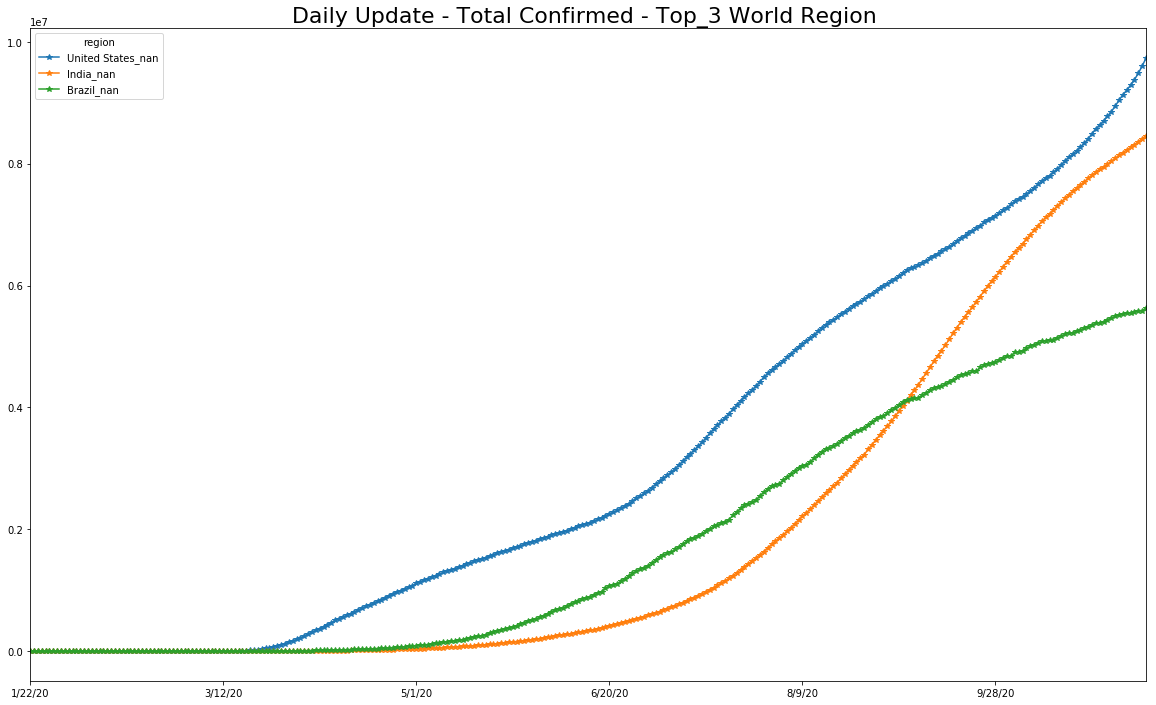

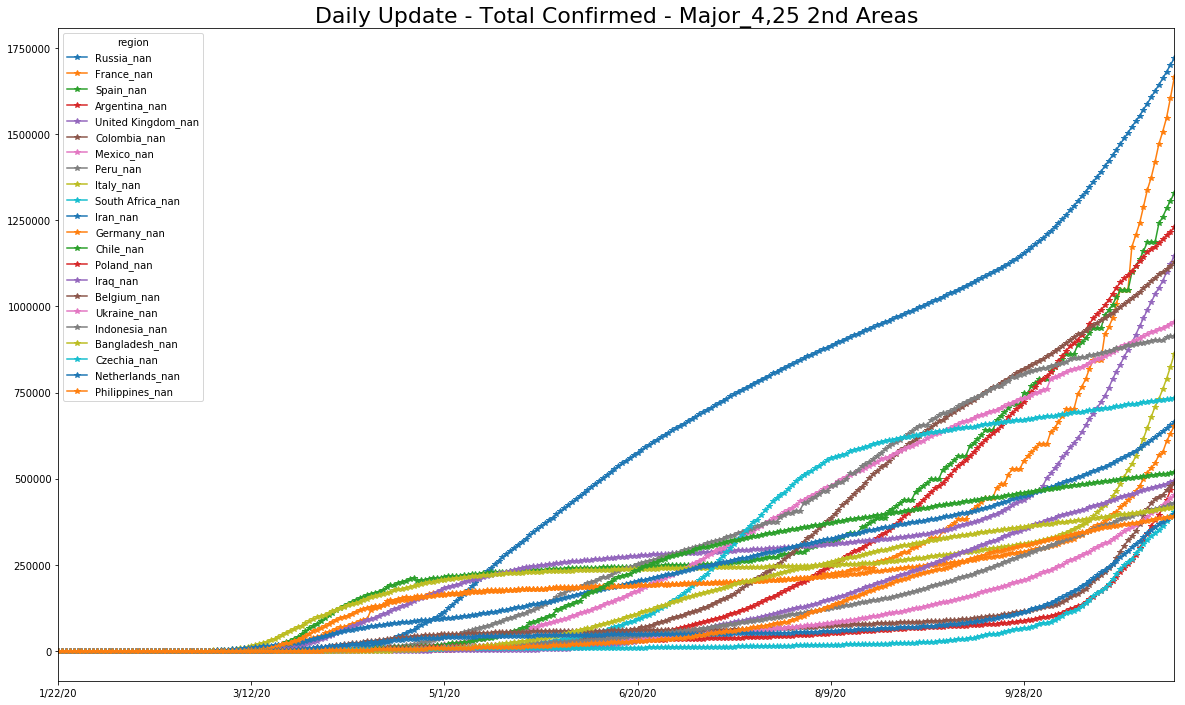

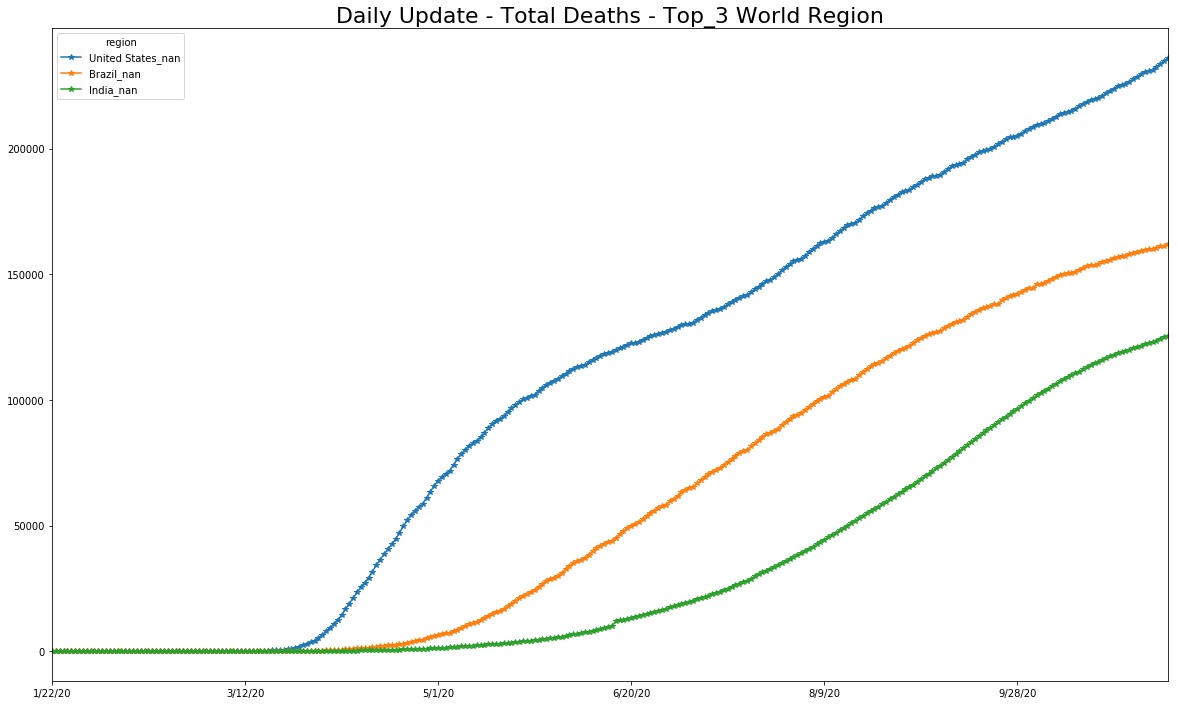

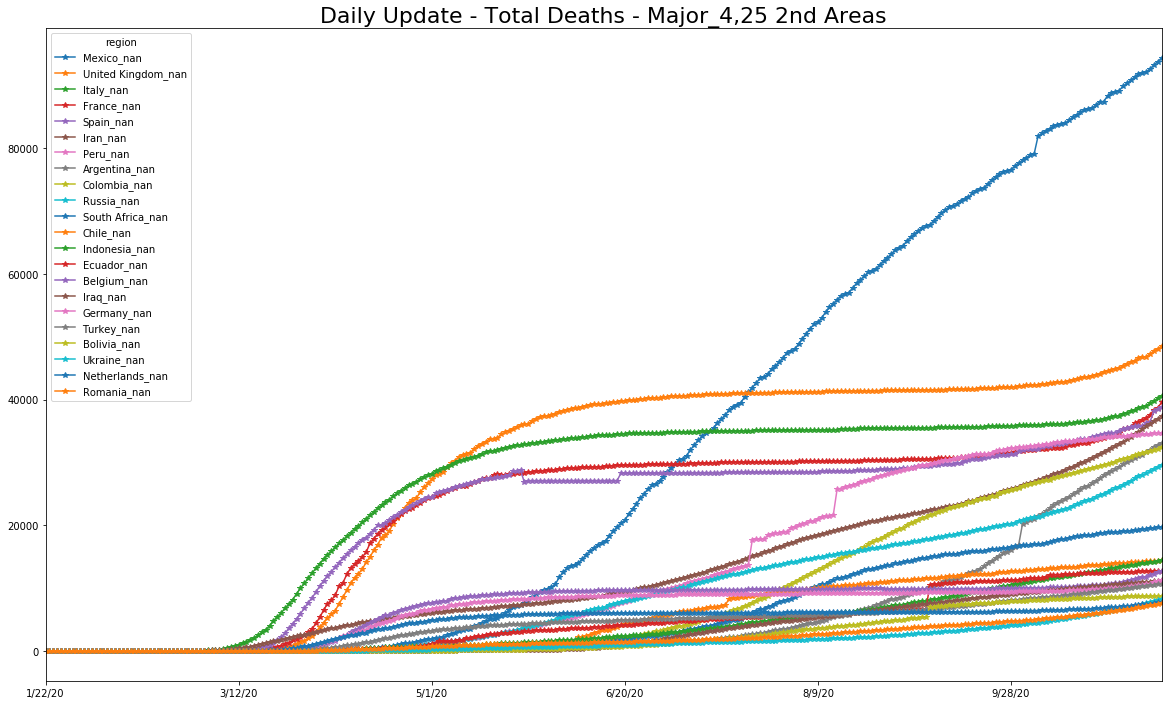

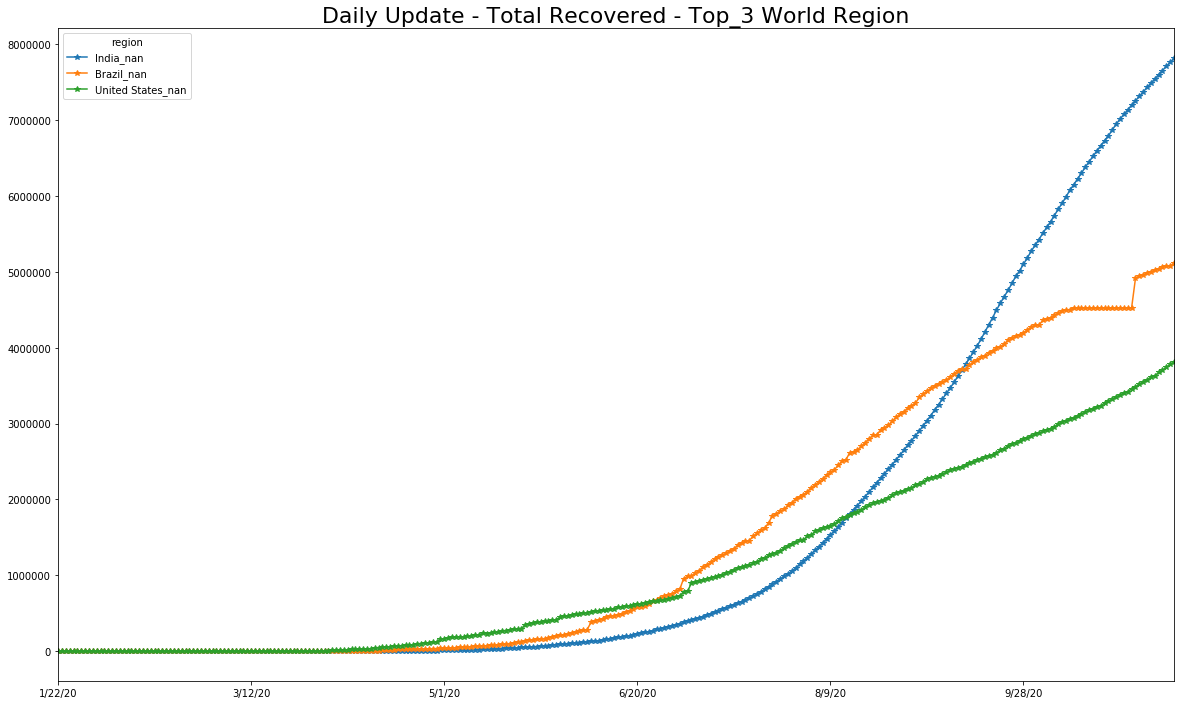

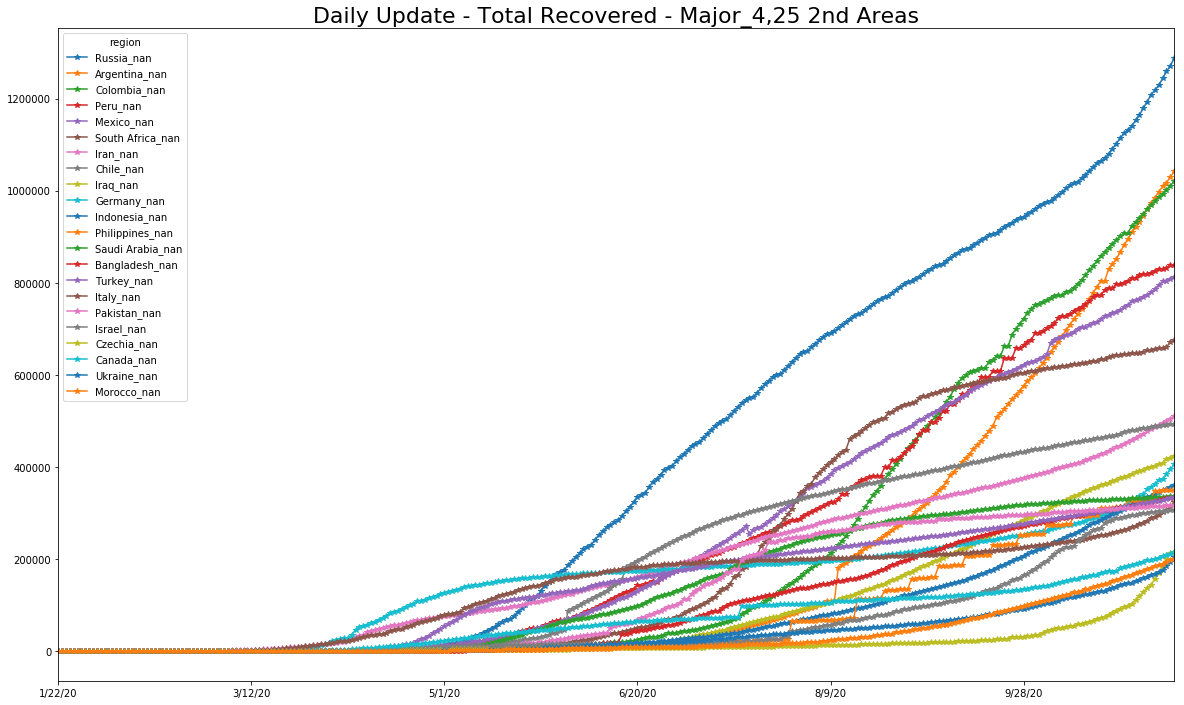

In [16]:
#
p=ts.reindex(ts.max().sort_values(ascending=False).index, axis=1)
p.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Top_3 World Region ',fontdict={'fontsize': 22})
p.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Confirmed - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_d=ts_d.reindex(ts_d.max().sort_values(ascending=False).index, axis=1)
p_d.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Top_3 World Region',fontdict={'fontsize': 22})
p_d.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Deaths - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

p_r=ts_rec.reindex(ts_rec.max().sort_values(ascending=False).index, axis=1)
p_r.iloc[:,0:3].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Top_3 World Region',fontdict={'fontsize': 22})
p_r.iloc[:,3:25].plot(marker='*',figsize=(20,12)).set_title('Daily Update - Total Recovered - Major_4,25 2nd Areas',fontdict={'fontsize': 22})

### Extract Weather Data

In [17]:
#!pip install pyweatherbit
#
from weatherbit.api import Api
import json  
import pandas as pd  
from pandas.io.json import json_normalize 

### API - Joao
from datetime import datetime

#
api_key="29d9e51c56b94621b16297bcdeee9c4d" # hxj@mail.xcom
#

api = Api(api_key)
api.set_granularity('daily')

# # Set the granularity of the API - Options: ['daily','hourly','3hourly']
# # Will only affect forecast requests.

#api.get_forecast(lat='Lat', lon='Lon')
#my_end_date=datetime.today().strftime('%Y-%m-%d')

#### United Kingdom
#lat1='55.378100'
#lon1='-3.436000'
#api.get_history(lat=lat1,lon=lon1, start_date='2020-03-29',end_date=my_end_date)


In [18]:
##
#### My List of Countries and Regions to train and represent data
my_train_list=[
 ### JOAO - LIST of Countries - Start here
     #   'Andorra_nan', 
        'United States_nan',
        'United Kingdom_nan',
        'Italy_nan',
        'Spain_nan',  
        'Netherlands_nan',
        'France_nan', 
        'Belgium_nan',
        'Portugal_nan',
        'Switzerland_nan',
        'Germany_nan',
        'Japan_nan',
        'Poland_nan',
  ### JOAO - LIST of Countries - Finish here
        'Korea, South_nan',
        'China_Hubei',
        'China_Beijing',
        'China_Guangdong',
        'China_Shanghai',
      #  'China_Shanxi',
      #  'China_Sichuan',  'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'China_Anhui', 'China_Beijing',
      #  'China_Chongqing', 'China_Fujian', 'China_Gansu',
      #  'China_Guangdong', 'China_Guangxi', 'China_Guizhou',
      #  'China_Hainan', 'China_Hebei', 'China_Heilongjiang', 'China_Henan',
      #  'China_Hubei', 'China_Hunan', 'China_Inner Mongolia',
      #  'China_Jiangsu', 'China_Jiangxi', 'China_Jilin', 'China_Liaoning',
      #  'China_Ningxia', 'China_Qinghai', 'China_Shaanxi',
      #  'China_Shandong', 'China_Shanghai', 'China_Shanxi',
      #  'China_Sichuan', 'China_Tianjin', 'China_Tibet', 'China_Xinjiang',
      #  'China_Yunnan', 'China_Zhejiang',
      #  'Morocco_nan',
        'Australia_New South Wales',
      # 'Australia_Queensland',
      # 'Australia_South Australia', 'Australia_Victoria', 
        'Brazil_nan',
      # 'Cambodia_nan',
      # 'Canada_British Columbia',
        'Canada_Ontario',
        'Canada_Quebec',
      # 'Egypt_nan',
        'China_Hong Kong',
        'China_Macau',
        'Finland_nan',
        'India_nan',
        'Iran_nan',
        'Malaysia_nan',
      # 'Nepal_nan',
        'Norway_nan',
        'Philippines_nan', 'Russia_nan', 'Singapore_nan',
     #  'Sri Lanka_nan', 'Thailand_nan', 'United Arab Emirates_nan',
        'Sweden_nan',
        'Austria_nan',
     #  'Taiwan*_nan', 
     #  'Vietnam_nan',
        'Turkey_nan',
        'Peru_nan',
        'Chile_nan',
        'Mexico_nan'
       ]
#

#### Weather History

In [19]:
# ################## already done since API is limited to 500 call per day
## consume Wether data From 15/03/2020 forward to end_date=30/03/2020
#
### Location in confirmed array to start in pos 1='Albania_nan' 61 = 'China_Hong Kong'
### Only run for Countries in above : my_train_list 
vpos=len(confirmed.iloc[1])-1 #90# 89 #88 #87 #86 #85 #84 #83 #82 #81 #80 #79 #78 #77 #76 #75 #74 #1 #73
print('xcountry_region='+confirmed.iloc[1,vpos])

my_weather_fetch_list= my_train_list # ['Canada_Quebec'] #  ['Iran_nan'] #['Brazil_nan'] #

start_date_init=pd.to_datetime('today').strftime('%Y/%m/%d') # '2020-04-18'
print('start_date_init=',start_date_init)
offset_days=-1 # -1 to start yesterday pick today # API free-tier just picks one per api call!
max_days=1 #1

w=pd.DataFrame(columns=['date','region','min','max'])
if bypass_weather != 1 :
    for h in range(0,max_days):
        offset_days=h
        start_date=pd.to_datetime(start_date_init)
        #
        end_date=(start_date+pd.DateOffset(days=offset_days+1)).strftime('%Y-%m-%d')
        start_date=(start_date+pd.DateOffset(days=offset_days)).strftime('%Y-%m-%d')
        prnt_start_date=pd.to_datetime(start_date).strftime('%Y/%m/%d')
        prnt_end_date=pd.to_datetime(end_date).strftime('%Y/%m/%d')
        #
        for i in range (1,len(confirmed)):
            if confirmed.iloc[i,vpos] not in my_weather_fetch_list:
                continue
            if confirmed.iloc[i,vpos] in my_weather_fetch_list:
                #
                # Clean JSON structure return from API Call
                jas=""
                jas=api.get_history(lat=confirmed.iloc[i,2], lon=confirmed.iloc[i,3], start_date=start_date,end_date=end_date).json
                if (((json_normalize(jas['data'])['min_temp'].values[0])=='')
                     or (np.isnan((json_normalize(jas['data'])['min_temp'].values[0])) == True )):
                    continue
                try:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':json_normalize(jas['data'])['min_temp'].values[0],'max':json_normalize(jas['data'])['max_temp'].values[0]}, ignore_index=True)
                except Exception:
                    w=w.append({'date':prnt_end_date,'region':confirmed.iloc[i,vpos] ,'min':None,'max':None}, ignore_index=True)
    #        
#
table_columns=['date','region','min','max']
w = w[w.columns.intersection(table_columns)]

xcountry_region=Albania_nan
start_date_init= 2020/11/07


In [20]:
w.to_csv('data/w_v2_v227.csv', index = False, header=True)

In [21]:
w[:]

date                     region   min   max
0   2020/11/08  Australia_New South Wales  13.1  20.9
1   2020/11/08                Austria_nan   2.2   2.4
2   2020/11/08                Belgium_nan   4.8   6.4
3   2020/11/08                 Brazil_nan  18.9  23.3
4   2020/11/08             Canada_Ontario  -0.4  -0.2
5   2020/11/08              Canada_Quebec  -9.0  -7.0
6   2020/11/08                  Chile_nan  14.0  19.0
7   2020/11/08              China_Beijing   4.0  18.0
8   2020/11/08            China_Guangdong  22.0  29.0
9   2020/11/08            China_Hong Kong  23.3  31.1
10  2020/11/08                China_Hubei  12.0  23.0
11  2020/11/08                China_Macau  23.8  28.0
12  2020/11/08             China_Shanghai  17.2  25.9
13  2020/11/08                Finland_nan   5.0  10.0
14  2020/11/08                 France_nan   8.6   9.3
15  2020/11/08                Germany_nan   1.0   3.0
16  2020/11/08                  India_nan  12.0  27.0
17  2020/11/08                   Iran_nan  11.0  19.0
18  2020/11/08                  Italy_nan   9.9  11.5
19  2020/11/08                  Japan_nan   8.3  19.4
20  2020/11/08           Korea, South_nan   6.0  21.0
21  2020/11/08               Malaysia_nan  20.5  31.0
22  2020/11/08                 Mexico_nan   9.1   9.1
23  2020/11/08            Netherlands_nan   7.8  10.6
24  2020/11/08                 Norway_nan   3.3   6.1
25  2020/11/08                   Peru_nan  23.5  23.6
26  2020/11/08            Philippines_nan  24.4  28.9
27  2020/11/08                 Poland_nan   7.8   8.3
28  2020/11/08               Portugal_nan  13.5  14.0
29  2020/11/08                 Russia_nan -17.0  -7.0
30  2020/11/08              Singapore_nan  24.5  28.5
31  2020/11/08                  Spain_nan  12.6  14.0
32  2020/11/08                 Sweden_nan   7.8   8.9
33  2020/11/08            Switzerland_nan   5.8   6.4
34  2020/11/08                 Turkey_nan   3.9   6.7
35  2020/11/08          United States_nan  16.9  16.9
36  2020/11/08         United Kingdom_nan   3.3   4.4

## Kalman Filter With R

In [22]:
# Joao - FIX - Improve Performance 
## DROP_N=15
### Drop the Months of Jan, Feb < 06/02 as
### they are too in the Past and model no longuer trains in China Hubei only!
#
## DROP_N=75 => 07/04

drop_n=drop_n_dataset_days

ts=ts[drop_n:]
ts_d=ts_d[drop_n:]
ts_rec=ts_rec[drop_n:]

In [23]:
ts[:3]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
7/15/20            34994         3752        20770          862         576   
7/16/20            35070         3851        21355          877         607   
7/17/20            35229         3906        21948          880         638   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
7/15/20                       74         111146        33005   
7/16/20                       74         114783        33559   
7/17/20                       76         119301        34001   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
7/15/20                                     113                       3527   
7/16/20                                     113                       3535   
7/17/20                                     113                       3550   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
7/15/20  ...            3496974         1009           14581          10428   
7/16/20  ...            3574352         1026           15066          10854   
7/17/20  ...            3646373         1037           15607          11191   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
7/15/20          381                    7064                  10       1526   
7/16/20          381                    7412                  10       1552   
7/17/20          382                    7764                  10       1576   

region   Zambia_nan  Zimbabwe_nan  
7/15/20        1895          1089  
7/16/20        1895          1362  
7/17/20        2810          1420  

[3 rows x 268 columns]

In [24]:
ts[-4:]

region   Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  Angola_nan  \
11/3/20            41728        21904        58979         4910       11577   
11/4/20            41814        22300        59527         5045       11813   
11/5/20            41935        22721        60169         5135       12102   
11/6/20            41975        23210        60800         5135       12223   

region   Antigua and Barbuda_nan  Argentina_nan  Armenia_nan  \
11/3/20                      128        1195276        94776   
11/4/20                      130        1205928        97150   
11/5/20                      130        1217028        99563   
11/6/20                      130        1228814       101773   

region   Australia_Australian Capital Territory  Australia_New South Wales  \
11/3/20                                     114                       4443   
11/4/20                                     114                       4445   
11/5/20                                     114                       4454   
11/6/20                                     114                       4459   

region   ...  United States_nan  Uruguay_nan  Uzbekistan_nan  Venezuela_nan  \
11/3/20  ...            9382617         3196           67553          93100   
11/4/20  ...            9485448         3245           67779          93480   
11/5/20  ...            9607336         3309           68009          93921   
11/6/20  ...            9733816         3370           68139          94305   

region   Vietnam_nan  West Bank and Gaza_nan  Western Sahara_nan  Yemen_nan  \
11/3/20         1202                   55408                  10       2063   
11/4/20         1203                   56090                  10       2063   
11/5/20         1207                   56672                  10       2063   
11/6/20         1212                   57226                  10       2067   

region   Zambia_nan  Zimbabwe_nan  
11/3/20       16661          8410  
11/4/20       16698          8427  
11/5/20       16770          8444  
11/6/20       16819          8471  

[4 rows x 268 columns]

In [25]:
# Create data for R script
ts_conf=ts.reset_index()
ts_conf=ts_conf.rename(columns = {'index':'date'})
ts_conf['date']=pd.to_datetime(ts_conf['date'] ,errors ='coerce')
ts_conf.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv')

ts_rec=ts_rec.reset_index()
ts_rec=ts_rec.rename(columns = {'index':'date'})
ts_rec['date']=pd.to_datetime(ts_rec['date'] ,errors ='coerce')
ts_rec.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_rec_r.csv')


ts_d=ts_d.reset_index()
ts_d=ts_d.rename(columns = {'index':'date'})
ts_d['date']=pd.to_datetime(ts_d['date'] ,errors ='coerce')
ts_d.to_csv(r'/home/notebookuser/notebooks/covid19/data/ts_d_r.csv')


In [26]:
%%R

#install.packages('pracma')
#install.packages('Metrics')
#install.packages('readr')
#install.packages('reshape')

Sys.setenv(TZ='GMT')
Sys.timezone()

[1] "GMT"


In [27]:
%%R
require(pracma)
require(Metrics)
require(readr)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL
date<-all[,1]
date[nrow(date) + 1,1] <-all[nrow(all),1]+1
pred_all<-NULL
for (n in 2:ncol(all)-1) {
  Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
  sig_w<-0.01
  w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
  sig_v<-0.01
  v<-sig_v*randn(1,100)   
  t<-0.45
  phi<-matrix(c(1,0,t,1),2,2)
  gama<-matrix(c(0.5*t^2,t),2,1)
  H<-matrix(c(1,0),1,2)
  #Kalman
  x0_0<-p0_0<-matrix(c(0,0),2,1)
  p0_0<-matrix(c(1,0,0,1),2,2)
  Q<-0.01
  R<-0.01
  X<-NULL
  X2<-NULL
  pred<-NULL
  for (i in 0:nrow(all)) {
    namp <-paste("p", i+1,"_",i, sep = "")
    assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
    namk <- paste("k", i+1, sep = "")
    assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
    namx <- paste("x", i+1,"_",i, sep = "")
    assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
    namE <- paste("E", i+1, sep = "")
    assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
    namx2 <- paste("x", i+1,"_",i+1, sep = "")
    assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
    namp2 <- paste("p", i+1,"_",i+1, sep = "")
    assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
    X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
    X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
    if(i>2){
      remove(list=(paste("p", i-1,"_",i-2, sep = "")))
      remove(list=(paste("k", i-1, sep = "")))
      remove(list=(paste("E", i-1, sep = "")))
      remove(list=(paste("p", i-2,"_",i-2, sep = "")))
      remove(list=(paste("x", i-1,"_",i-2, sep = "")))
      remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
  }
  pred<-NULL
  pred<-cbind(Y,X,round(X2,4))
  pred<-as.data.frame(pred)
  pred$region<-colnames(all[,n+1])
  pred$date<-date$date
  pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
  pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
  pred$pred_rate<-(pred$X/pred$Y-1)*100
  pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
  pred_all<-rbind(pred_all,pred)
}
pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
names(pred_all)[5]<-"X2"
pred_all=pred_all[with( pred_all, order(region, date)), ]
pred_all<-pred_all[,3:5]

R[write to console]: Loading required package: pracma

R[write to console]: Loading required package: Metrics

R[write to console]: Loading required package: readr

R[write to console]: 
── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [28]:
p=%R pred_all

In [29]:
############ Merge R output due to package problem
### Joao FIX - 
# t=ts_d    -  deaths
# t=ts_rec  -  recovered
# t=ts      -  confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

temp=t.iloc[:,:3]
temp=temp.reset_index(drop=True)
for i in range(1,len(t)+1):
  if(temp.iloc[i,1] is not temp.iloc[i-1,1]):
    temp.loc[len(temp)+1] = [temp.iloc[i-1,0]+ pd.DateOffset(1),temp.iloc[i-1,1], 0] 
temp=temp.sort_values(['region', 'date'])
temp=temp.reset_index(drop=True)
temp['Y']=p['Y']
temp['X']=p['X']
temp['X2']=p['X2']

# JOAO - FIX - temp fixed
# Y,X,X2 nan issue from p revolved

p_pd=pd.DataFrame(p,columns=['Y','X','X2'])

p_pd['nindex'] = range(1, 1+len(p_pd))
temp['nindex']= range(1,1+len(temp))

#temp_1 = temp.join(p_pd)
temp_1 = temp.merge(p_pd, on='nindex', how='inner', suffixes=('_1', '_2')).rename(columns={"Y_2": "Y", "X_2": "X", "X2_2" : "X2"})
temp_1 = temp_1.drop(columns=['Y_1', 'X_1','X2_1','nindex'])


temp=temp_1
temp.to_csv(r'/home/notebookuser/notebooks/covid19/data/temp.csv')

## Pre Proccessing Data for ML Model

### Extract Weather Forecast Data

In [30]:
#
### Joao - Test Later Weather from new file : w_v2.csv and w_v2_v2.csv
w_v2=pd.read_csv('data/w_v2.csv', sep=',', encoding='latin1')
w_v2['date']=pd.to_datetime(w_v2['date'],format='%Y/%m/%d')

w_v2_v2=pd.read_csv('data/w_v2_v2.csv', sep=',', encoding='latin1')
w_v2_v2['date']=pd.to_datetime(w_v2_v2['date'],format='%Y/%m/%d')

w_v2_v227=pd.read_csv('data/w_v2_v227.csv', sep=',', encoding='latin1')
w_v2_v227['date']=pd.to_datetime(w_v2_v227['date'],format='%Y/%m/%d')

w=pd.read_csv('data/w.csv', sep=',', encoding='latin1')
w['date']=pd.to_datetime(w['date'],format='%d/%m/%Y')

w_forecast=pd.read_csv('data/w_forecast.csv', sep=',', encoding='latin1')
w_forecast['date']=pd.to_datetime(w_forecast['date'],format='%d/%m/%Y')

### Append Weather fetched now to file w_v2_v2
w_n_forward=w_v2_v2.append(w_v2_v227) 
w_n_forward=w_n_forward.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_n_forward=w_n_forward.sort_values(by=['region','date'], ascending=True)
w_n_forward.to_csv(r'data/w_v2_v2.csv', index = False, header=True)

In [31]:
w_total=pd.DataFrame(columns=['date','region','min','max'])
w_total=w.append(w_forecast).append(w_v2).append(w_v2_v2).append(w_v2_v227) 
w_total=w_total.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
w_total=w_total.sort_values(by=['region','date'], ascending=True)

w_total.to_csv(r'data/w_total.csv', index = False, header=True)

In [32]:
w_in_model=pd.read_csv('data/w_total.csv', sep=',', encoding='latin1')
#
w_in_model['date']=pd.to_datetime(w_in_model['date'],format='%Y/%m/%d')
w_in_model.to_csv(r'data/w_in_model.csv', index = False, header=True)

In [33]:
w_in_model.tail(2)

date       region   min   max
7047 2020-05-10  Vietnam_nan  26.9  33.0
7048 2020-05-11  Vietnam_nan  25.0  33.0

### Build Train Set Data Structure

In [34]:
### JOAO - Fix -
## t=ts confirmed
t=ts
t=t.stack().reset_index(name='confirmed')
t.columns=['date', 'region','confirmed']
t['date']=pd.to_datetime(t['date'] ,errors ='coerce')
t=t.sort_values(['region', 'date'])

# Add 1 Future day for prediction
t=t.reset_index(drop=True)
for i in range(1,len(t)+1):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        t.loc[len(t)+1] = [t.iloc[i-1,0]+ pd.DateOffset(1),t.iloc[i-1,1], 0] 
t=t.sort_values(['region', 'date'])
t=t.reset_index(drop=True)

In [35]:
### JOAO - Fix -
t['1_day_change']=t['3_day_change']=t['7_day_change']=t['1_day_change_rate']=t['3_day_change_rate']=t['7_day_change_rate']=t['last_day']=0
#
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
for i in range(1,len(t)):
    if(t.iloc[i,1] is t.iloc[i-2,1]):
        t.iloc[i,3]=t.iloc[i-1,2]-t.iloc[i-2,2]
        t.iloc[i,6]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-2,2]*100 -1 +1))*100
        t.iloc[i,9]=t.iloc[i-1,2]
    if(t.iloc[i,1] is t.iloc[i-4,1]):
        t.iloc[i,4]=t.iloc[i-1,2]-t.iloc[i-4,2]
        t.iloc[i,7]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-4,2]*100 -1 +1))*100
    if(t.iloc[i,1] is t.iloc[i-8,1]):
        t.iloc[i,5]=t.iloc[i-1,2]-t.iloc[i-8,2]
        t.iloc[i,8]=((t.iloc[i-1,2]*100 +1)/(t.iloc[i-8,2]*100 -1 +1))*100
t=t.fillna(0)  
t=t.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
t=t.rename(columns = {'X':'kalman_prediction'}) 
t=t.replace([np.inf, -np.inf], 0)

### Joao - Fix NaN Kalman_Filter
t['kalman_prediction']=np.nan_to_num(t['kalman_prediction'])
t['kalman_prediction']=round(t['kalman_prediction'])

#
train=t.merge(confirmed[['region',' Population ']],how='left',on='region')
train=train.rename(columns = {' Population ':'population'})
train['population']=train['population'].str.replace(r" ", '')
train['population']=train['population'].str.replace(r",", '')
train['population']=train['population'].fillna(10000000) ### Fill 10M if nan
train['population']=train['population'].astype('int32')
### JOAO - Fix - ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
# train['infected_rate']=train['last_day']/train['population']*10000
train['infected_rate']=(((train['last_day'] +1)*100)/((train['population'] +1)*100000) *10) # *100 - % converter
 #
#### Joao , merge w weather only !?!
##train=train.merge(w,how='left',on=['date','region'])
train=train.merge(w_in_model,how='left',on=['date','region'])
#
train=train.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(train)):
    if(np.isnan(train.iloc[i,13])):
        if(train.iloc[i,1] is train.iloc[i-1,1]):
            train.iloc[i,13]=train.iloc[i-1,13]
            train.iloc[i,14]=train.iloc[i-1,14]

/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in long_scalars
  
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in long_scalars
  if sys.path[0] == '':
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: divide by zero encountered in long_scalars
  from ipykernel import kernelapp as app


In [36]:
# Joao - Fix - Nulls are an issue
train_notnull=train[train['kalman_prediction'] != 0.0 ] #.any(axis=1)]
train_notnull[:]

date           region  confirmed  1_day_change  3_day_change  \
1     2020-07-16  Afghanistan_nan      35070             0             0   
2     2020-07-17  Afghanistan_nan      35229            76             0   
3     2020-07-18  Afghanistan_nan      35301           159             0   
4     2020-07-19  Afghanistan_nan      35475            72           307   
5     2020-07-20  Afghanistan_nan      35526           174           405   
6     2020-07-21  Afghanistan_nan      35615            51           297   
7     2020-07-22  Afghanistan_nan      35727            89           314   
8     2020-07-23  Afghanistan_nan      35928           112           252   
9     2020-07-24  Afghanistan_nan      35981           201           402   
10    2020-07-25  Afghanistan_nan      36036            53           366   
11    2020-07-26  Afghanistan_nan      36157            55           309   
12    2020-07-27  Afghanistan_nan      36263           121           229   
13    2020-07-28  Afghanistan_nan      36368           106           282   
14    2020-07-29  Afghanistan_nan      36471           105           332   
15    2020-07-30  Afghanistan_nan      36542           103           314   
16    2020-07-31  Afghanistan_nan      36675            71           279   
17    2020-08-01  Afghanistan_nan      36710           133           307   
18    2020-08-02  Afghanistan_nan      36710            35           239   
19    2020-08-03  Afghanistan_nan      36747             0           168   
20    2020-08-04  Afghanistan_nan      36782            37            72   
21    2020-08-05  Afghanistan_nan      36829            35            72   
22    2020-08-06  Afghanistan_nan      36896            47           119   
23    2020-08-07  Afghanistan_nan      37015            67           149   
24    2020-08-08  Afghanistan_nan      37054           119           233   
25    2020-08-09  Afghanistan_nan      37054            39           225   
26    2020-08-10  Afghanistan_nan      37162             0           158   
27    2020-08-11  Afghanistan_nan      37269           108           147   
28    2020-08-12  Afghanistan_nan      37345           107           215   
29    2020-08-13  Afghanistan_nan      37424            76           291   
30    2020-08-14  Afghanistan_nan      37431            79           262   
...          ...              ...        ...           ...           ...   
31754 2020-10-09     Zimbabwe_nan       7994            32            53   
31755 2020-10-10     Zimbabwe_nan       8010            43            79   
31756 2020-10-11     Zimbabwe_nan       8011            16            91   
31757 2020-10-12     Zimbabwe_nan       8021             1            60   
31758 2020-10-13     Zimbabwe_nan       8036            10            27   
31759 2020-10-14     Zimbabwe_nan       8055            15            26   
31760 2020-10-15     Zimbabwe_nan       8075            19            44   
31761 2020-10-16     Zimbabwe_nan       8099            20            54   
31762 2020-10-17     Zimbabwe_nan       8110            24            63   
31763 2020-10-18     Zimbabwe_nan       8147            11            55   
31764 2020-10-19     Zimbabwe_nan       8159            37            72   
31765 2020-10-20     Zimbabwe_nan       8187            12            60   
31766 2020-10-21     Zimbabwe_nan       8215            28            77   
31767 2020-10-22     Zimbabwe_nan       8242            28            68   
31768 2020-10-23     Zimbabwe_nan       8257            27            83   
31769 2020-10-24     Zimbabwe_nan       8269            15            70   
31770 2020-10-25     Zimbabwe_nan       8276            12            54   
31771 2020-10-26     Zimbabwe_nan       8303             7            34   
31772 2020-10-27     Zimbabwe_nan       8315            27            46   
31773 2020-10-28     Zimbabwe_nan       8320            12            46   
31774 2020-10-29     Zimbabwe_nan       8349             5  

In [37]:
# Joao - Fix - Nulls are an issue
train_nulls=train[train['kalman_prediction'].isnull() ] #.any(axis=1)]
train_nulls[:]

Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [38]:
# Joao - Fix - Nulls are an issue

train_nulls=train[train.isnull().any(axis=1)]
train_nulls[:]
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
31783 2020-11-07  Zimbabwe_nan          0            27            61   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
31783           109         100.319872         100.725446         101.303635   

       last_day  kalman_prediction  population  infected_rate  min  max  
31783      8471             8480.0    14862924       0.000006  NaN  NaN

In [39]:
## JOAO - FIX Drop Duplicates
train=train.drop_duplicates(subset=['date','region'], keep='last', inplace=False)
## JOAO - FIX Drop empty region='nan_nan'
train=train[train['region']!='nan_nan']
train[-1:]

date        region  confirmed  1_day_change  3_day_change  \
31783 2020-11-07  Zimbabwe_nan          0            27            61   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
31783           109         100.319872         100.725446         101.303635   

       last_day  kalman_prediction  population  infected_rate  min  max  
31783      8471             8480.0    14862924       0.000006  NaN  NaN

In [40]:
train.to_csv(r'data/train.csv', index = False, header=True)

##Shared -- Ratio in Confirmed - 21Day Forecast -- train 25April2020 - I
ratiod=pd.read_csv('data/train.csv', sep=',', encoding='latin1')
todayd=datetime.today().strftime('%Y-%m-%d')
ratiofn="World v2 -- Confirmed - "+str(num_days_R_prediction)+"Day Forecast -- train "+todayd+".csv"

ratiod['population_percentage : infected_rate confirmed']=ratiod['infected_rate']*100
ratiod['population_percentage : factor 9/10 infected_rate confirmed']=ratiod['infected_rate']*1000
ratiod['delta : new_cases']=ratiod['kalman_prediction']-ratiod['last_day']
ratiod['delta : new_cases per 1M hab']=ratiod['delta : new_cases']/ratiod['population']*1000000

### roling 7day_AVG
ratiod['delta : roling 7day AVG']=ratiod['7_day_change']/7
ratiod['delta : aprox 14-day case notification rate per 100k hab']=(ratiod['7_day_change']*2)/ratiod['population']*100000
###

ratiod=ratiod.rename(columns={'kalman_prediction': 'confirmed_prediction', 'last_day': 'confirmed_yesterday'})
ratiod.to_csv(r'data/'+ratiofn, index = False, header=True)
ratiod[-3:]

date        region  confirmed  1_day_change  3_day_change  \
31085  2020-11-05  Zimbabwe_nan       8444            17            53   
31086  2020-11-06  Zimbabwe_nan       8471            17            55   
31087  2020-11-07  Zimbabwe_nan          0            27            61   

       7_day_change  1_day_change_rate  3_day_change_rate  7_day_change_rate  \
31085           107         100.202259         100.633031         101.286178   
31086            95         100.201851         100.655740         101.137981   
31087           109         100.319872         100.725446         101.303635   

       confirmed_yesterday  ...  population  infected_rate  min  max  \
31085                 8427  ...    14862924       0.000006  NaN  NaN   
31086                 8444  ...    14862924       0.000006  NaN  NaN   
31087                 8471  ...    14862924       0.000006  NaN  NaN   

       population_percentage : infected_rate confirmed  \
31085                                         0.000567   
31086                                         0.000568   
31087                                         0.000570   

       population_percentage : factor 9/10 infected_rate confirmed  \
31085                                           0.005670             
31086                                           0.005682             
31087                                           0.005700             

       delta : new_cases  delta : new_cases per 1M hab  \
31085               10.0                      0.672815   
31086               11.0                      0.740097   
31087                9.0                      0.605534   

       delta : roling 7day AVG  \
31085                15.285714   
31086                13.571429   
31087                15.571429   

       delta : aprox 14-day case notification rate per 100k hab  
31085                                           1.439824         
31086                                           1.278349         
31087                                           1.466737         

[3 rows x 21 columns]

## Kalman 1 day Prediction with Evaluation

                region           mse          rmse            mae
258  United States_nan  8.389372e+11  915935.17246  100856.921739


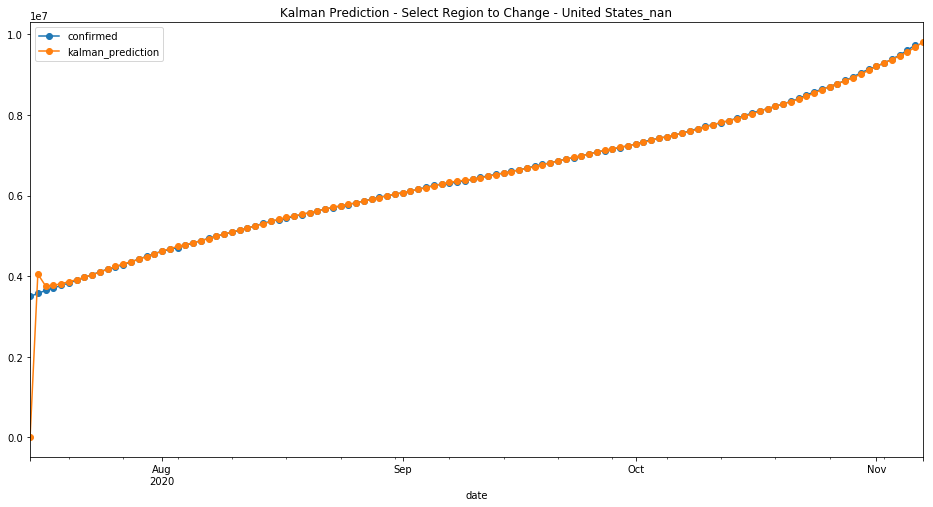

In [41]:
# Select region
region='United States_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

         region           mse           rmse           mae
209  Russia_nan  2.637254e+10  162396.248339  17499.452174


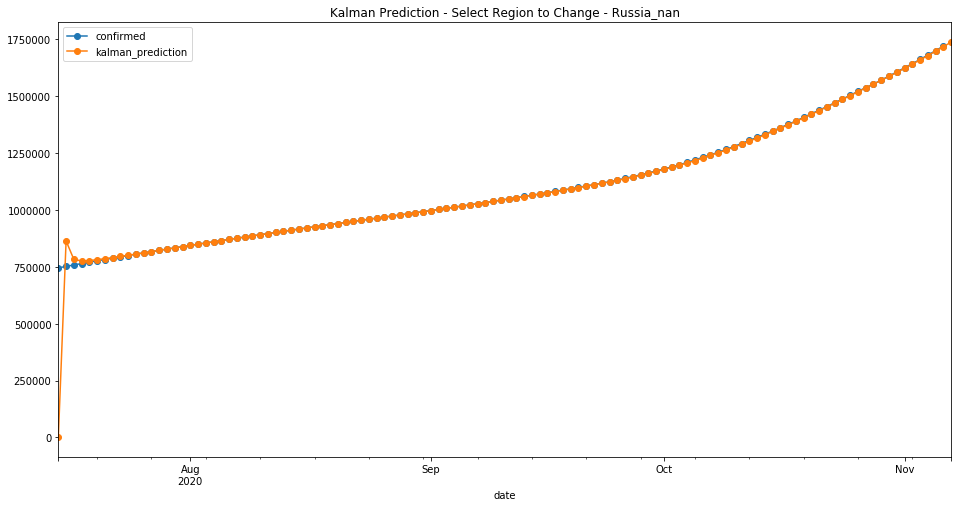

In [42]:
# Select region
region='Russia_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

        region           mse           rmse           mae
30  Brazil_nan  2.772889e+11  526582.248972  66924.973913


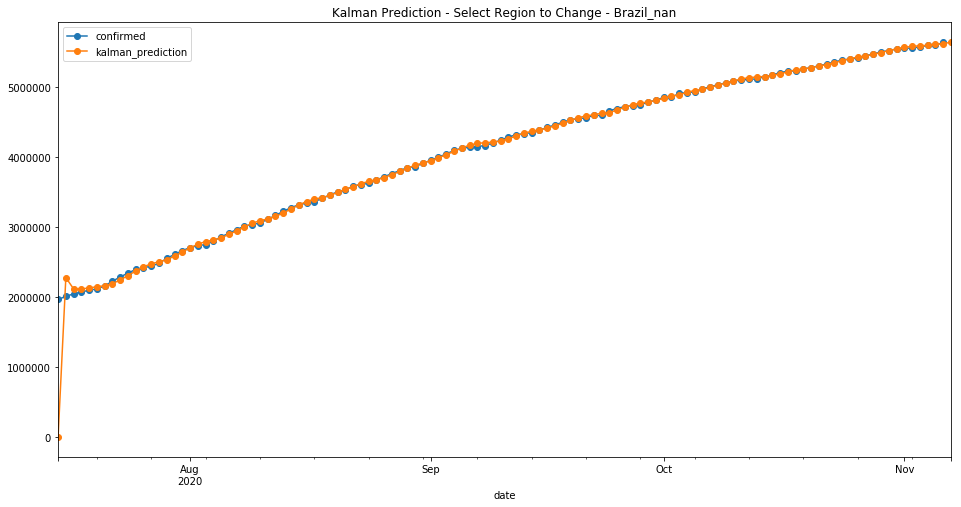

In [43]:
# Select region
region='Brazil_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

                 region           mse           rmse           mae
257  United Kingdom_nan  1.189278e+10  109054.039337  12359.434783


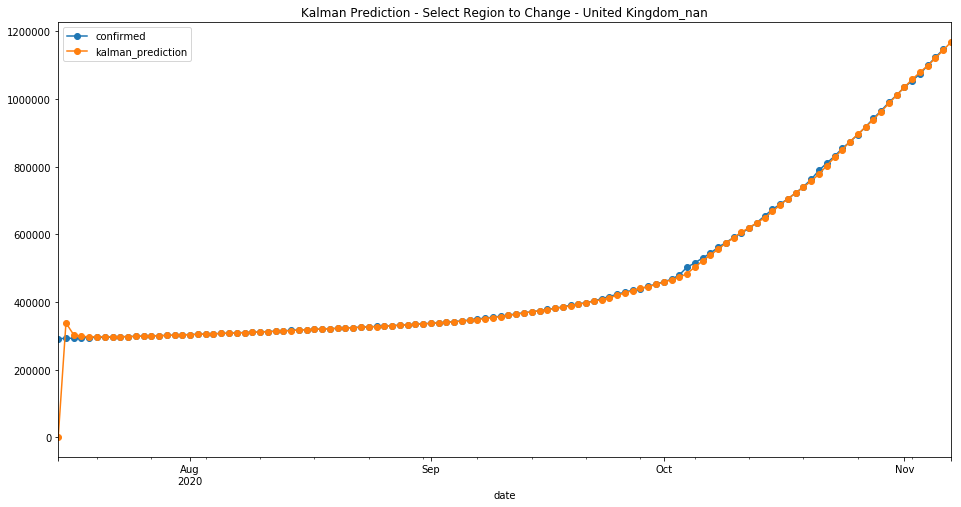

In [44]:
# Select region
region='United Kingdom_nan'

evaluation=pd.DataFrame(columns=['region','mse','rmse','mae'])
place=0
for i in range(1,len(t)):
    if(t.iloc[i,1] is not t.iloc[i-1,1]):
        ex=np.array(t.iloc[i-len(ts):i,10])
        pred=np.array(t.iloc[i-len(ts):i,2])
        evaluation=evaluation.append({'region': t.iloc[i-1,1], 'mse': np.power((ex - pred),2).mean(),'rmse':sqrt(mean_squared_error(ex,pred)),'mae': (abs(ex - pred)).mean()}, ignore_index=True)
p=t[t['region']==region][['date','region','confirmed','kalman_prediction']]
#p=p.rename(columns = {'confirmed':'recoverd'})
p.iloc[len(p)-1,2]=None
p=p.set_index(['date'])
p.iloc[:,1:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Region to Change - {}'.format(p.iloc[0,0]))

print(evaluation[evaluation['region']==p.iloc[0,0]])

## Regression - 1 Day Prediction

In [45]:
#!pip install h2o
import h2o
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
h2o.init(min_mem_size='3G')
import numpy as np
from sklearn.linear_model import LinearRegression

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.9" 2020-10-20; OpenJDK Runtime Environment (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1); OpenJDK 64-Bit Server VM (build 11.0.9+11-Ubuntu-0ubuntu1.18.04.1, mixed mode, sharing)
  Starting server from /home/notebookuser/anaconda3/lib/python3.7/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpuecx1aq8
  JVM stdout: /tmp/tmpuecx1aq8/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmpuecx1aq8/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ------------------------------------------------------------------
H2O_cluster_uptime:         02 secs
H2O_cluster_timezone:       Etc/GMT
H2O_data_parsing_timezone:  UTC
H2O_cluster_version:        3.30.1.3
H2O_cluster_version_age:    1 month and 9 days
H2O_cluster_name:           H2O_from_python_unknownUser_nr6vu9
H2O_cluster_total_nodes:    1
H2O_cluster_free_memory:    3.049 Gb
H2O_cluster_total_cores:    10
H2O_cluster_allowed_cores:  10
H2O_cluster_status:         accepting new members, healthy
H2O_connection_url:         http://127.0.0.1:54321
H2O_connection_proxy:       {"http": null, "https": null}
H2O_internal_security:      False
H2O_API_Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, TargetEncoder, Core V4
Python_version:             3.7.7 final
--------------------------  ------------------------------------------------------------------

In [46]:

train=train.fillna(0)

########################################################

### Joao - Training  progression - When growth happened 2020/03/05 to 2020/04/12
### Joao - FIX - Refresh this daily forward

### Old Fixed manual ### Last run 17April2020
##
#train_df=train[train['date']>'2020-03-04']
#train_df=train[train['date']<'2020-04-16']
#boots=train_df[train_df['date']>='2020-04-08'] # some bootstrap to give more weight for recent days
#train_df=train_df.append([boots[boots['date']>='2020-04-12']]*1000,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
#region_to_train=my_train_list
#train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
#test=train[train['date']>='2020-04-03']
#test=test[test['date']<'2020-04-17']
#test_v2=test[test['region'].isin(region_to_train)]
#valid_v2=test_v2[test_v2['date']>='2020-04-16']

########################################################

# Set minimum of 14 training day 2weeks.
#
if number_past_days_training>=7 : 
    ntraindays=number_past_days_training 
else : 
    ntraindays=7
#
to_day=pd.to_datetime('today')
first_train_date=(to_day+pd.DateOffset(days=-ntraindays)).strftime('%Y-%m-%d') # ntraindays/7 weeks =ntraindays days training
last_train_date=(to_day+pd.DateOffset(days=-1)).strftime('%Y-%m-%d')
first_bootstrap_date=(to_day+pd.DateOffset(days=-9)).strftime('%Y-%m-%d')
boost_bootstrap_date=(to_day+pd.DateOffset(days=-4)).strftime('%Y-%m-%d')
first_test_date=(to_day+pd.DateOffset(days=-10)).strftime('%Y-%m-%d')
last_test_date=to_day.strftime('%Y-%m-%d')
first_valid_date=(to_day+pd.DateOffset(days=-2)).strftime('%Y-%m-%d')

print('first_train_date=',first_train_date)
print('last_train_date=',last_train_date)
print('first_bootstrap_date=',first_bootstrap_date)
print('boost_bootstrap_date=',boost_bootstrap_date)
print('first_test_date=',first_test_date)
print('last_test_date=',last_test_date)
print('first_valid_date=',first_valid_date)

train_df=train[train['date']>first_train_date]
train_df=train[train['date']<last_train_date]
boots=train_df[train_df['date']>=first_bootstrap_date] # some bootstrap to give more weight for recent days
train_df=train_df.append([boots[boots['date']>=boost_bootstrap_date]]*5,ignore_index=True)

### Train progression of the Virus ### In Country list or Spain only
region_to_train=my_train_list
train_df_v2=train_df[train_df['region'].isin(region_to_train)] # =='Spain_nan'] #
test=train[train['date']>first_test_date]
test=test[test['date']<=last_test_date]
test_v2=test[test['region'].isin(region_to_train)]
valid_v2=test_v2[test_v2['date']>=first_valid_date]


first_train_date= 2020-10-30
last_train_date= 2020-11-06
first_bootstrap_date= 2020-10-29
boost_bootstrap_date= 2020-11-03
first_test_date= 2020-10-28
last_test_date= 2020-11-07
first_valid_date= 2020-11-05


In [47]:
x_col=[#'region',
            '1_day_change', '3_day_change','7_day_change',
            '1_day_change_rate', 
            '3_day_change_rate',
            '7_day_change_rate', 
            'last_day',
            'min', 'max',
            'infected_rate',
            'kalman_prediction'
          #  ,'population_percent_infected_rate_confirmed'
          #  ,'delta_new_cases'
          #  ,'delta_new_cases_per_1M_hab'
          ]

In [48]:
x=train_df[x_col]
y=train_df['confirmed']
reg = LinearRegression().fit(x,y)

pred2=reg.predict(test[x_col]); pred2=pd.DataFrame(pred2); pred2=round(pred2)
pred2['confirmed']=test['confirmed'].values; pred2['date']=test['date'].values; pred2['region']=test['region'].values


In [49]:
pred2.iloc[:25]

0  confirmed       date           region
0   41340.0      41268 2020-10-29  Afghanistan_nan
1   41459.0      41334 2020-10-30  Afghanistan_nan
2   41557.0      41425 2020-10-31  Afghanistan_nan
3   41644.0      41501 2020-11-01  Afghanistan_nan
4   41727.0      41633 2020-11-02  Afghanistan_nan
5   41830.0      41728 2020-11-03  Afghanistan_nan
6   41937.0      41814 2020-11-04  Afghanistan_nan
7   42031.0      41935 2020-11-05  Afghanistan_nan
8   42138.0      41975 2020-11-06  Afghanistan_nan
9   42215.0          0 2020-11-07  Afghanistan_nan
10  20370.0      20315 2020-10-29      Albania_nan
11  20673.0      20634 2020-10-30      Albania_nan
12  20956.0      20875 2020-10-31      Albania_nan
13  21260.0      21202 2020-11-01      Albania_nan
14  21517.0      21523 2020-11-02      Albania_nan
15  21838.0      21904 2020-11-03      Albania_nan
16  22176.0      22300 2020-11-04      Albania_nan
17  22573.0      22721 2020-11-05      Albania_nan
18  23002.0      23210 2020-11-06      Albania_nan
19  23472.0          0 2020-11-07      Albania_nan
20  57368.0      57332 2020-10-29      Algeria_nan
21  57688.0      57651 2020-10-30      Algeria_nan
22  58015.0      57942 2020-10-31      Algeria_nan
23  58329.0      58272 2020-11-01      Algeria_nan
24  58657.0      58574 2020-11-02      Algeria_nan

In [50]:
pred2.iloc[175:195]

0  confirmed       date          region
175  58168.0      58282 2020-11-03  Azerbaijan_nan
176  59273.0      59509 2020-11-04  Azerbaijan_nan
177  60484.0      60873 2020-11-05  Azerbaijan_nan
178  61824.0      62338 2020-11-06  Azerbaijan_nan
179  63321.0          0 2020-11-07  Azerbaijan_nan
180   6747.0       6607 2020-10-29     Bahamas_nan
181   6770.0       6644 2020-10-30     Bahamas_nan
182   6839.0       6714 2020-10-31     Bahamas_nan
183   6827.0       6714 2020-11-01     Bahamas_nan
184   6979.0       6735 2020-11-02     Bahamas_nan
185   6947.0       6790 2020-11-03     Bahamas_nan
186   6901.0       6843 2020-11-04     Bahamas_nan
187   6954.0       6882 2020-11-05     Bahamas_nan
188   7025.0       6882 2020-11-06     Bahamas_nan
189   7116.0          0 2020-11-07     Bahamas_nan
190  81530.0      81262 2020-10-29     Bahrain_nan
191  81750.0      81466 2020-10-30     Bahrain_nan
192  81939.0      81645 2020-10-31     Bahrain_nan
193  82101.0      81923 2020-11-01     Bahrain_nan
194  82328.0      82133 2020-11-02     Bahrain_nan

In [51]:
pred2.iloc[220:240]

0  confirmed       date       region
220   96409.0      96529 2020-10-29  Belarus_nan
221   97425.0      97499 2020-10-30  Belarus_nan
222   98440.0      98482 2020-10-31  Belarus_nan
223   99464.0      99459 2020-11-01  Belarus_nan
224  100480.0     100400 2020-11-02  Belarus_nan
225  101460.0     101329 2020-11-03  Belarus_nan
226  102412.0     102313 2020-11-04  Belarus_nan
227  103390.0     103295 2020-11-05  Belarus_nan
228  104366.0     104286 2020-11-06  Belarus_nan
229  105354.0          0 2020-11-07  Belarus_nan
230  384862.0     392258 2020-10-29  Belgium_nan
231  407923.0     412314 2020-10-30  Belgium_nan
232  429074.0     429229 2020-10-31  Belgium_nan
233  448286.0     441018 2020-11-01  Belgium_nan
234  462359.0     447355 2020-11-02  Belgium_nan
235  470025.0     452541 2020-11-03  Belgium_nan
236  474510.0     468213 2020-11-04  Belgium_nan
237  486488.0     479341 2020-11-05  Belgium_nan
238  494241.0     488044 2020-11-06  Belgium_nan
239  501556.0          0 2020-11-07  Belgium_nan

In [52]:
#
train_h20 = h2o.H2OFrame(train_df)
###train_h20_hubei = h2o.H2OFrame(train_df_hubei) # different model for Hubei
#
### Joao - Italian Model
train_h20_v2 = h2o.H2OFrame(train_df_v2) # different model for V2 region ### Spain This time


test_h20 = h2o.H2OFrame(test)
#test_h20_hubei = h2o.H2OFrame(test_hubei)
test_h20_v2 = h2o.H2OFrame(test_v2)

valid_h20_v2=h2o.H2OFrame(valid_v2)

#training_columns = ['region','1_day_change', '3_day_change', '7_day_change','1_day_change_rate','3_day_change_rate','7_day_change_rate','last_day', 'kalman_prediction','infected_rate', 'min', 'max']
training_cols_v2 = ['region']+x_col #+['population_percent_infected_rate_confirmed','delta_new_cases','delta_new_cases_per_1M_hab']
training_columns = training_cols_v2

# Output parameter train against input parameters
response_column = 'confirmed'

# model = H2ORandomForestEstimator(ntrees=300, max_depth=12)
# model.train(x=training_columns, y=response_column, training_frame=train_h20)

###model_hubei = H2ORandomForestEstimator(ntrees=300, max_depth=12)
###model_hubei.train(x=training_columns, y=response_column, training_frame=train_h20_hubei)

### Joao - Model V2
model_v2 = H2ORandomForestEstimator(ntrees=500, max_depth=23)
model_v2.train(x=training_columns, y=response_column, training_frame=train_h20_v2, validation_frame=valid_h20_v2)


Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%


In [53]:
#Print Model

print('# MSE on the training data = ',model_v2.mse())
print('# MSE on the validation data = ',model_v2.mse(valid=True))
print('# R^2 on the training data = ',model_v2.r2())
print('# R^2 on the validation data = ',model_v2.r2(valid=True))

# MSE on the training data =  2593479812.0038495
# MSE on the validation data =  1770626752882.061
# R^2 on the training data =  0.9989365037938144
# R^2 on the validation data =  0.4667291836787164


In [54]:
model_v2.show()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1604728920284_1


Model Summary: 


number_of_trees  number_of_internal_trees  model_size_in_bytes  \
0              500.0                     500.0           15109727.0   

   min_depth  max_depth  mean_depth  min_leaves  max_leaves  mean_leaves  
0       20.0       23.0      22.832      2060.0      2467.0     2363.436



ModelMetricsRegression: drf
** Reported on train data. **

MSE: 2593479812.0038495
RMSE: 50926.21929815573
MAE: 4273.007027076816
RMSLE: 0.2401035848692127
Mean Residual Deviance: 2593479812.0038495

ModelMetricsRegression: drf
** Reported on validation data. **

MSE: 1770626752882.061
RMSE: 1330648.9968741047
MAE: 343179.769547558
RMSLE: 7.084181362293262
Mean Residual Deviance: 1770626752882.061

Scoring History: 


timestamp    duration  number_of_trees  training_rmse  \
0     2020-11-07 06:02:09   0.094 sec              0.0            NaN   
1     2020-11-07 06:02:09   0.542 sec              1.0   66611.414369   
2     2020-11-07 06:02:09   0.745 sec              2.0   87505.574048   
3     2020-11-07 06:02:10   0.864 sec              3.0  108257.244361   
4     2020-11-07 06:02:10   1.095 sec              4.0  103740.794272   
5     2020-11-07 06:02:10   1.187 sec              5.0   83370.576717   
6     2020-11-07 06:02:10   1.270 sec              6.0   79941.336225   
7     2020-11-07 06:02:10   1.353 sec              7.0   74912.454572   
8     2020-11-07 06:02:10   1.471 sec              8.0   75110.996841   
9     2020-11-07 06:02:10   1.542 sec              9.0   73493.051807   
10    2020-11-07 06:02:10   1.619 sec             10.0   69412.807423   
11    2020-11-07 06:02:10   1.677 sec             11.0   69601.454252   
12    2020-11-07 06:02:11   1.786 sec             12.0   68065.483895   
13    2020-11-07 06:02:11   1.878 sec             13.0   68443.729031   
14    2020-11-07 06:02:11   2.004 sec             14.0   62323.330018   
15    2020-11-07 06:02:11   2.155 sec             15.0   60454.142583   
16    2020-11-07 06:02:11   2.276 sec             16.0   60511.973357   
17    2020-11-07 06:02:11   2.433 sec             17.0   60447.146325   
18    2020-11-07 06:02:11   2.559 sec             18.0   61318.850753   
19    2020-11-07 06:02:11   2.609 sec             19.0   61483.306642   

    training_mae  training_deviance  validation_rmse  validation_mae  \
0            NaN                NaN              NaN             NaN   
1   11981.061322       4.437081e+09     1.366268e+06   358626.357193   
2   12111.722796       7.657225e+09     1.365439e+06   347790.842884   
3   12420.126932       1.171963e+10     1.366482e+06   345594.512279   
4   12400.010599       1.076215e+10     1.398681e+06   352275.197677   
5   11486.089641       6.950653e+09     1.392581e+06   349832.312372   
6   10801.717134       6.390617e+09     1.388615e+06   348834.471060   
7   10484.874717       5.611876e+09     1.385772e+06   348700.977336   
8   10083.853796       5.641662e+09     1.361671e+06   347743.434560   
9    9660.115413       5.401229e+09     1.362336e+06   347107.491208   
10   9048.084884       4.818138e+09     1.363395e+06   347141.462808   
11   8862.744355       4.844362e+09     1.365121e+06   346741.071759   
12   8435.461931       4.632910e+09     1.365015e+06   346509.179190   
13   8357.821551       4.684544e+09     1.365254e+06   346065.868016   
14   7932.548043       3.884197e+09     1.365398e+06   345615.464637   
15   7605.349737       3.654703e+09     1.374278e+06   347374.473756   
16   7616.882273       3.661699e+09     1.374126e+06   349370.871960   
17   7591.267075       3.653857e+09     1.373686e+06   348977.847174   
18   7637.697017       3.760001e+09     1.373286e+06   348626.915317   
19   7409.509143       3.780197e+09     1.373688e+06   348375.178813   

    validation_deviance  
0                   NaN  
1          1.866689e+12  
2          1.864424e+12  
3          1.867274e+12  
4          1.956309e+12  
5          1.939283e+12  
6          1.928252e+12  
7          1.920363e+12  
8          1.854148e+12  
9          1.855960e+12  
10         1.858847e+12  
11         1.863555e+12  
12         1.863266e+12  
13         1.863918e+12  
14         1.864312e+12  
15         1.888640e+12  
16         1.888223e+12  
17         1.887013e+12  
18         1.885913e+12  
19         1.887019e+12


See the whole table with table.as_data_frame()

Variable Importances: 


variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         1.854176e+18           1.000000    0.348927
1            last_day         1.502943e+18           0.810572    0.282830
2              region         8.364095e+17           0.451095    0.157399
3        7_day_change         5.222204e+17           0.281646    0.098274
4        3_day_change         2.941286e+17           0.158630    0.055350
5        1_day_change         1.531751e+17           0.082611    0.028825
6       infected_rate         6.432082e+16           0.034690    0.012104
7   7_day_change_rate         3.676799e+16           0.019830    0.006919
8   3_day_change_rate         2.899975e+16           0.015640    0.005457
9   1_day_change_rate         2.041848e+16           0.011012    0.003842
10                max         3.288737e+14           0.000177    0.000062
11                min         5.162390e+13           0.000028    0.000010

In [55]:
#model_hubei.varimp(True).iloc[:,:] # Feature importance for Hubei Model RF
### Joao -  Model V2
modlv2=model_v2.varimp(True).iloc[:,:] # Feature importance for Model V2 Global RF
modlv2.sort_values('percentage',ascending=False)

variable  relative_importance  scaled_importance  percentage
0   kalman_prediction         1.854176e+18           1.000000    0.348927
1            last_day         1.502943e+18           0.810572    0.282830
2              region         8.364095e+17           0.451095    0.157399
3        7_day_change         5.222204e+17           0.281646    0.098274
4        3_day_change         2.941286e+17           0.158630    0.055350
5        1_day_change         1.531751e+17           0.082611    0.028825
6       infected_rate         6.432082e+16           0.034690    0.012104
7   7_day_change_rate         3.676799e+16           0.019830    0.006919
8   3_day_change_rate         2.899975e+16           0.015640    0.005457
9   1_day_change_rate         2.041848e+16           0.011012    0.003842
10                max         3.288737e+14           0.000177    0.000062
11                min         5.162390e+13           0.000028    0.000010

In [56]:
## Joao - Model Predictions - Country_nan _v2
performance = model_v2.model_performance(test_data=test_h20_v2)
# # Model Create Predictions
pred=model_v2.predict(test_h20_v2);pred=pred.as_data_frame(); pred=round(pred)
# #pred['daily_outcome']=test['daily_outcome'].values
pred['confirmed']=test_v2['confirmed'].values
pred['date']=test_v2['date'].values
pred['region']=test_v2['region'].values

drf prediction progress: |████████████████████████████████████████████████| 100%


## Correlation Matrix And Temperature

Correlation Matrix


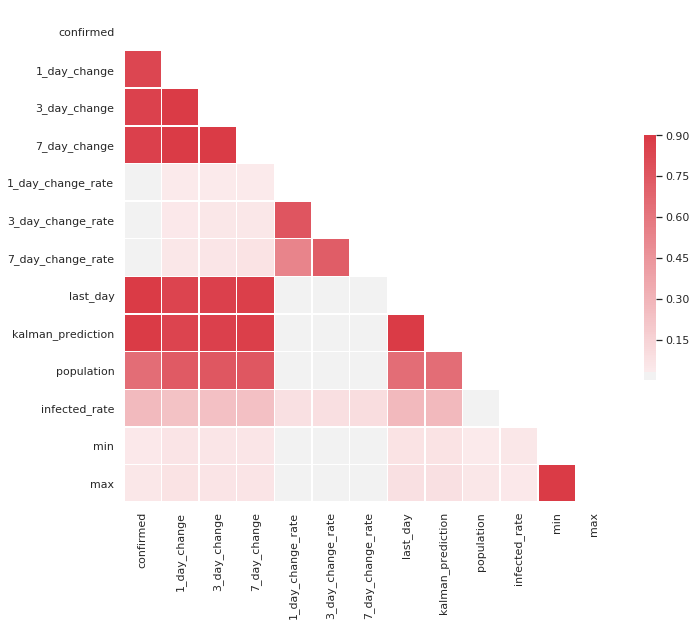

In [57]:
from string import ascii_letters
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white")
# Compute the correlation matrix
corr = train.iloc[:,2:].corr()
# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.9, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
print ('Correlation Matrix')

In [58]:
print('Correlation To Confirmed') 
print (corr.confirmed)

Correlation To Confirmed
confirmed            1.000000
1_day_change         0.835684
3_day_change         0.855216
7_day_change         0.865947
1_day_change_rate    0.020841
3_day_change_rate    0.022953
7_day_change_rate    0.025037
last_day             0.987968
kalman_prediction    0.988945
population           0.648609
infected_rate        0.272211
min                  0.047735
max                  0.054493
Name: confirmed, dtype: float64


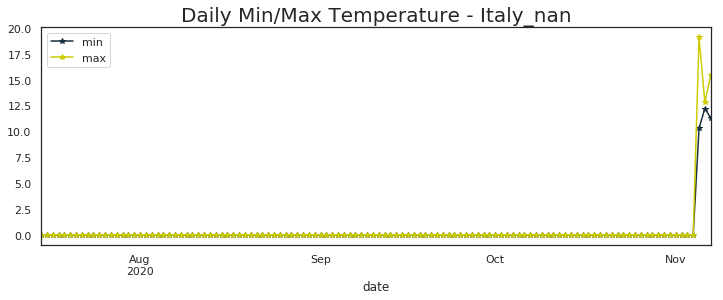

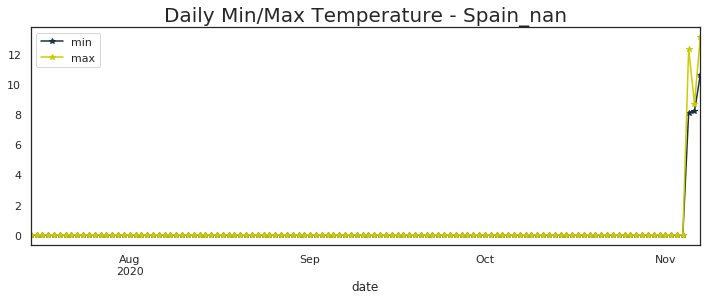

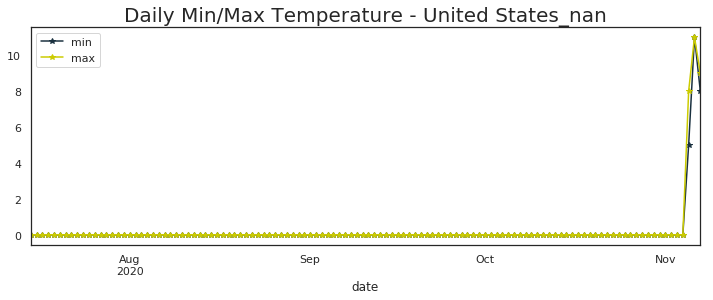

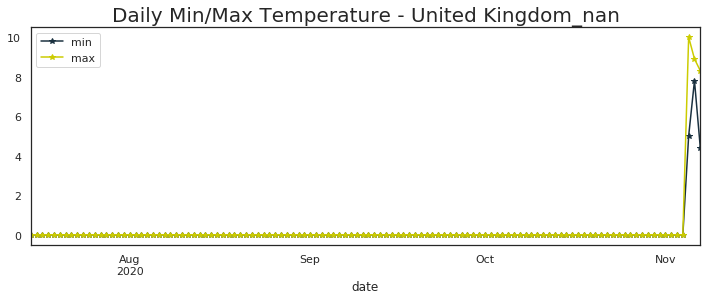

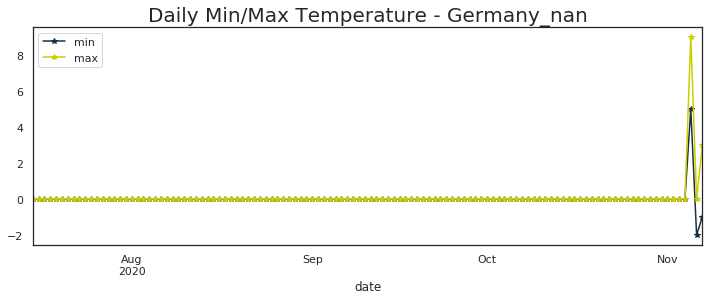

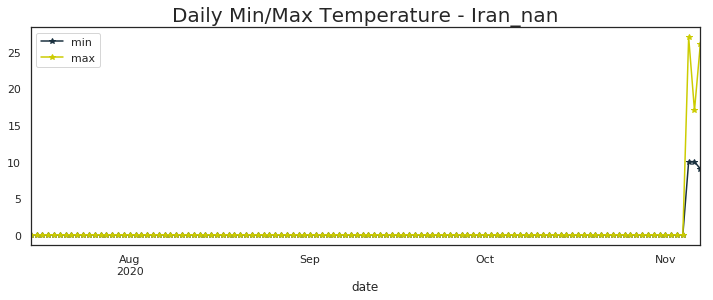

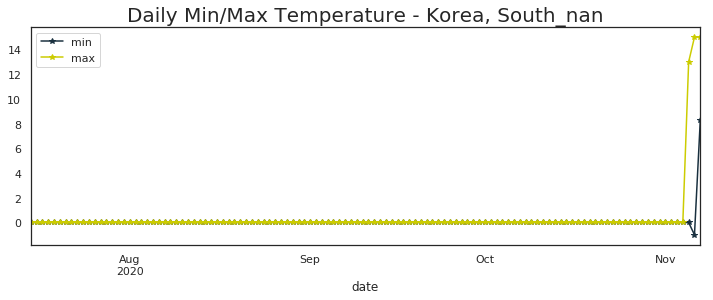

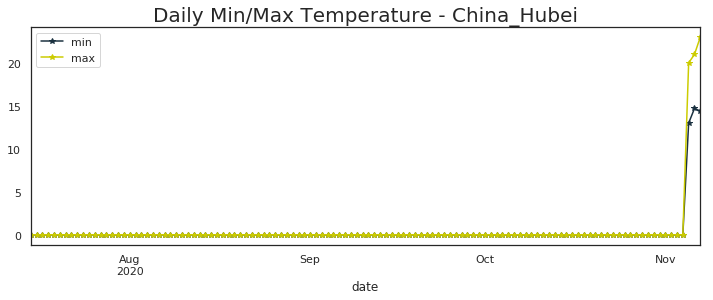

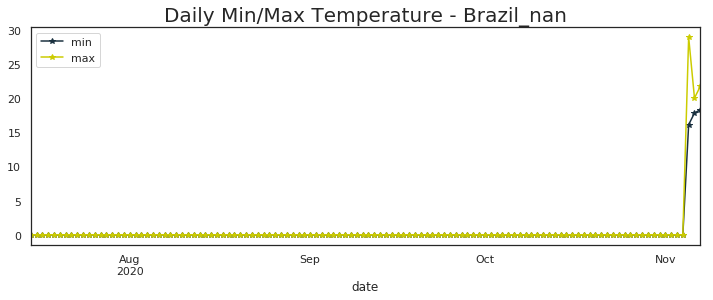

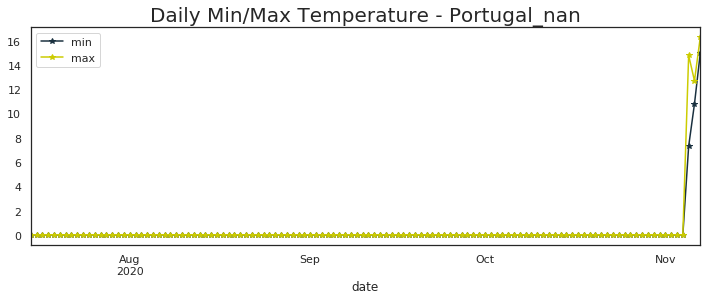

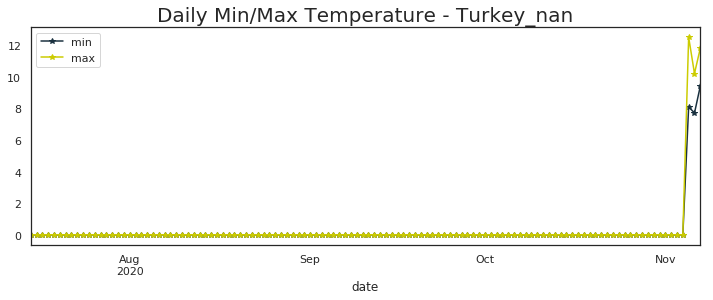

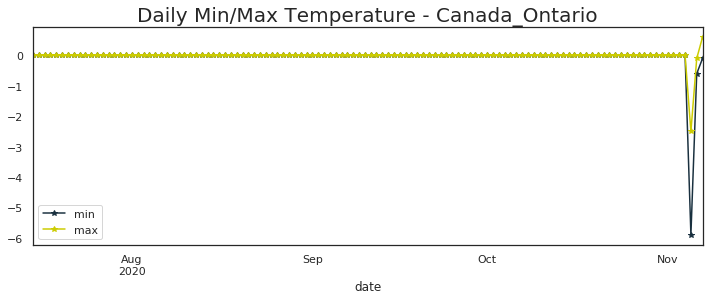

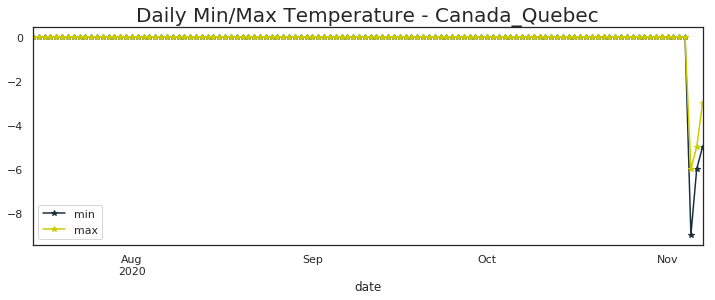

In [59]:
import matplotlib.pyplot as plt
p=train[['date','region','min','max']].set_index('date')
#
#rg1='China_Hubei'
#p=p[p['region']==rg1]
#p.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+rg1,fontdict={'fontsize': 20})
#
## JOAO - Temp. Teast Italy - Data Supply finishes 13/03/2020
region_s=['Italy_nan','Spain_nan','United States_nan','United Kingdom_nan','Germany_nan','Iran_nan',
          'Korea, South_nan','China_Hubei','Brazil_nan','Portugal_nan','Turkey_nan',
          'Canada_Ontario','Canada_Quebec']
p=train[['date','region','min','max']].set_index('date')
for i in range(0,len(region_s)):     
    pv=p[p['region']==region_s[i]]
    pv.iloc[:,:].plot(marker='*',figsize=(12,4),color=['#19303f','#cccc00']).set_title('Daily Min/Max Temperature - '+region_s[i],fontdict={'fontsize': 20})
#

In [60]:
avg_temp=train[['region','confirmed','min','max']]  # from 20-02-20 to 06-04-2020
avg_temp=avg_temp.groupby(by='region').max()
avg_temp=avg_temp.sort_values('confirmed',ascending=False)
print( 'Most infected Areas Avg Temperature')
print(avg_temp.iloc[:100,1:])

Most infected Areas Avg Temperature
                             min   max
region                                
United States_nan           11.0  11.0
India_nan                   14.0  31.0
Brazil_nan                  18.3  28.9
Russia_nan                   0.0   0.0
France_nan                   4.0  10.0
Spain_nan                   10.6  13.1
Argentina_nan                0.0   0.0
United Kingdom_nan           7.8  10.0
Colombia_nan                 0.0   0.0
Mexico_nan                   8.2   9.0
Peru_nan                    24.6  29.9
Italy_nan                   12.2  19.1
South Africa_nan             0.0   0.0
Iran_nan                    10.0  27.0
Germany_nan                  5.0   9.0
Chile_nan                   13.0  20.0
Poland_nan                   8.9  10.6
Iraq_nan                     0.0   0.0
Belgium_nan                  4.8  11.3
Ukraine_nan                  0.0   0.0
Indonesia_nan                0.0   0.0
Bangladesh_nan               0.0   0.0
Czechia_nan                 

### Kalman X Days Ahead Prediction

In [61]:
%%R

#install.packages('reshape')

NULL


In [62]:
%%R

require(pracma)
require(Metrics)
require(readr)
library(reshape)
all<- read_csv("/home/notebookuser/notebooks/covid19/data/ts_conf_r.csv")
all$X1<-NULL

### JOAO - FIX
#
### Flexy Days maximum forward prediction =A Hint!= "Error increases as number of days increases"
days_prediction<-max_days_prediction # Set i days prediction # max_days_prediction=90 days forward prediction with Kalman Filter

for (i in 1: days_prediction) { 
  if( i>1) {all<-all_new}
  date<-all[,1]
  date[nrow(date) + 1,1] <-all[nrow(all),1]+1
  pred_all<-NULL
  for (n in 2:ncol(all)-1) {
    Y<-ts(data = all[n+1], start = 1, end =nrow(all)+1)  
    sig_w<-0.01
    w<-sig_w*randn(1,100) # acceleration which denotes the fluctuation (Q/R) rnorm(100, mean = 0, sd = 1)
    sig_v<-0.01
    v<-sig_v*randn(1,100)  
    t<-0.45
    phi<-matrix(c(1,0,t,1),2,2)
    gama<-matrix(c(0.5*t^2,t),2,1)
    H<-matrix(c(1,0),1,2)
    #Kalman
    x0_0<-p0_0<-matrix(c(0,0),2,1)
    p0_0<-matrix(c(1,0,0,1),2,2)
    Q<-0.01
    R<-0.01
    X<-NULL
    X2<-NULL
    pred<-NULL
    for (i in 0:nrow(all)) {
      namp <-paste("p", i+1,"_",i, sep = "")
      assign(namp, phi%*%(get(paste("p", i,"_",i, sep = "")))%*%t(phi)+gama%*%Q%*%t(gama))
      namk <- paste("k", i+1, sep = "")
      assign(namk,get(paste("p", i+1,"_",i, sep = ""))%*%t(H)%*%(1/(H%*%get(paste("p", i+1,"_",i, sep = ""))%*%t(H)+R)))
      namx <- paste("x", i+1,"_",i, sep = "")
      assign(namx,phi%*%get(paste("x", i,"_",i, sep = "")))
      namE <- paste("E", i+1, sep = "")
      assign(namE,Y[i+1]-H%*%get(paste("x", i+1,"_",i, sep = "")))
      namx2 <- paste("x", i+1,"_",i+1, sep = "")
      assign(namx2,get(paste("x", i+1,"_",i, sep = ""))+get(paste("k", i+1, sep = ""))%*%get(paste("E", i+1, sep = "")))
      namp2 <- paste("p", i+1,"_",i+1, sep = "")
      assign(namp2,(p0_0-get(paste("k", i+1, sep = ""))%*%H)%*%get(paste("p", i+1,"_",i, sep = "")))
      X<-rbind(X,get(paste("x", i+1,"_",i,sep = ""))[1])
      X2<-rbind(X2,get(paste("x", i+1,"_",i,sep = ""))[2])
      if(i>2){
        remove(list=(paste("p", i-1,"_",i-2, sep = "")))
        remove(list=(paste("k", i-1, sep = "")))
        remove(list=(paste("E", i-1, sep = "")))
        remove(list=(paste("p", i-2,"_",i-2, sep = "")))
        remove(list=(paste("x", i-1,"_",i-2, sep = "")))
        remove(list=(paste("x", i-2,"_",i-2, sep = "")))}
    } 
    pred<-NULL
    pred<-cbind(Y,X,round(X2,4))
    pred<-as.data.frame(pred)
    pred$region<-colnames(all[,n+1])
    pred$date<-date$date
    pred$actual<-rbind(0,(cbind(pred[2:nrow(pred),1])/pred[1:nrow(pred)-1,1]-1)*100)
    pred$predict<-rbind(0,(cbind(pred[2:nrow(pred),2])/pred[1:nrow(pred)-1,2]-1)*100)
    pred$pred_rate<-(pred$X/pred$Y-1)*100
    pred$X2_change<-rbind(0,(cbind(pred[2:nrow(pred),3]-pred[1:nrow(pred)-1,3])))
    pred_all<-rbind(pred_all,pred)
  }
  pred_all<-cbind(pred_all[,4:5],pred_all[,1:3])
  names(pred_all)[5]<-"X2"
  pred_all<-pred_all[,1:5]
       
pred_all_today=pred_all[with( pred_all, order(region, date)), ]
all_new=all
#all_new[nrow(all_new),1]<-all_new[nrow(all),1]+1
temp<-with(pred_all_today, pred_all_today[date == all[nrow(all),1]+1, ])
temp<-cbind(temp[,1:2],temp[,4])
temp2<-reshape(temp, direction = "wide", idvar = "date", timevar = "region")
rand_num<-runif(ncol(temp2)-1, 0.9, 1.05)
temp2[,2:ncol(temp2)]<-temp2[,2:ncol(temp2)]*rand_num
colnames(temp2)=colnames(all_new)
all_new<-rbind(all_new,temp2)
all_new[,2:ncol(all_new)]<-round(all_new[,2:ncol(all_new)])
for (i in 2:ncol(all_new)) {
  all_new[nrow(all_new),i]=max(all_new[nrow(all_new)-1,i],all_new[nrow(all_new),i])}
}

── Column specification ────────────────────────────────────────────────────────
cols(
  .default = col_double(),
  date = col_date(format = "")
)
ℹ Use `spec()` for the full column specifications.




In [63]:
all_new=%R all_new

In [64]:
all_new['date']=pd.to_datetime(all_new['date'],unit='d')

Text(0.5, 1.0, 'Kalman Prediction - Select Country/Region to Change - Spain_nan')

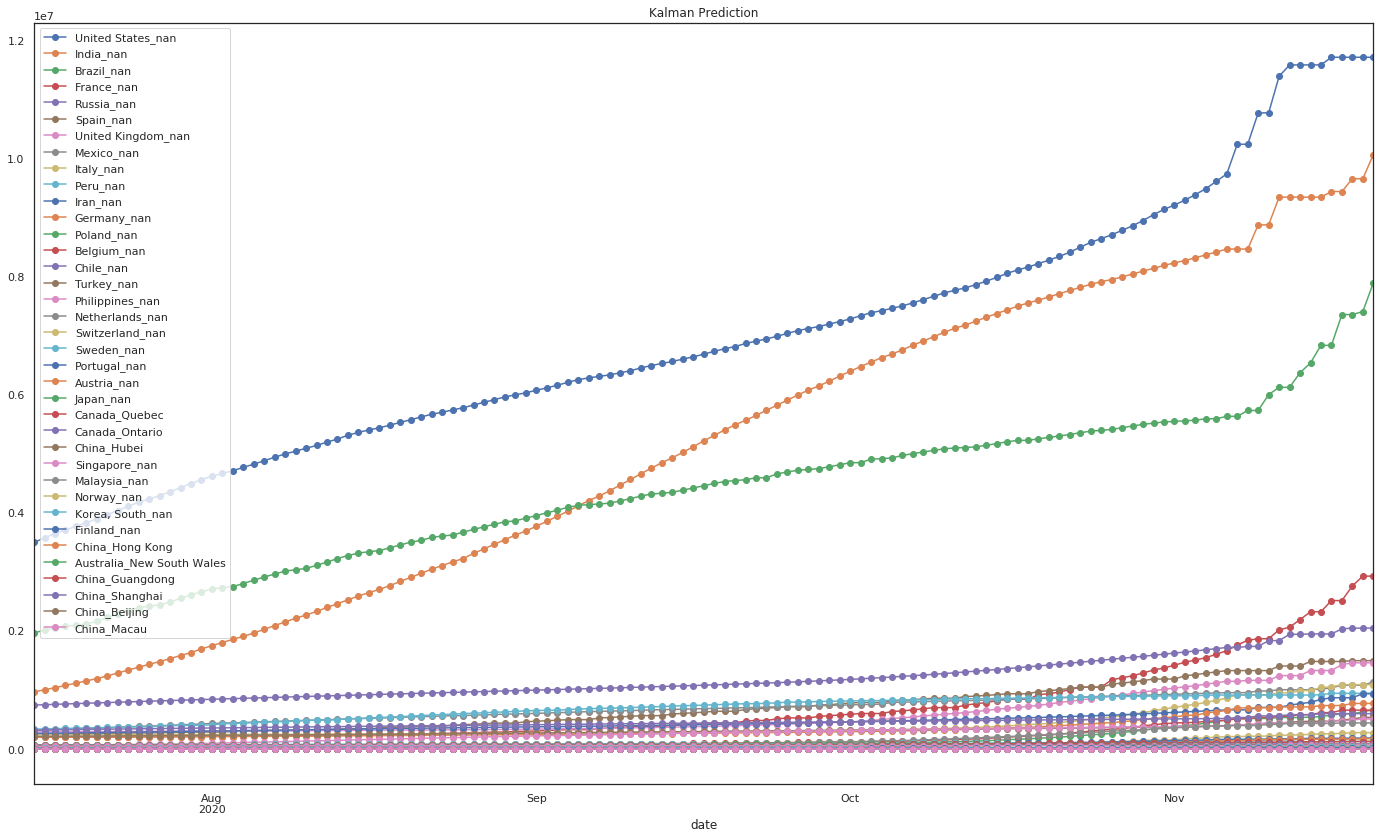

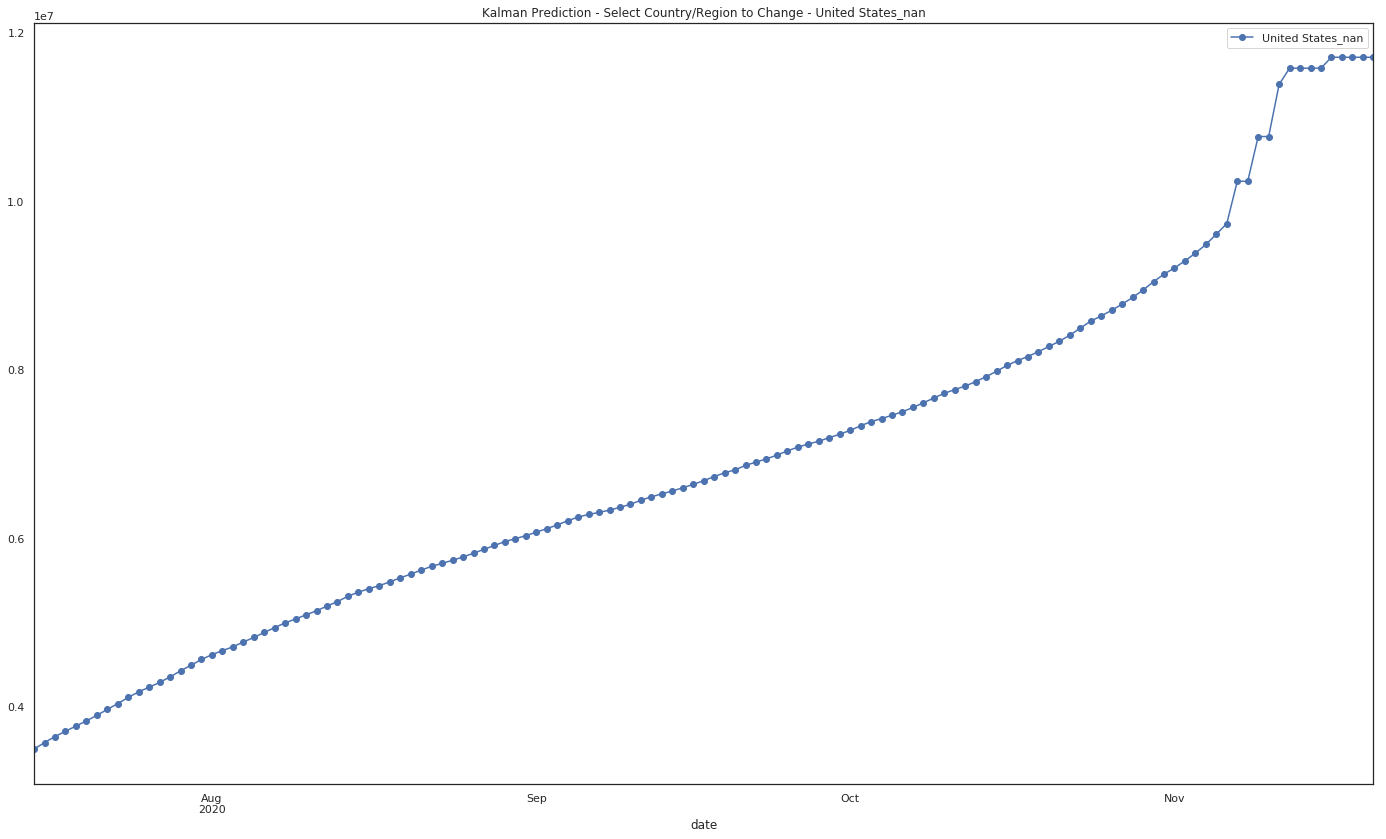

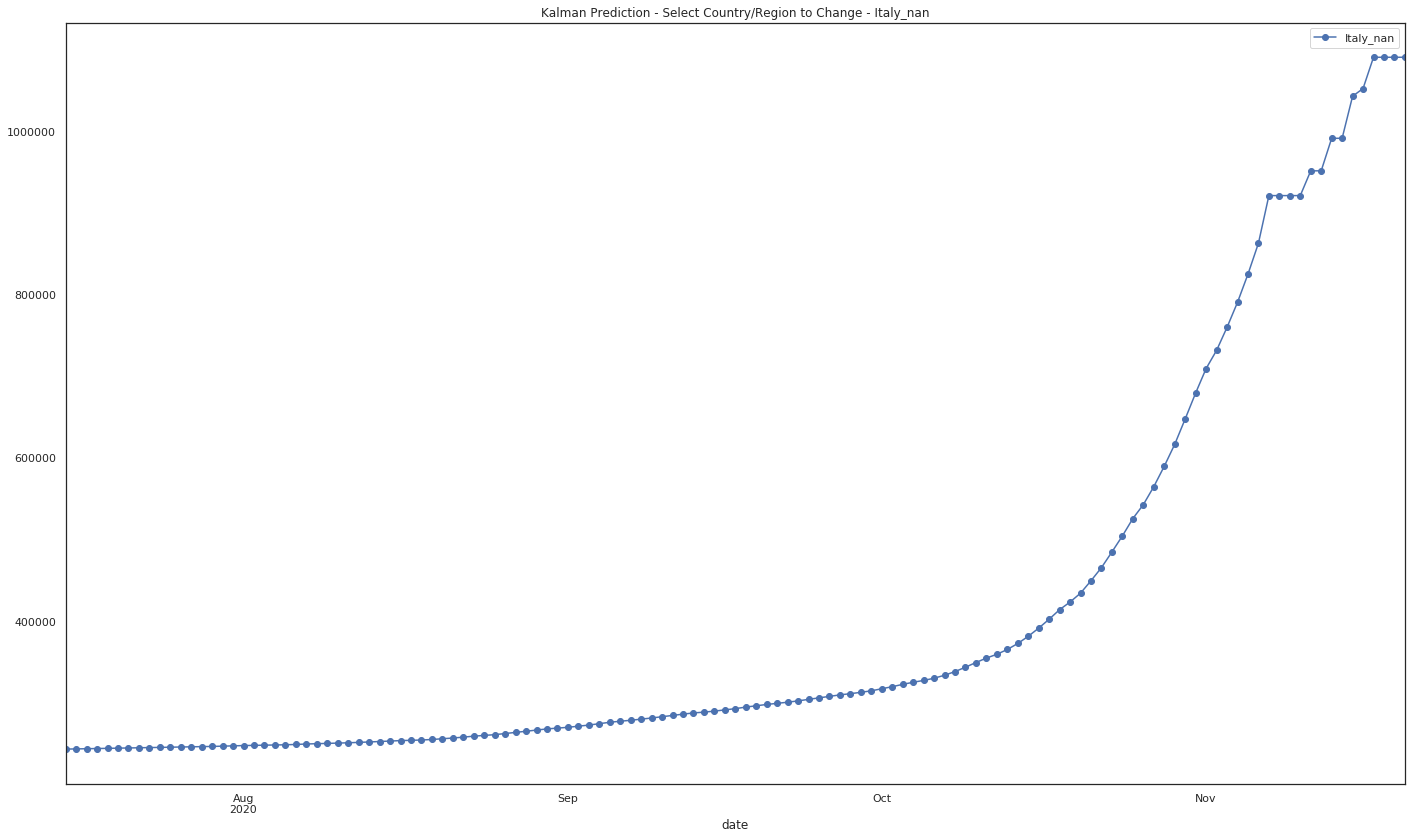

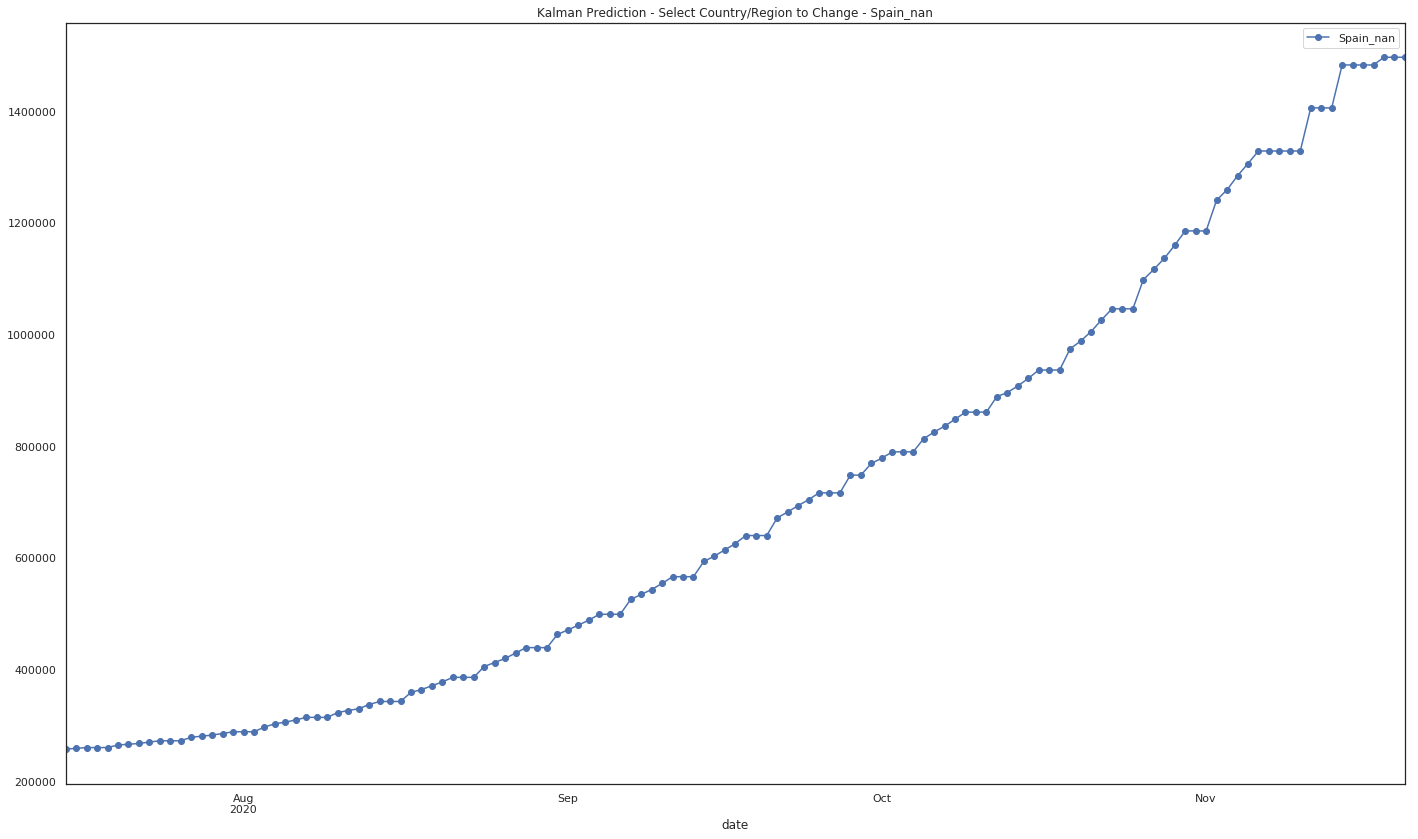

In [65]:
#
### Joao - Moving Forward ...
# Select regions From my_train_list
#
region=['date']+my_train_list
p_kalman=all_new[region]
#p=all_new
#p.iloc[len(p)-1,2]=None
p_kalman=p_kalman.set_index(['date'])
p_kalman=p_kalman.reindex(p_kalman.max().sort_values(ascending=False).index, axis=1)
p_kalman.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction')
#
p_kalman2=all_new[['date','United States_nan']] ## Joao
p_kalman2=p_kalman2.set_index(['date'])
p_kalman2.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman2.columns[0]))
#
p_kalman3=all_new[['date','Italy_nan']] ## Joao
p_kalman3=p_kalman3.set_index(['date'])
p_kalman3.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman3.columns[0]))
#
p_kalman4=all_new[['date','Spain_nan']] ## Joao
p_kalman4=p_kalman4.set_index(['date'])
p_kalman4.iloc[:,:].plot(marker='o',figsize=(24,14)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman4.columns[0]))
#

/home/notebookuser/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


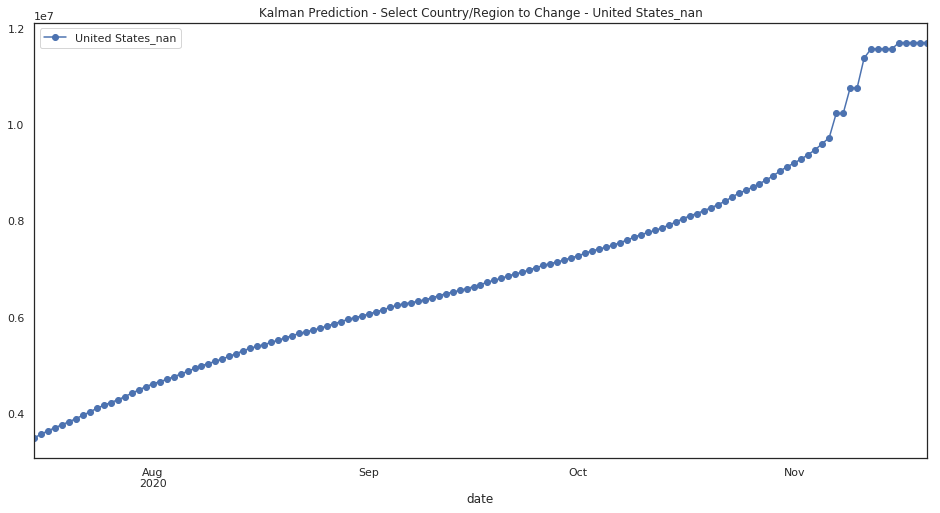

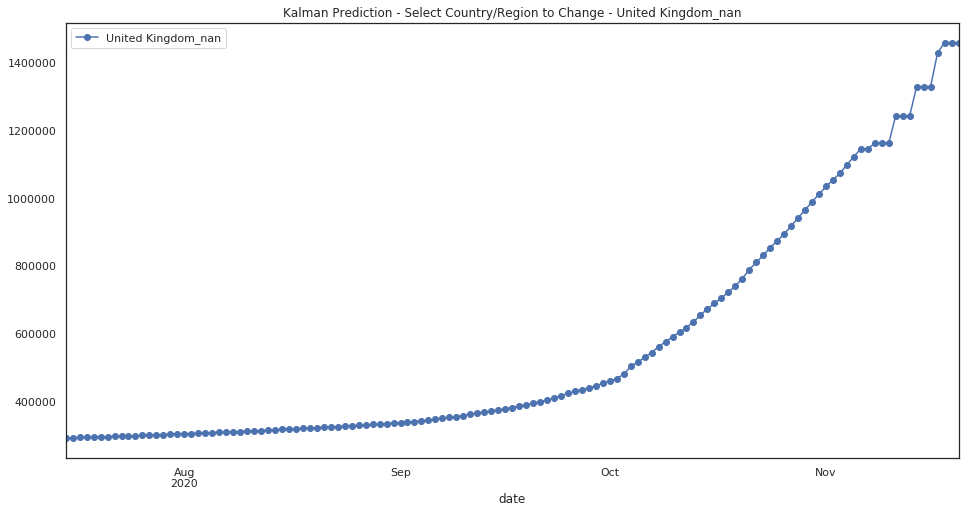

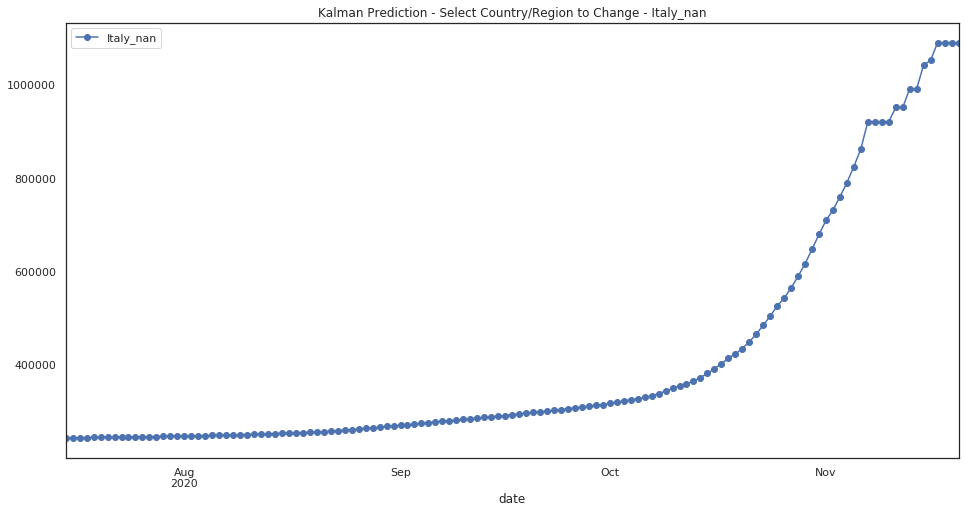

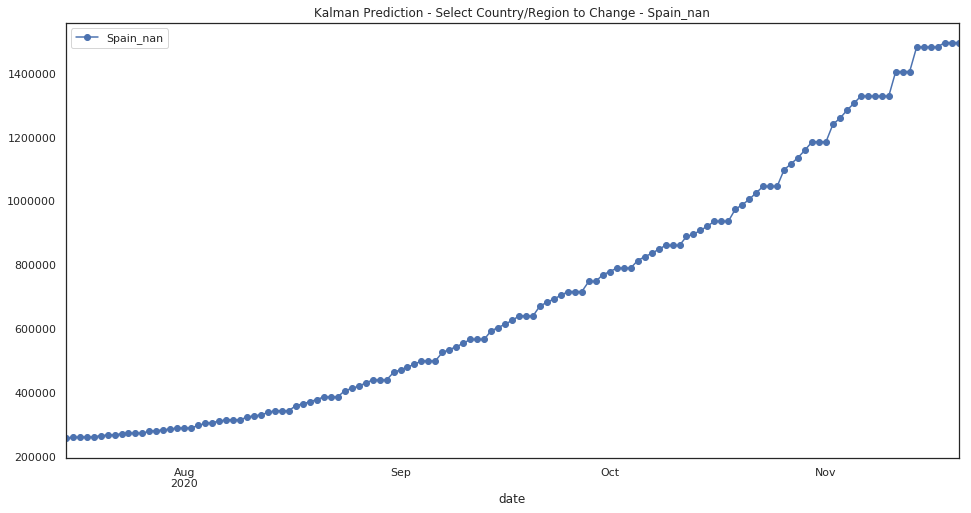

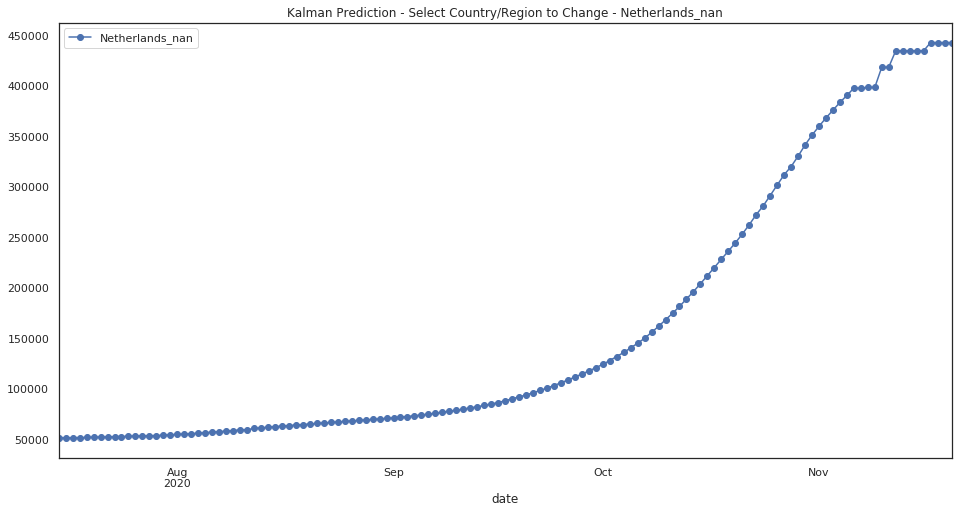

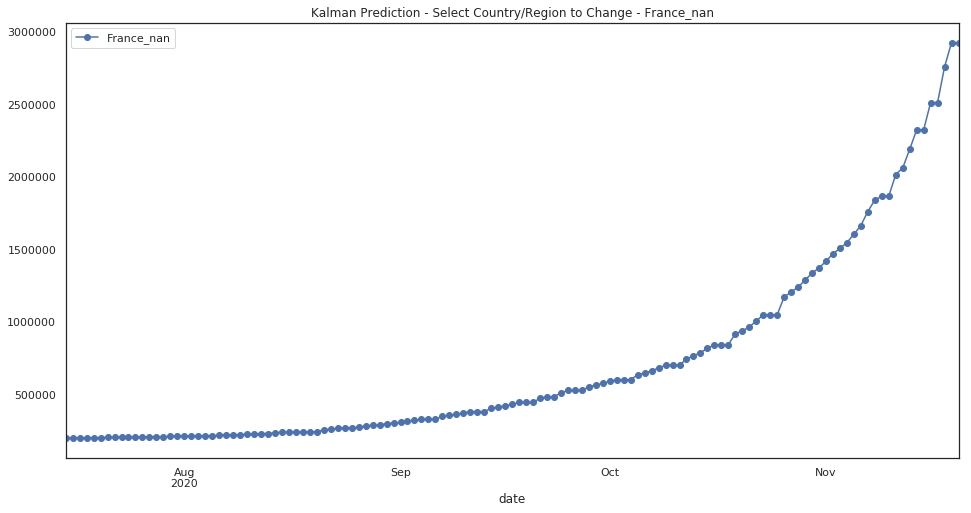

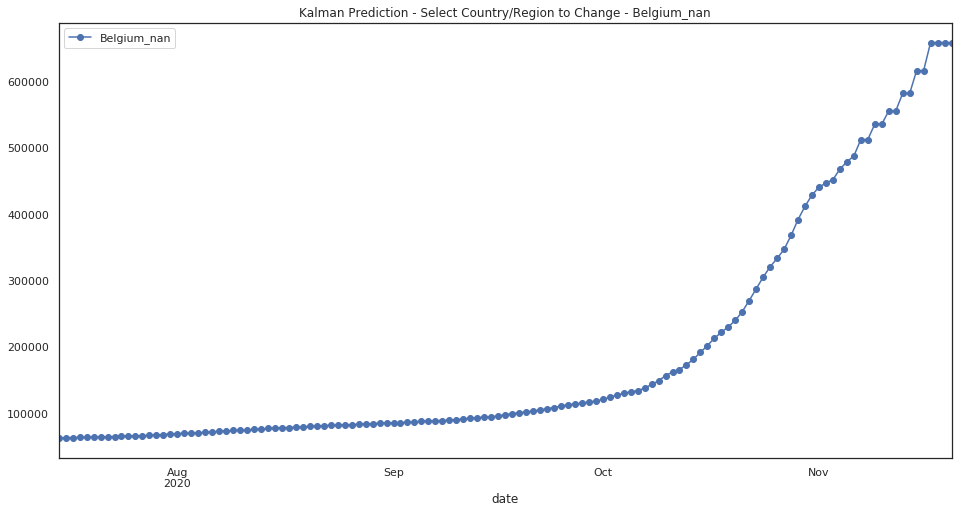

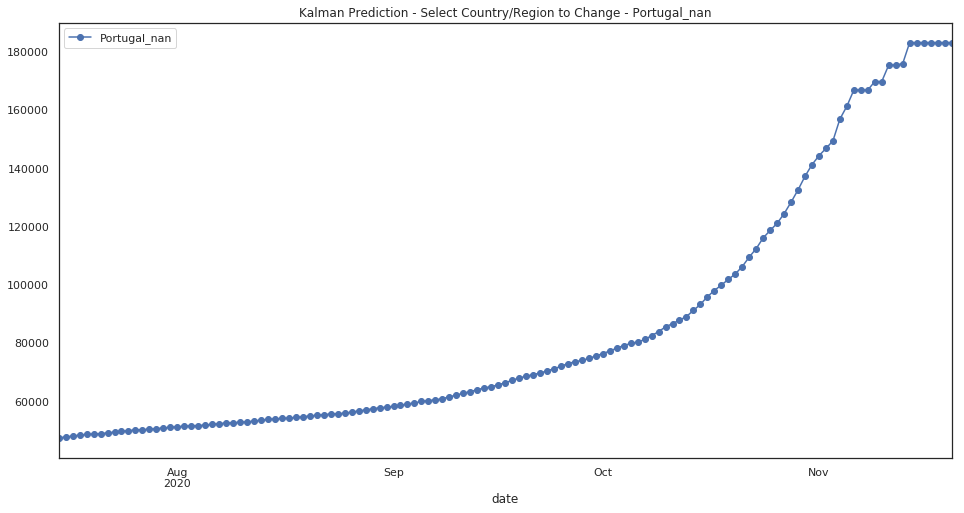

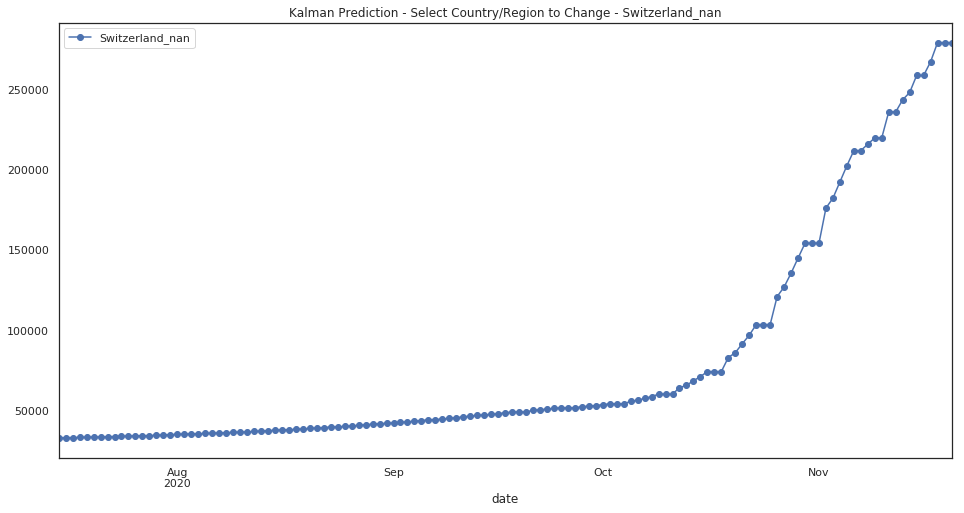

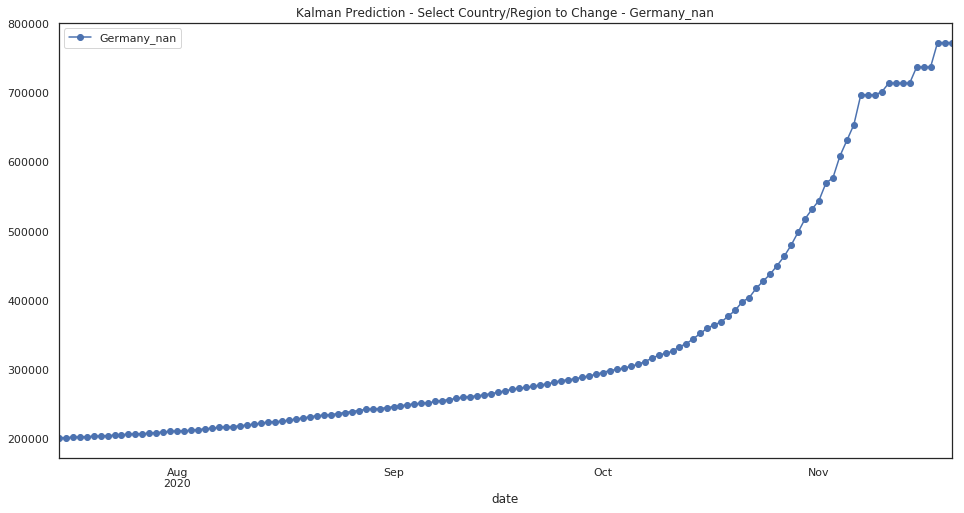

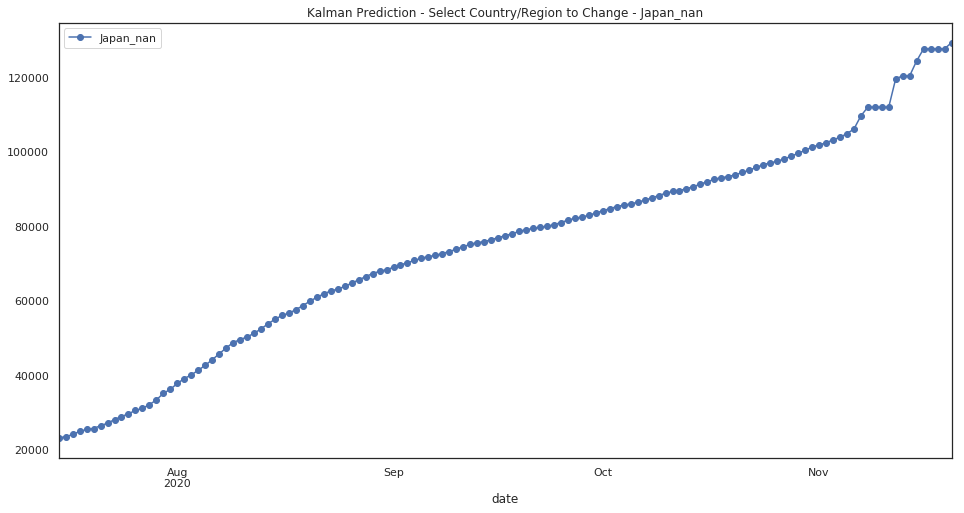

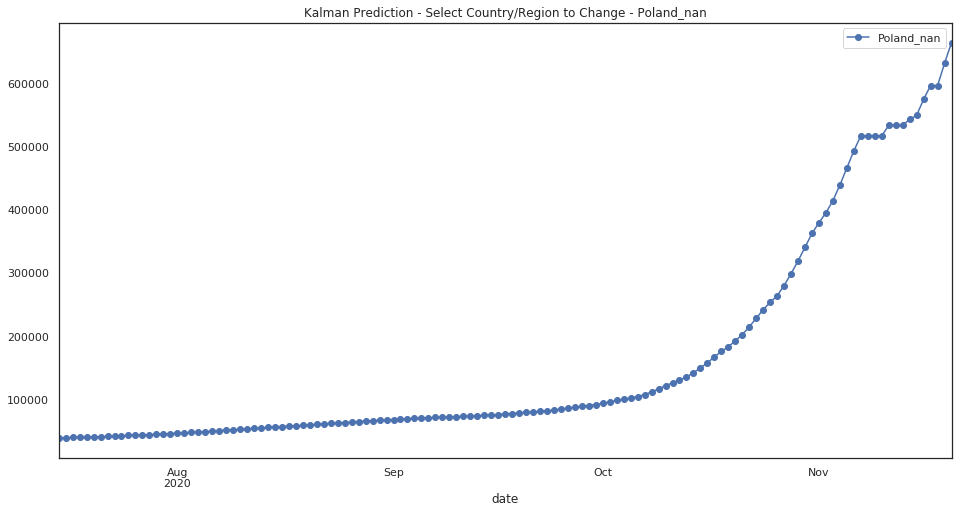

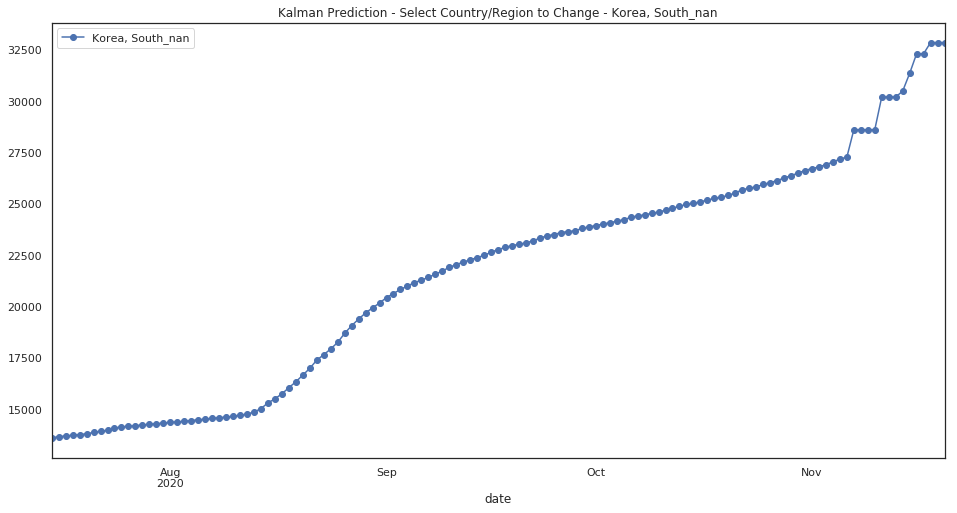

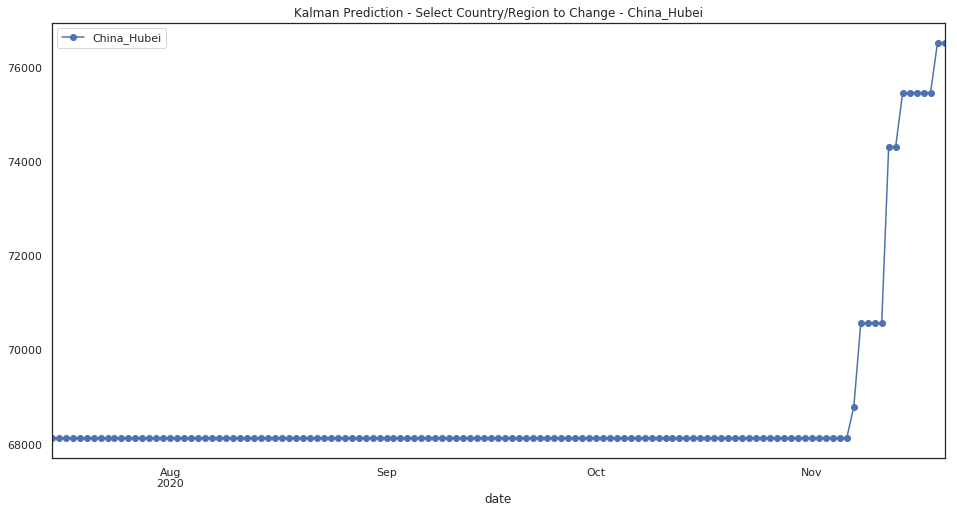

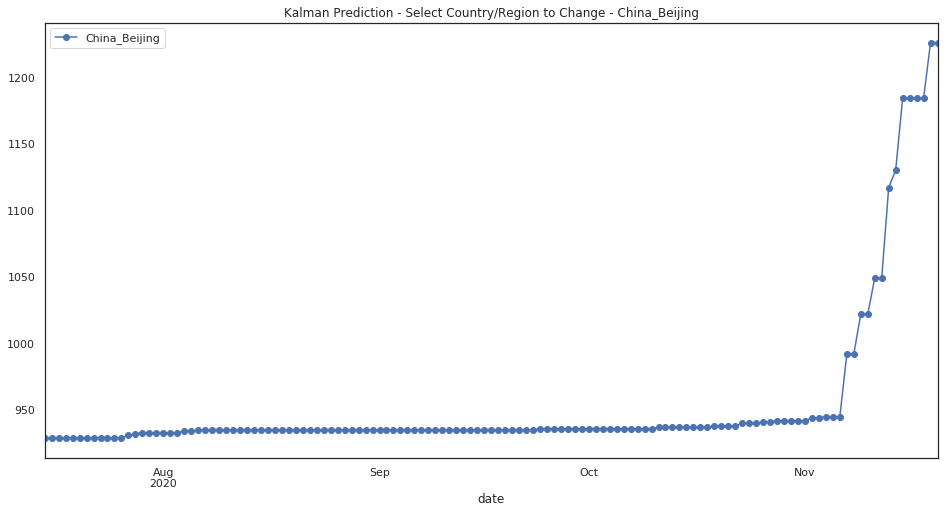

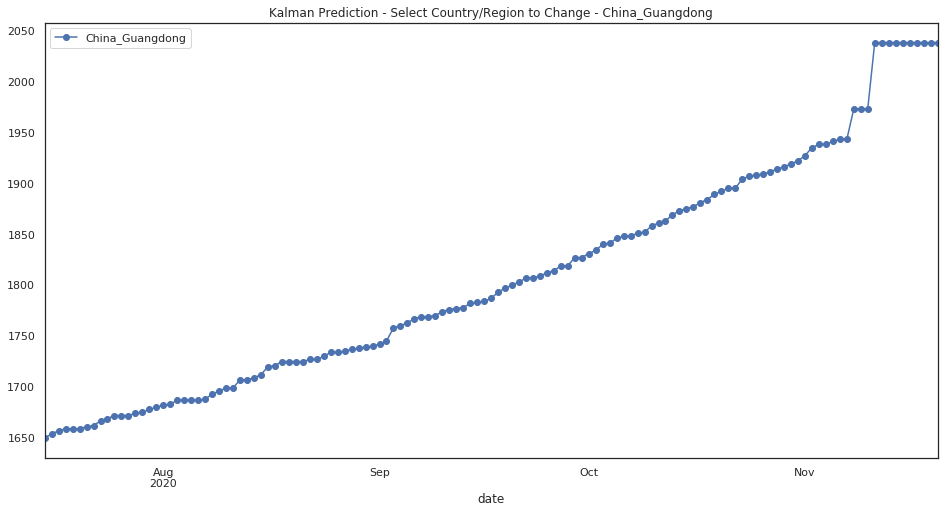

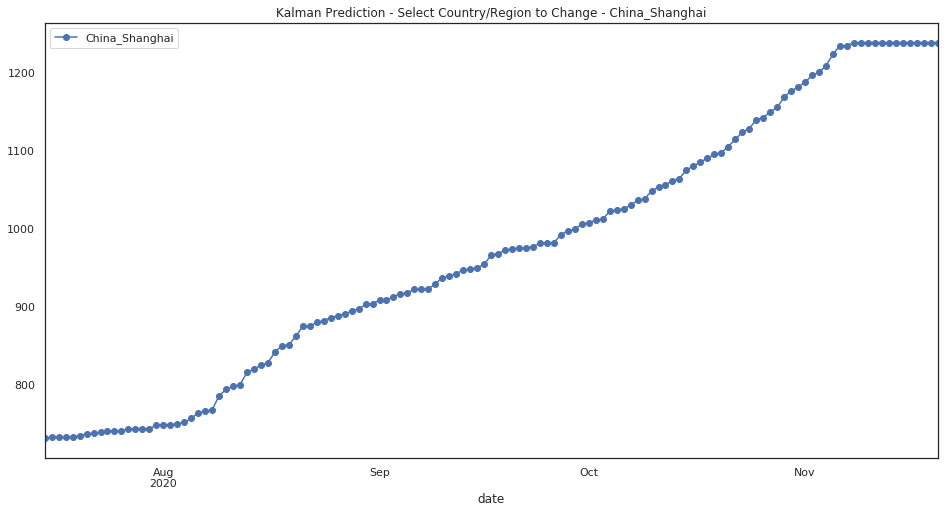

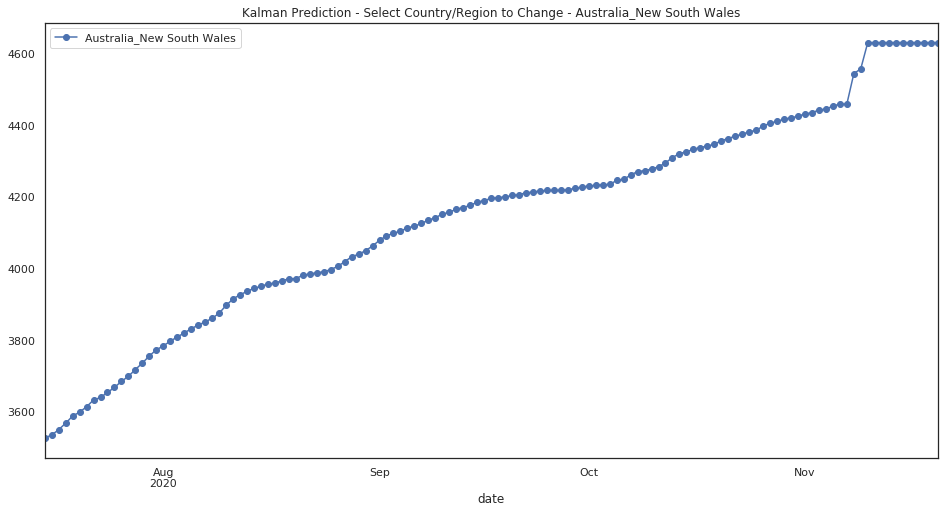

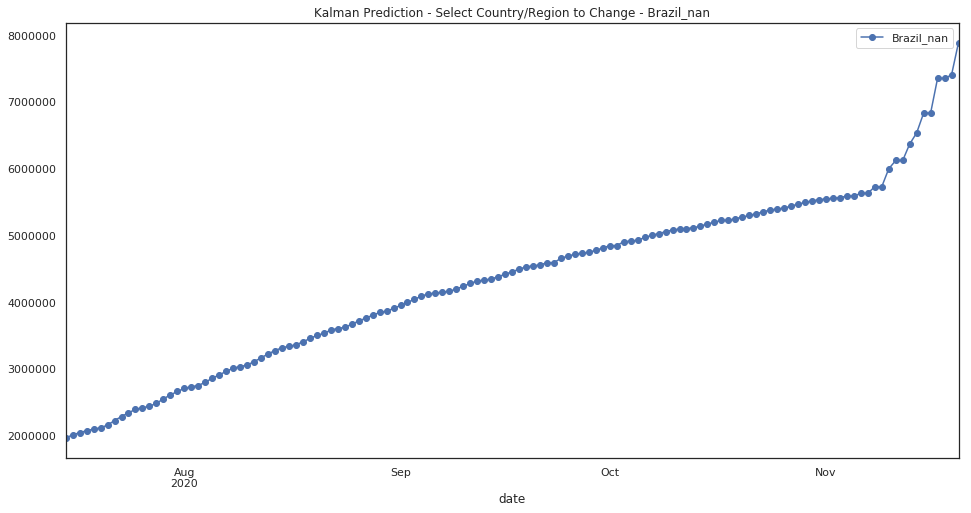

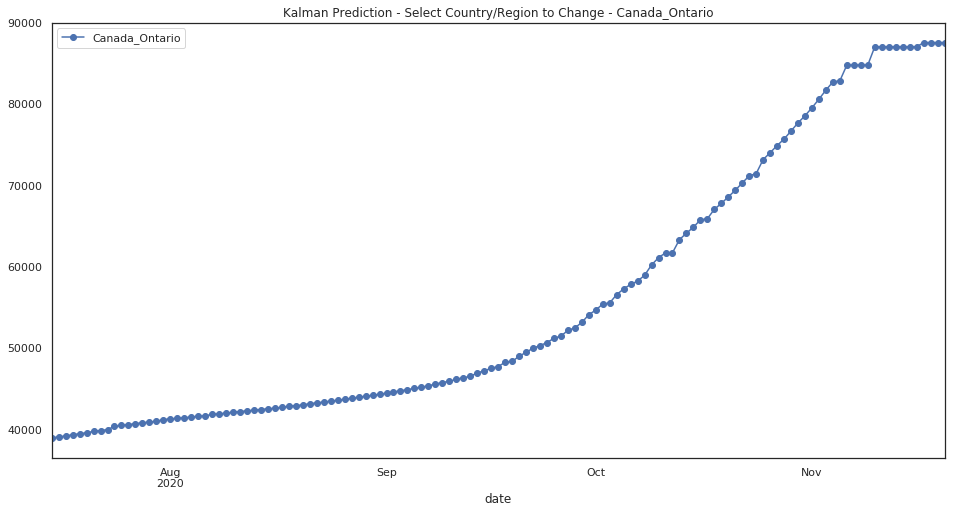

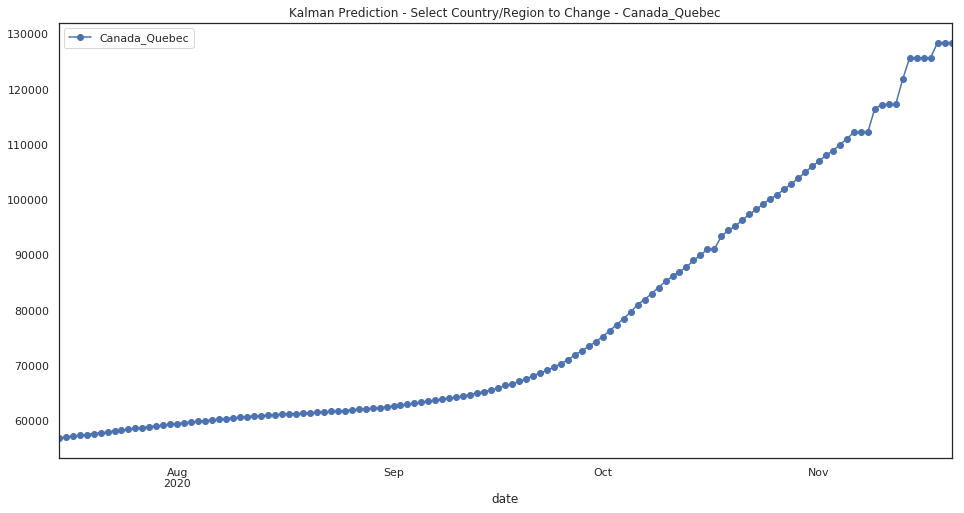

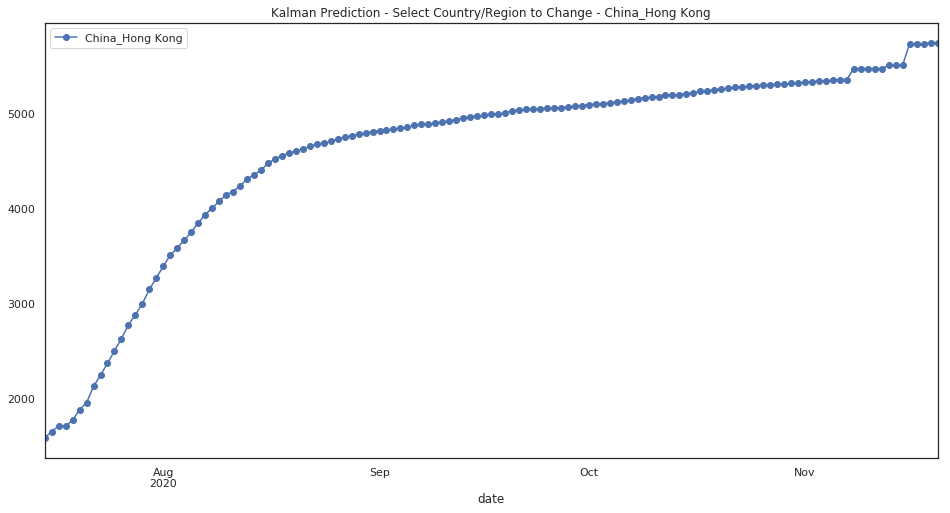

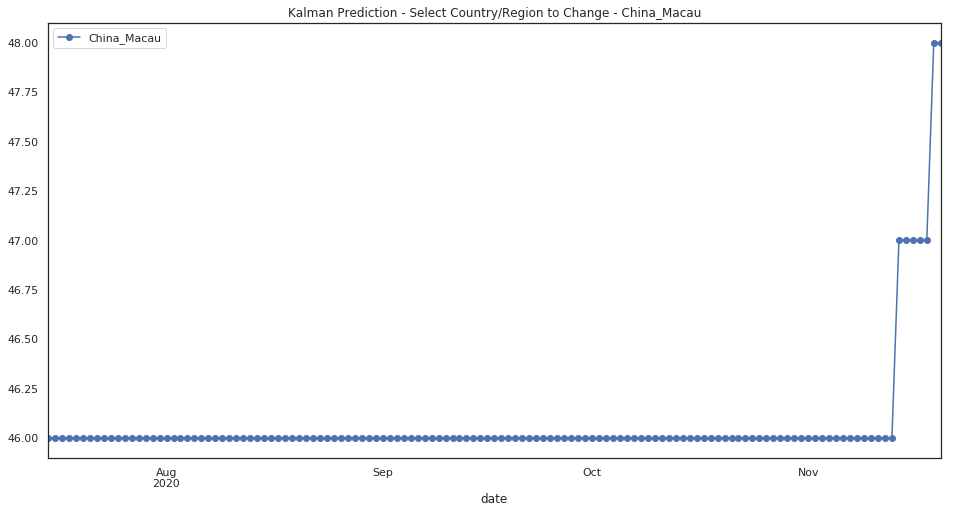

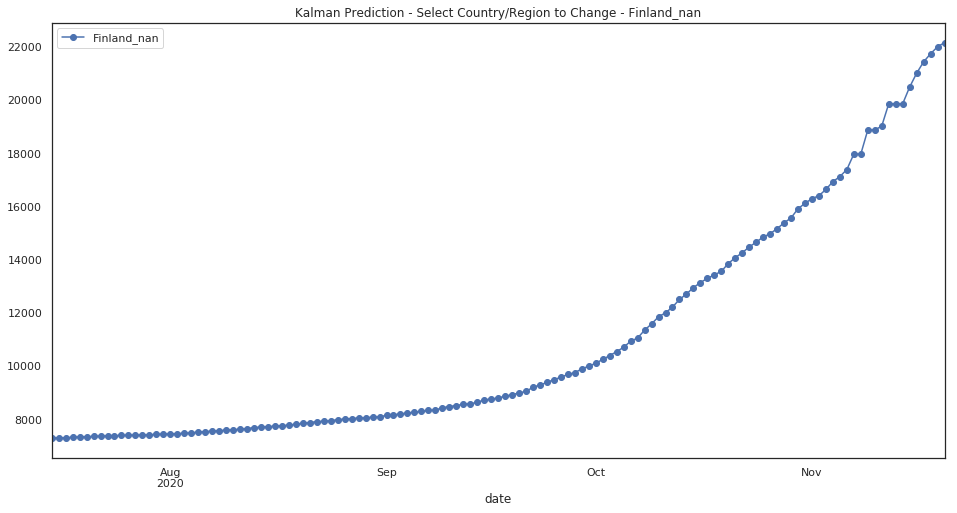

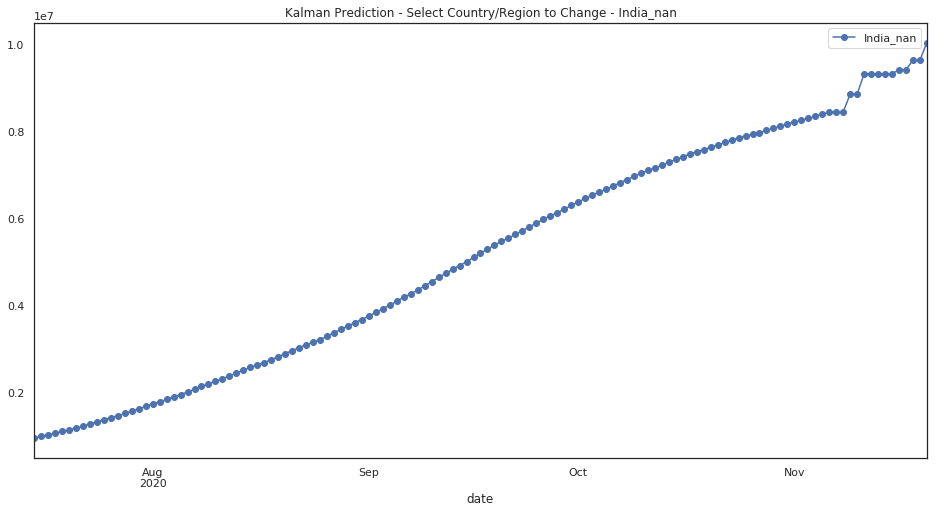

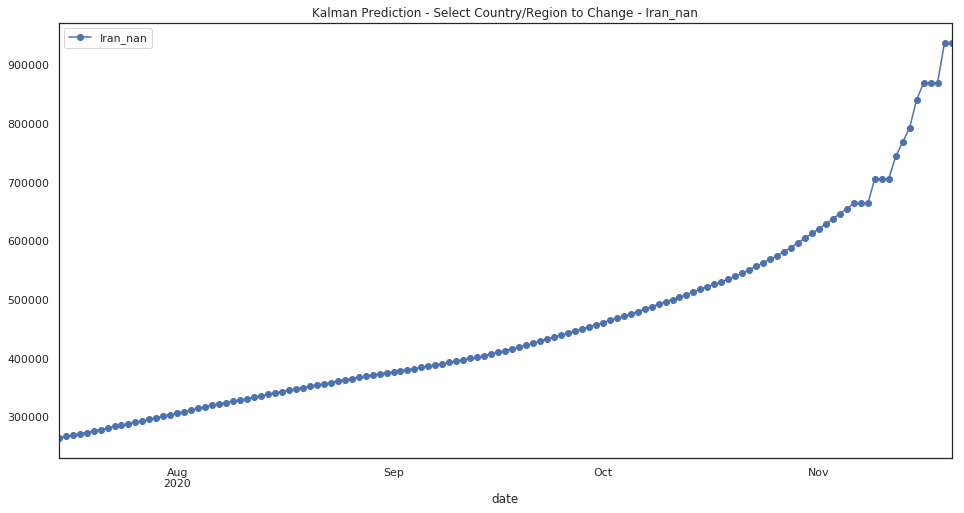

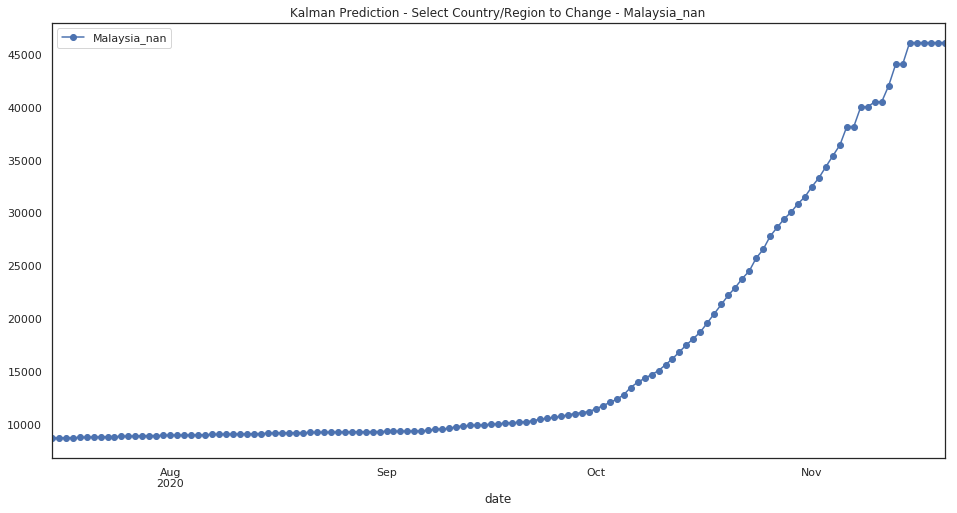

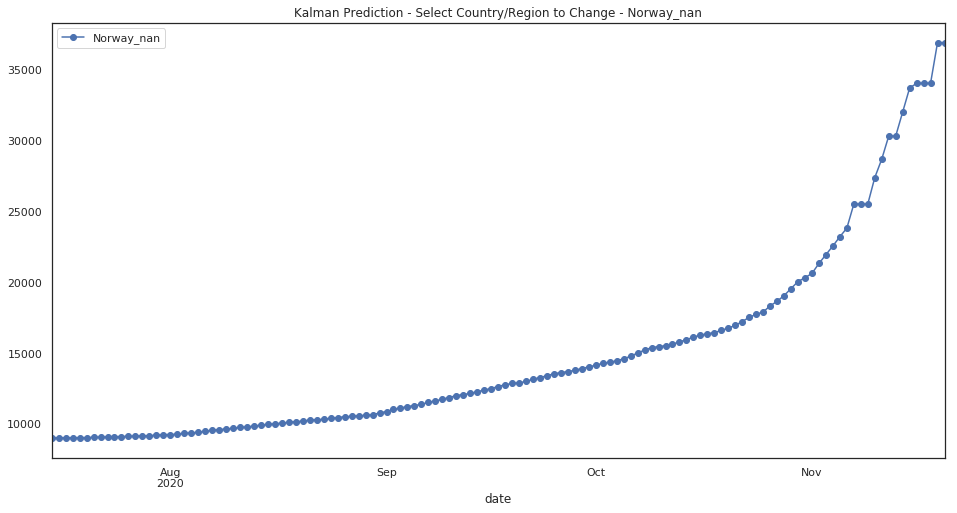

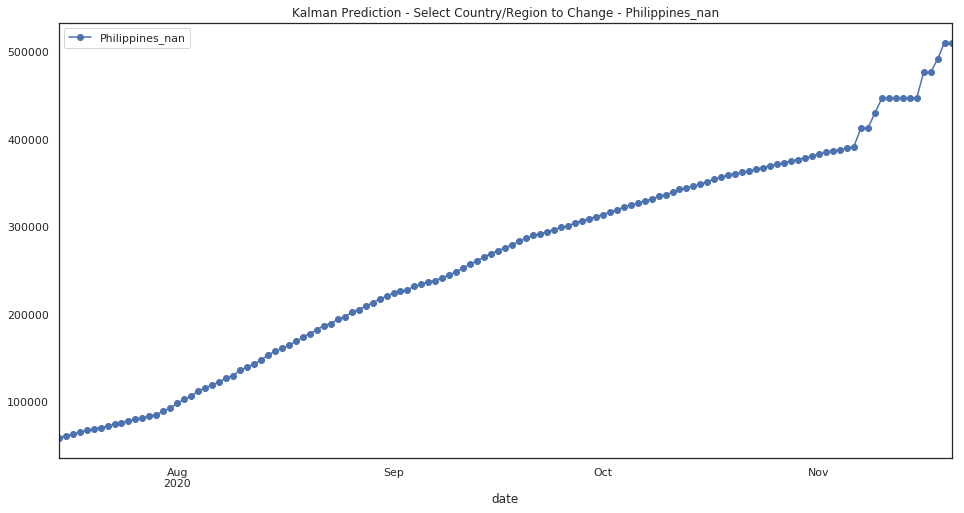

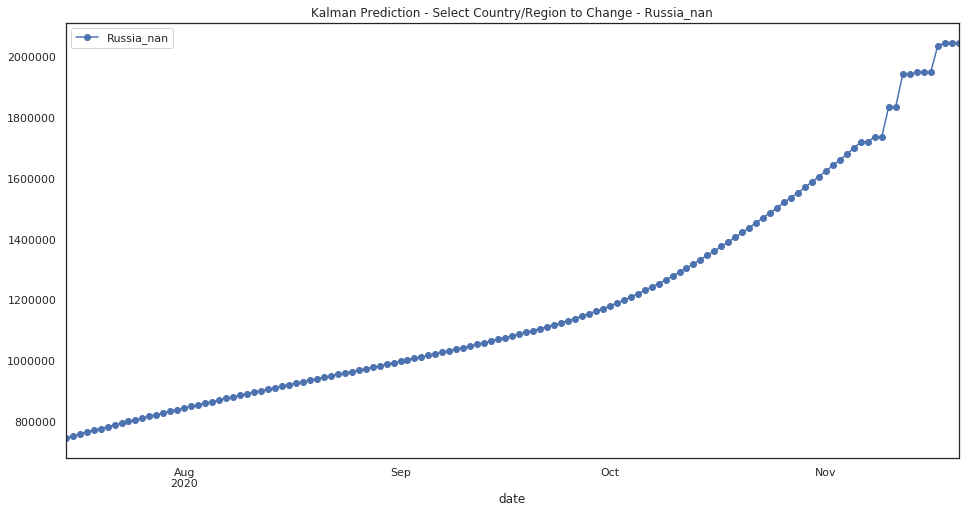

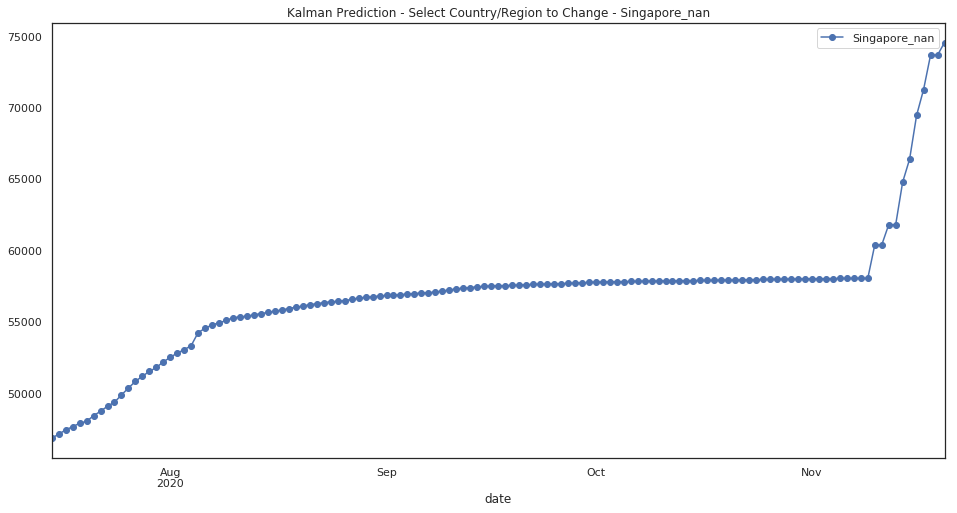

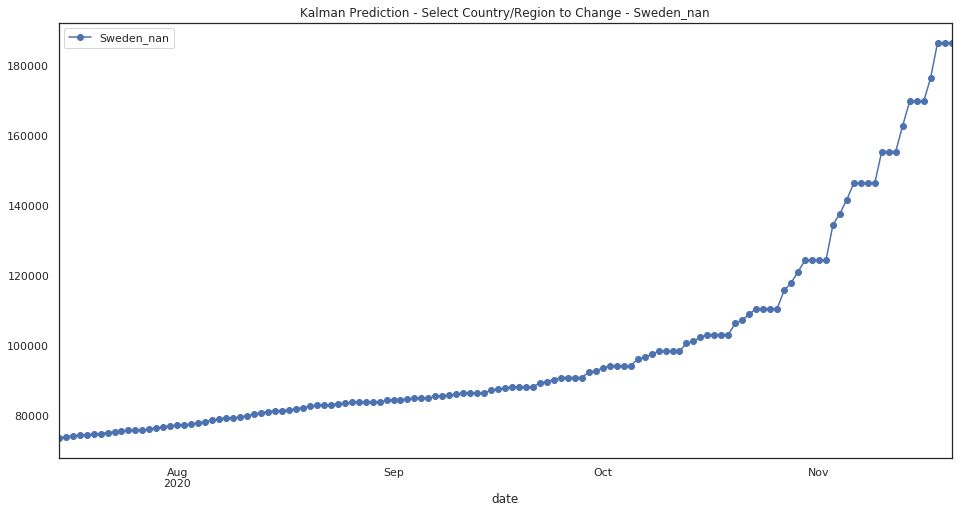

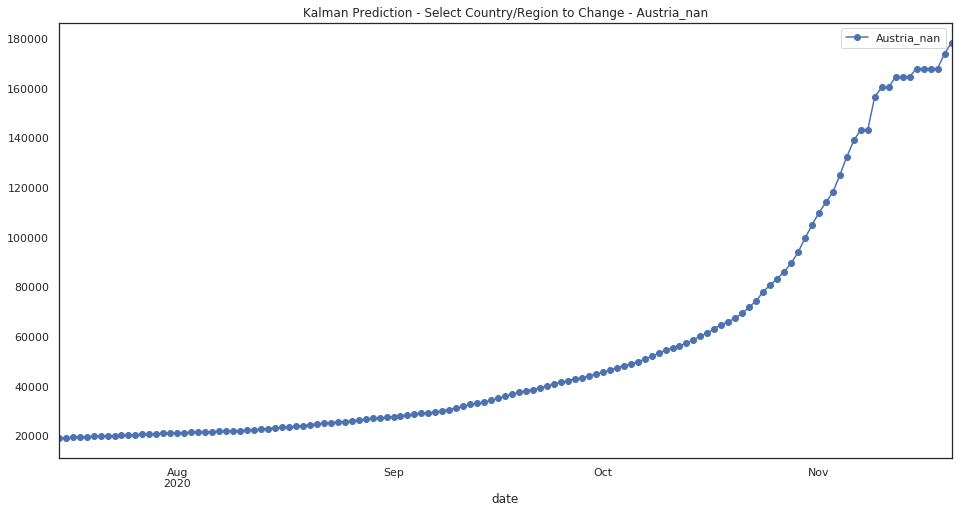

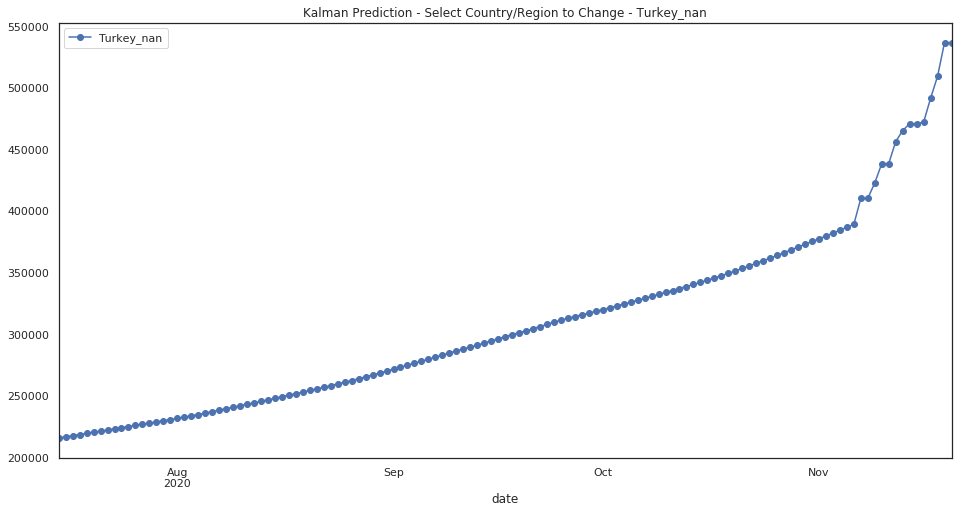

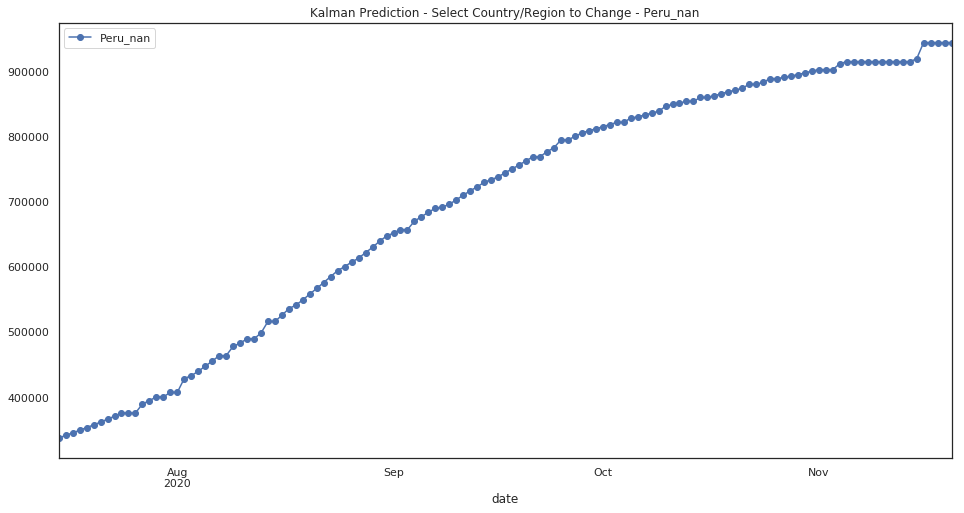

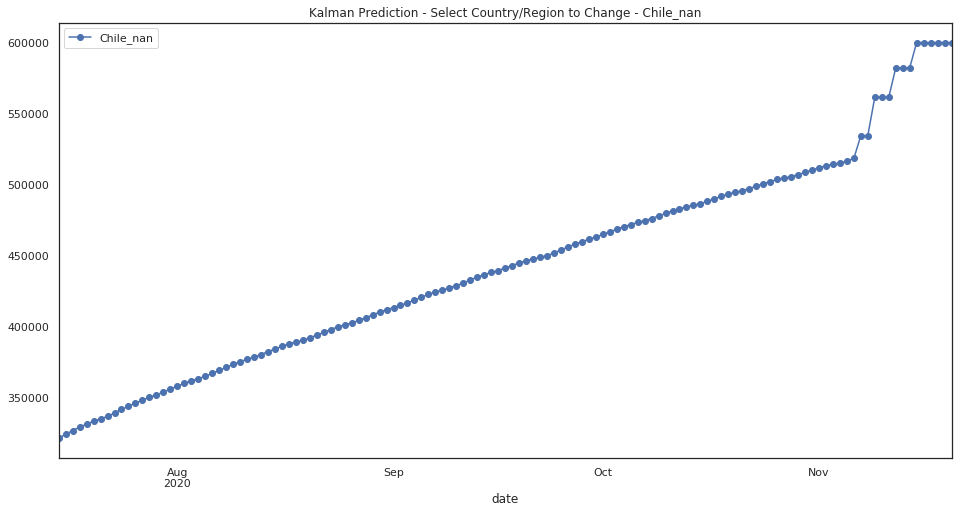

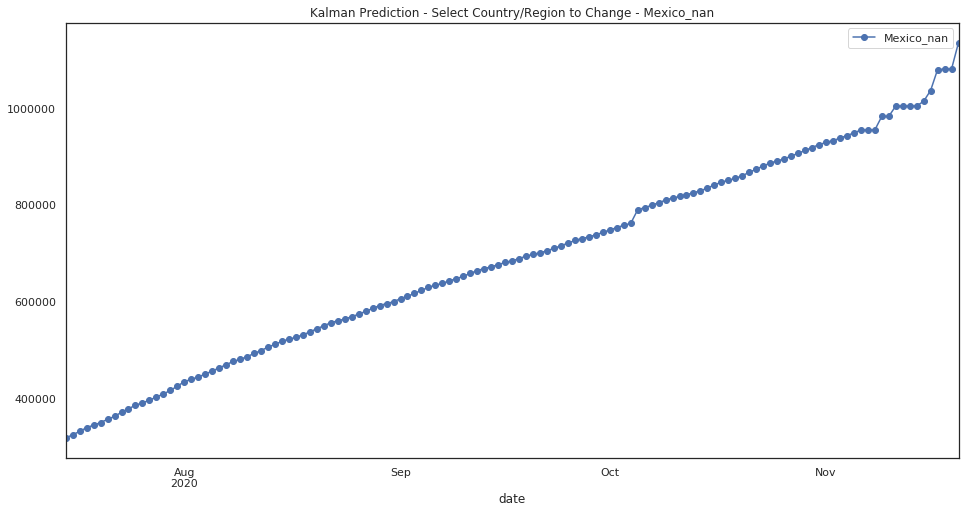

In [66]:
### Joao - Dynamic plot all regions individually
#print(region[:])
for i in range(1,len(region)):
    country_print=region[i]
    #print("here:"+country_print)
    p_kalman_rg=all_new[['date',country_print]]
    p_kalman_rg=p_kalman_rg.set_index(['date'])
    p_kalman_rg.iloc[:,:].plot(marker='o',figsize=(16,8)).set_title('Kalman Prediction - Select Country/Region to Change - {}'.format(p_kalman_rg.columns[0]))
    

In [67]:
max_p0=all_new[:]
max_p0=max_p0.max()
max_date=max_p0[:1]
max_p0=max_p0[1:]
max_p0=pd.DataFrame(max_p0)
max_p0=max_p0.astype(str)
max_p0['pred_confirmed']=max_p0[max_p0.columns[0]].str.split(' ').str[-1].astype(float)
max_p0[max_p0.columns[0]]=max_p0[max_p0.columns[0]][:-len(max_p0['pred_confirmed'])]
max_p0=max_p0.sort_values(by='pred_confirmed', ascending=False)
#
print("### -- Confirmed max cases per country at last prediction date -- ###")
print(max_date)
max_p0[:]

### -- Confirmed max cases per country at last prediction date -- ###
date    2020-11-20 00:00:00
dtype: object


0  pred_confirmed
United States_nan                           NaN      11707433.0
India_nan                                   NaN      10057620.0
Brazil_nan                                  NaN       7888340.0
France_nan                                  NaN       2927462.0
Russia_nan                                  NaN       2047414.0
Spain_nan                                   NaN       1496794.0
United Kingdom_nan                          NaN       1460011.0
Argentina_nan                               NaN       1317009.0
Colombia_nan                                NaN       1182620.0
Mexico_nan                                  NaN       1136153.0
Italy_nan                                   NaN       1090409.0
Peru_nan                                    NaN        943929.0
Iran_nan                                    NaN        937682.0
South Africa_nan                            NaN        825768.0
Germany_nan                                 NaN        772813.0
Poland_nan                                  NaN        665263.0
Belgium_nan                                 NaN        659159.0
Iraq_nan                                    NaN        631393.0
Chile_nan                                   NaN        600162.0
Ukraine_nan                                 NaN        573338.0
Turkey_nan                                  NaN        536662.0
Philippines_nan                             NaN        510595.0
Bangladesh_nan                              NaN        507498.0
Indonesia_nan                               NaN        463425.0
Czechia_nan                                 NaN        458215.0
Netherlands_nan                             NaN        442824.0
Saudi Arabia_nan                            NaN        414229.0
Pakistan_nan                                NaN        349747.0
Israel_nan                                  NaN        338640.0
Romania_nan                                 NaN        314055.0
...                                         ...             ...
France_Saint Barthelemy                     NaN           131.0
Saint Vincent and the Grenadines_nan        NaN            96.0
United Kingdom_British Virgin Islands       NaN            93.0
Canada_Prince Edward Island                 NaN            82.0
Dominica_nan                                NaN            81.0
China_Ningxia                               NaN            80.0
China_Macau                                 NaN            48.0
Australia_Northern Territory                NaN            46.0
Fiji_nan                                    NaN            45.0
Holy See_nan                                NaN            36.0
Grenada_nan                                 NaN            35.0
Timor-Leste_nan                             NaN            33.0
France_New Caledonia                        NaN            31.0
Laos_nan                                    NaN            29.0
Canada_Yukon                                NaN            26.0
Denmark_Greenland                           NaN            21.0
Saint Kitts and Nevis_nan                   NaN            19.0
China_Qinghai                               NaN            19.0
Solomon Islands_nan                         NaN            17.0
France_Saint Pierre and Miquelon            NaN            16.0
United Kingdom_Montserrat                   NaN            14.0
United Kingdom_Falkland Islands (Malvinas)  NaN            14.0
Canada_Grand Princess                       NaN            13.0
Canada_Northwest Territories                NaN            10.0
Western Sahara_nan                          NaN            10.0
MS Zaandam_nan                              NaN             9.0
United Kingdom_Anguilla                     NaN             3.0
Marshall Islands_nan                        NaN             2.0
China_Tibet                                 NaN             1.0
Canada_Diamond Princess                     NaN             0.0

[268 rows x 2 columns]

In [68]:
t.to_csv(r'data/t_confirmed_global.csv', index = False, header=True)

In [69]:
all_new.to_csv(r'data/prediction_kalman_filter_global.csv', index = False, header=True)

## Iterative Regression

In [70]:
t_iter=all_new.set_index(['date'])
t_iter=t_iter.stack().reset_index(name='confirmed')
t_iter.columns=['date', 'region','confirmed']
t_iter['date']=pd.to_datetime(t_iter['date'] ,errors ='coerce')
t_iter=t_iter.sort_values(['region', 'date'])

t_iter=t_iter.reset_index(drop=True)
for i in range(1,len(t_iter)+1):
    if(t_iter.iloc[i,1] is not t_iter.iloc[i-1,1]):
        t_iter.loc[len(t_iter)+1] = [t_iter.iloc[i-1,0]+ pd.DateOffset(1),t_iter.iloc[i-1,1], 0] 
t_iter=t_iter.sort_values(['region', 'date'])
t_iter=t_iter.reset_index(drop=True)

### Joao - Fix - RuntimeWarning: divide by zero encountered in double_scalars
#
t_iter['1_day_change']=t_iter['3_day_change']=t_iter['7_day_change']=t_iter['1_day_change_rate']=t_iter['3_day_change_rate']=t_iter['7_day_change_rate']=t_iter['last_day']=0
for i in range(1,len(t_iter)):
    if(t_iter.iloc[i,1] is t_iter.iloc[i-2,1]):
        t_iter.iloc[i,3]=t_iter.iloc[i-1,2]-t_iter.iloc[i-2,2]
        t_iter.iloc[i,6]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-2,2]*100 -1 +1))*100
        t_iter.iloc[i,9]=t_iter.iloc[i-1,2]
    if(t_iter.iloc[i,1] is t_iter.iloc[i-4,1]):
        t_iter.iloc[i,4]=t_iter.iloc[i-1,2]-t_iter.iloc[i-4,2]
        t_iter.iloc[i,7]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-4,2]*100 -1 +1))*100
    if(t_iter.iloc[i,1] is t_iter.iloc[i-8,1]):
        t_iter.iloc[i,5]=t_iter.iloc[i-1,2]-t_iter.iloc[i-8,2]
        t_iter.iloc[i,8]=((t_iter.iloc[i-1,2]*100 +1)/(t_iter.iloc[i-8,2]*100 -1 +1))*100
t_iter=t_iter.fillna(0)  

# t_iter=t_iter.merge(temp[['date','region', 'X']],how='left',on=['date','region'])
# t_iter=t_iter.rename(columns = {'X':'kalman_prediction'}) 
t_iter=t_iter.replace([np.inf, -np.inf], 0)
t_iter['kalman_prediction']=round(t_iter['confirmed'])

test_iter=t_iter.merge(confirmed[['region',' Population ']],how='left',on='region')
test_iter=test_iter.rename(columns = {' Population ':'population'})
test_iter['population']=test_iter['population'].str.replace(r" ", '')
test_iter['population']=test_iter['population'].str.replace(r",", '')
test_iter['population']=test_iter['population'].fillna(10000000) # Fill 10M population if null
test_iter['population']=test_iter['population'].astype('int32')
## Joao - Fix Divid By Zero
#test_iter['infected_rate'] =test_iter['last_day']/test_iter['population']*10000
#test_iter['infected_rate'] =((test_iter['last_day']+1)*10000)/((test_iter['population']+1)*100)*100
test_iter['infected_rate']=(((test_iter['last_day'] +1)*100)/((test_iter['population'] +1)*100000) *10)
#
test_iter=test_iter.merge(w,how='left',on=['date','region'])
#test_iter=test_iter.sort_values(['region', 'date'])

test_iter_temp=test_iter[np.isnan(test_iter['min'])]
test_iter_temp=test_iter_temp.drop(columns=['min', 'max'])
test_iter_temp=test_iter_temp.merge(w_forecast,how='left',on=['date','region'])
test_iter=test_iter.dropna()
test_iter=test_iter.append(test_iter_temp)
test_iter=test_iter.sort_values(['region', 'date'])
### fill missing weather 
for i in range(0,len(test_iter)):
    if(np.isnan(test_iter.iloc[i,13])):
        if(test_iter.iloc[i,1] is test_iter.iloc[i-1,1]):
            test_iter.iloc[i,13]=test_iter.iloc[i-1,13]+abs(test_iter.iloc[i-1,13]*.01)
            test_iter.iloc[i,14]=test_iter.iloc[i-1,14]+abs(test_iter.iloc[i-1,14]*.01)


/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: divide by zero encountered in double_scalars
/home/notebookuser/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: divide by zero encountered in double_scalars


In [71]:
test_iter=test_iter.fillna(0) 
test_iter[test_iter.isnull().any(axis=1)]


Empty DataFrame
Columns: [date, region, confirmed, 1_day_change, 3_day_change, 7_day_change, 1_day_change_rate, 3_day_change_rate, 7_day_change_rate, last_day, kalman_prediction, population, infected_rate, min, max]
Index: []

In [72]:
### JOAO - ERROR - ValueError: Index contains duplicate entries, cannot reshape
pred=reg.predict(test_iter[x_col]); pred=pd.DataFrame(pred); pred.columns = ['prediction'];pred=round(pred)
pred['confirmed']=test_iter['confirmed'].values; pred['date']=test_iter['date'].values; pred['region']=test_iter['region'].values

for i in range(1,len(pred)):
    if(pred.iloc[i,3] is pred.iloc[i-1,3]):
        if(pred.iloc[i,0]<pred.iloc[i-1,1]):
            pred.iloc[i,0]=pred.iloc[i-1,1]
### JOAO - Drop Duplicates
pred=pred.drop_duplicates(subset=['date','region'], keep='last', inplace=False)        
### Joao - Save long term predictions
pred.to_csv('data/pred_'+str(num_days_R_prediction)+'_days.csv', index = False, header=True)
###
pred=pred.pivot(index='date',columns='region',values='prediction') # pivot pred df

In [73]:
pred[:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-07-15          45929.0      18768.0      33563.0      16255.0   
2020-07-16          45995.0      18854.0      34072.0      16268.0   
2020-07-17          35070.0       3851.0      21355.0        877.0   
2020-07-18          35229.0       3906.0      21948.0        880.0   
2020-07-19          35301.0       4008.0      22549.0        880.0   
2020-07-20          35475.0       4090.0      23084.0        880.0   
2020-07-21          35526.0       4171.0      23691.0        884.0   
2020-07-22          35615.0       4290.0      24278.0        884.0   
2020-07-23          36032.0       4500.0      25452.0       1002.0   
2020-07-24          36088.0       4470.0      26117.0       1088.0   
2020-07-25          36169.0       4570.0      26715.0        952.0   
2020-07-26          36281.0       4811.0      27342.0       1095.0   
2020-07-27          36377.0       4763.0      27966.0       1103.0   
2020-07-28          36485.0       4905.0      28601.0        929.0   
2020-07-29          36588.0       5025.0      29217.0       1119.0   
2020-07-30          36664.0       5157.0      29834.0        938.0   
2020-07-31          36791.0       5285.0      30409.0       1066.0   
2020-08-01          36830.0       5433.0      30977.0       1083.0   
2020-08-02          36853.0       5448.0      31501.0       1129.0   
2020-08-03          36889.0       5551.0      32021.0       1137.0   
2020-08-04          36917.0       5743.0      32551.0        937.0   
2020-08-05          36961.0       5808.0      33092.0       1115.0   
2020-08-06          37021.0       5924.0      33655.0       1147.0   
2020-08-07          37129.0       6102.0      34185.0       1067.0   
2020-08-08          37167.0       6219.0      34732.0        976.0   
2020-08-09          37186.0       6385.0      35208.0       1165.0   
2020-08-10          37288.0       6489.0      35766.0       1169.0   
2020-08-11          37379.0       6659.0      36251.0       1030.0   
2020-08-12          37460.0       6772.0      36759.0       1177.0   
2020-08-13          37543.0       6927.0      37246.0        977.0   
...                     ...          ...          ...          ...   
2020-10-23          40803.0      18574.0      55722.0       4371.0   
2020-10-24          40889.0      18877.0      55975.0       4038.0   
2020-10-25          40956.0      19183.0      56238.0       4409.0   
2020-10-26          41058.0      19478.0      56514.0       4658.0   
2020-10-27          41148.0      19771.0      56800.0       4325.0   
2020-10-28          41261.0      20082.0      57117.0       4606.0   
2020-10-29          41378.0      20348.0      57424.0       4590.0   
2020-10-30          41450.0      20683.0      57742.0       4862.0   
2020-10-31          41546.0      20912.0      58036.0       4773.0   
2020-11-01          41621.0      21269.0      58363.0       4887.0   
2020-11-02          41749.0      21548.0      58670.0       5040.0   
2020-11-03          41841.0      21928.0      59062.0       5049.0   
2020-11-04          41933.0      22298.0      59591.0       5283.0   
2020-11-05          42049.0      22715.0      60219.0       5045.0   
2020-11-06          42096.0      23192.0      60850.0       5207.0   
2020-11-07          42754.0      23235.0      62501.0       5460.0   
2020-11-08          42768.0      23849.0      62739.0       5436.0   
2020-11-09          43389.0      23711.0      65446.0       5419.0   
2020-11-10          43470.0      23903.0      65873.0       5411.0   
2020-11-11          43555.0      23887.0      65884.0       5480.0   
2020-11-12          43562.0      24254.0      65871.0       5300.0   
2020-11-13          45306.0      24122.0      69455.0       5383.0   
2020-11-14          46112.0      24288.0      70031.0       5553.0   
2020-11-15          47546.0      24288.0      69905.0       5546.0   
2020-11-16

In [74]:
### JOAO - FIX - issue if all source days ts[:]
## Comment for -35days start. 26feb.2020 ts=ts[35:]
## 06Aug2020 - For all
pred=pred[:-1]

In [75]:
region1=max_p0[max_p0.columns[0]].astype(str).reset_index().rename(columns={"index": "region"}).get_values()
region=[region[0] for region in region1]
region

['United States_nan',
 'India_nan',
 'Brazil_nan',
 'France_nan',
 'Russia_nan',
 'Spain_nan',
 'United Kingdom_nan',
 'Argentina_nan',
 'Colombia_nan',
 'Mexico_nan',
 'Italy_nan',
 'Peru_nan',
 'Iran_nan',
 'South Africa_nan',
 'Germany_nan',
 'Poland_nan',
 'Belgium_nan',
 'Iraq_nan',
 'Chile_nan',
 'Ukraine_nan',
 'Turkey_nan',
 'Philippines_nan',
 'Bangladesh_nan',
 'Indonesia_nan',
 'Czechia_nan',
 'Netherlands_nan',
 'Saudi Arabia_nan',
 'Pakistan_nan',
 'Israel_nan',
 'Romania_nan',
 'Morocco_nan',
 'Switzerland_nan',
 'Nepal_nan',
 'Ecuador_nan',
 'Sweden_nan',
 'Portugal_nan',
 'Austria_nan',
 'Kuwait_nan',
 'Bolivia_nan',
 'Panama_nan',
 'Qatar_nan',
 'Kazakhstan_nan',
 'United Arab Emirates_nan',
 'Hungary_nan',
 'Dominican Republic_nan',
 'Oman_nan',
 'Belarus_nan',
 'Costa Rica_nan',
 'Armenia_nan',
 'Japan_nan',
 'Canada_Quebec',
 'Jordan_nan',
 'Egypt_nan',
 'Honduras_nan',
 'Guatemala_nan',
 'Slovakia_nan',
 'Ethiopia_nan',
 'Bulgaria_nan',
 'Tunisia_nan',
 'Lebanon_na

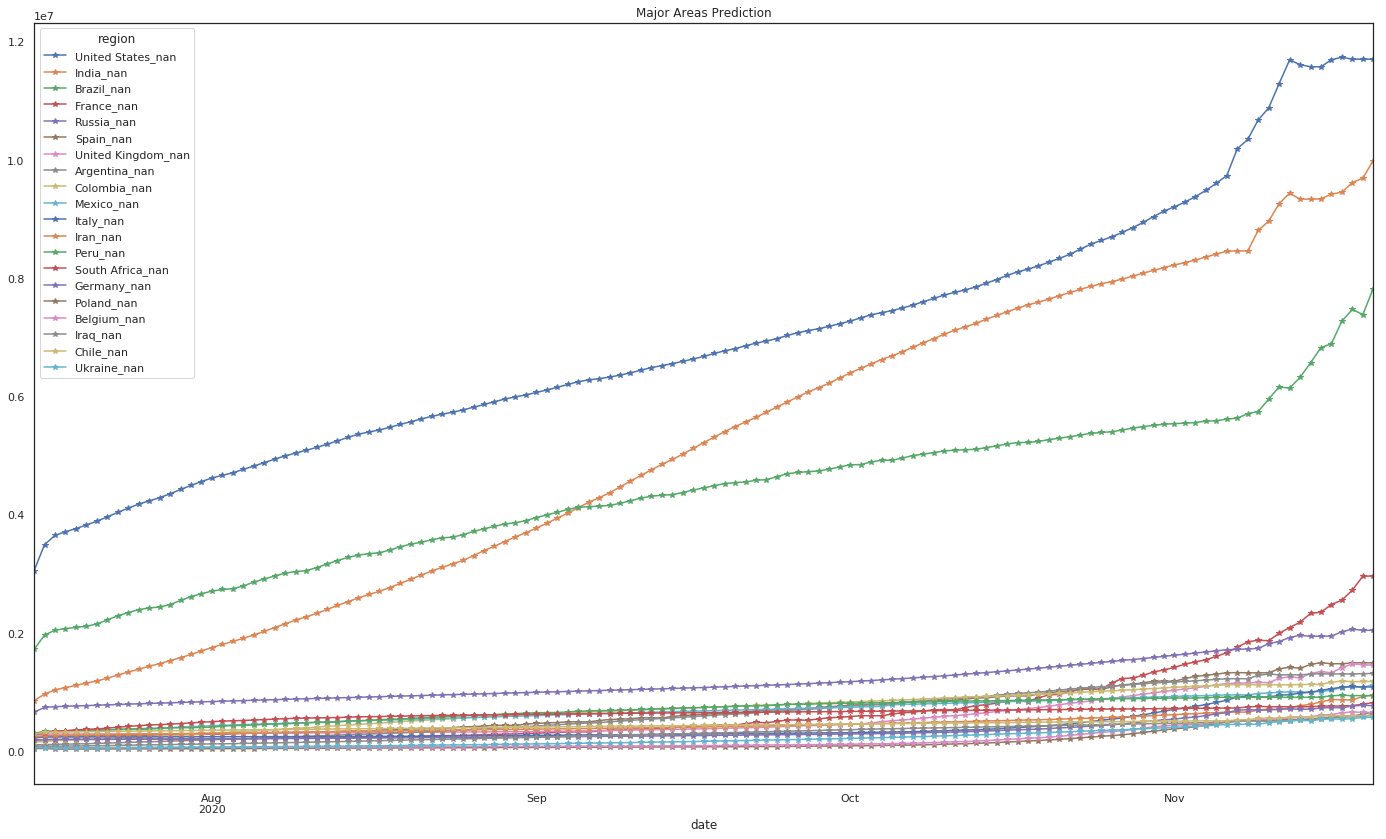

In [76]:
#
p=pred[region[:20]]
p[:].reindex(p.max().sort_values(ascending=False).index, axis=1).plot(marker='*',figsize=(24,14),title ='Major Areas Prediction')

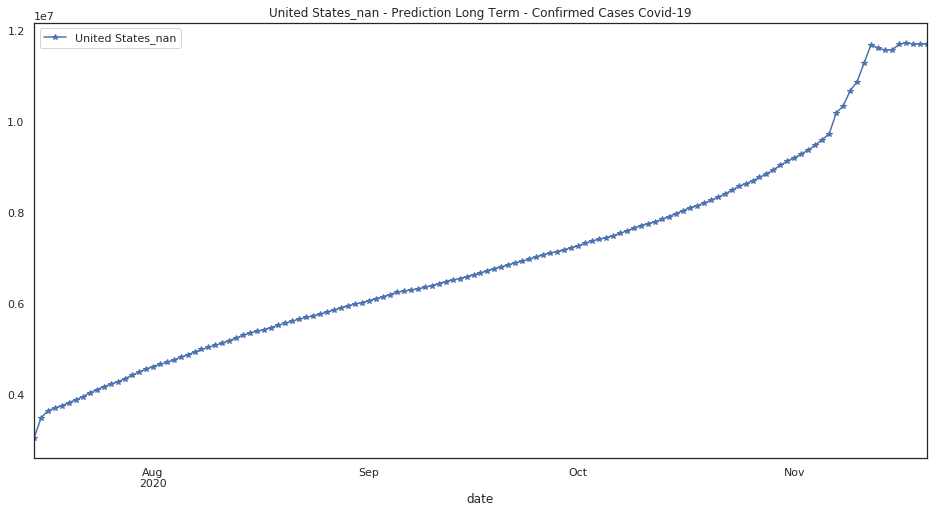

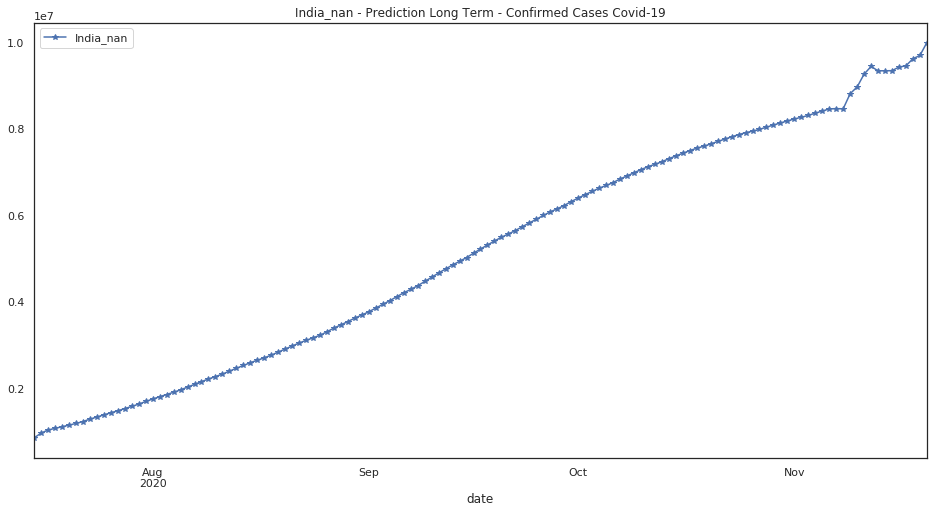

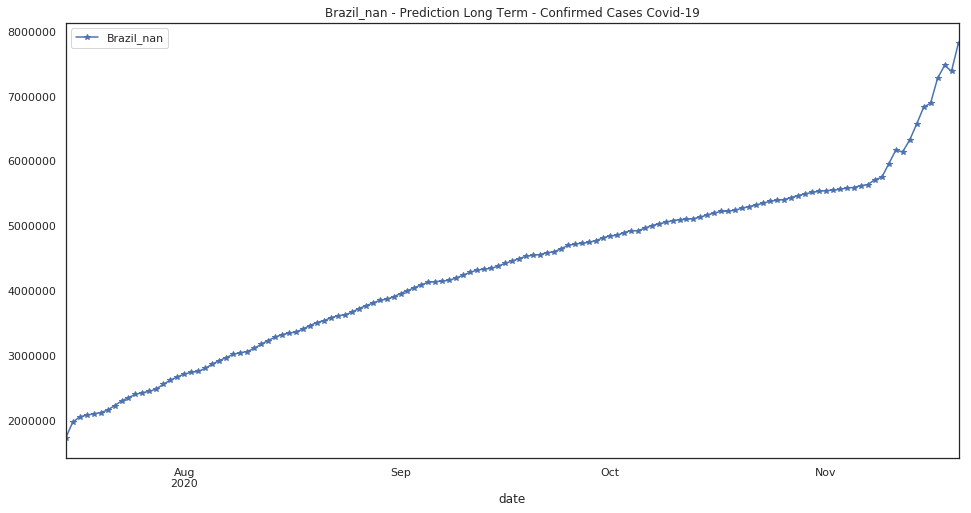

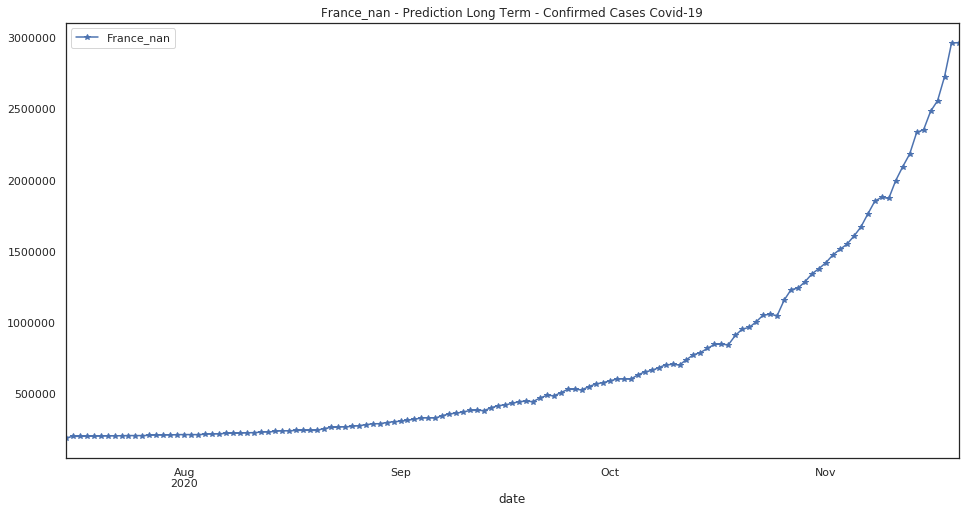

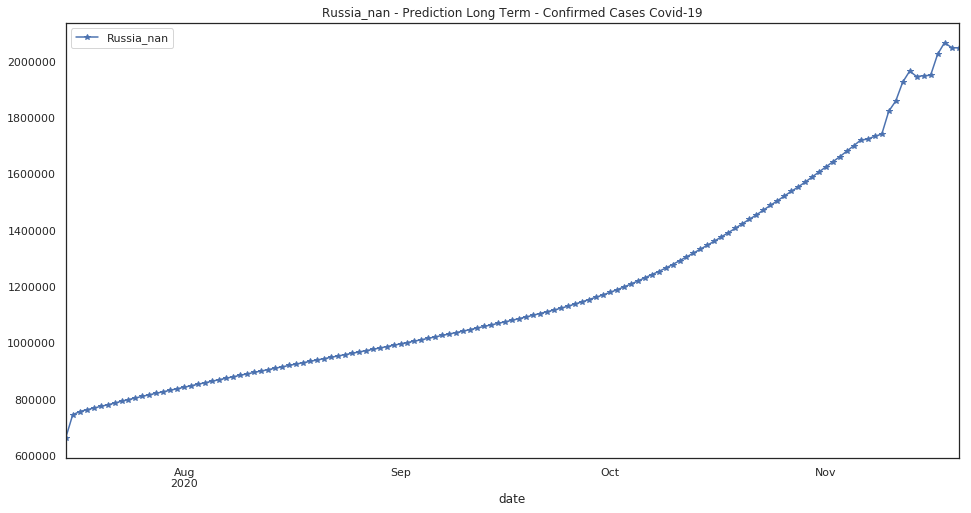

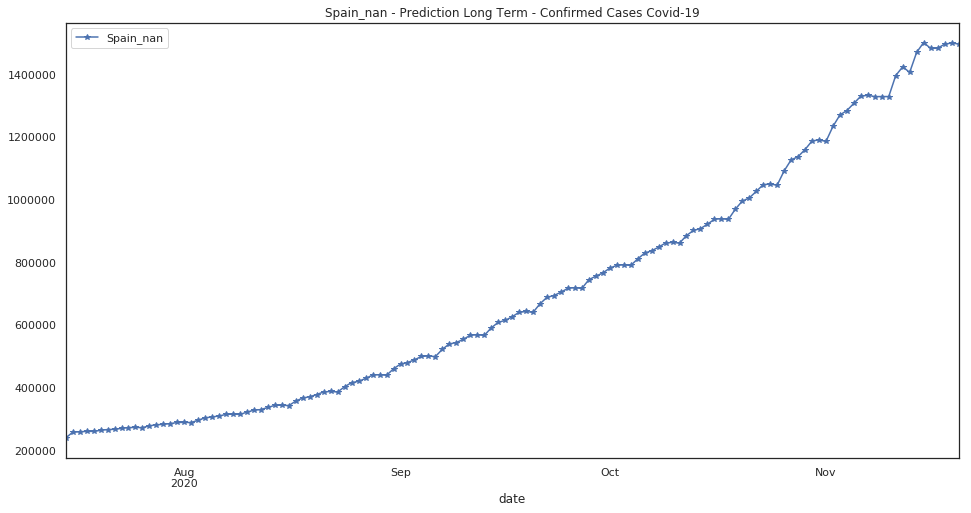

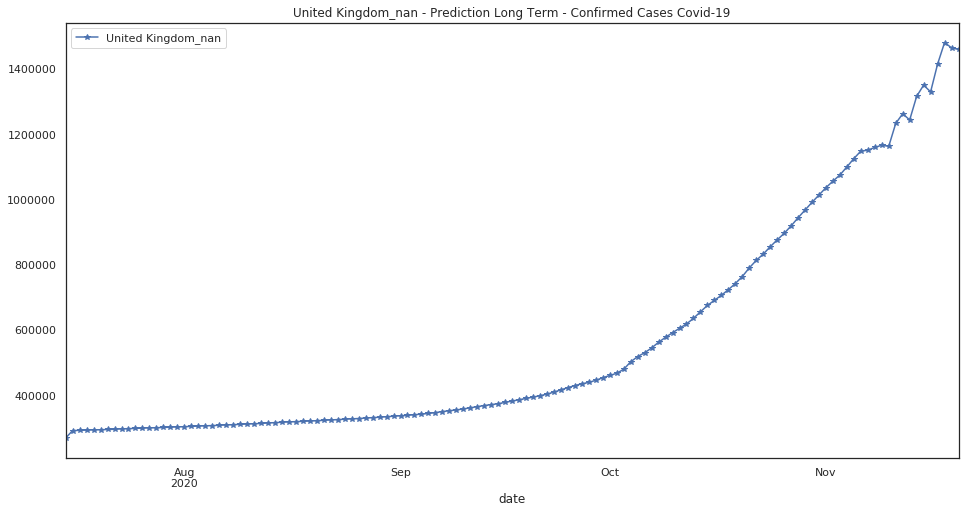

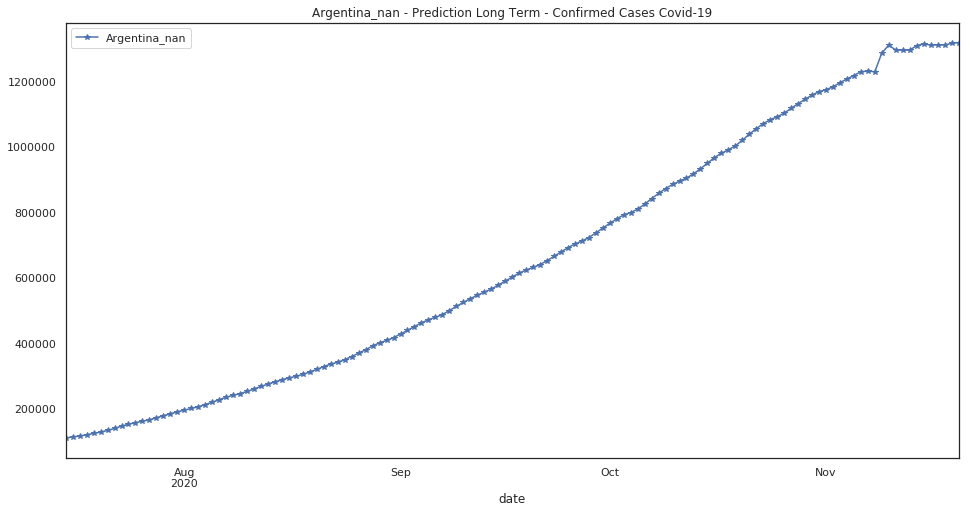

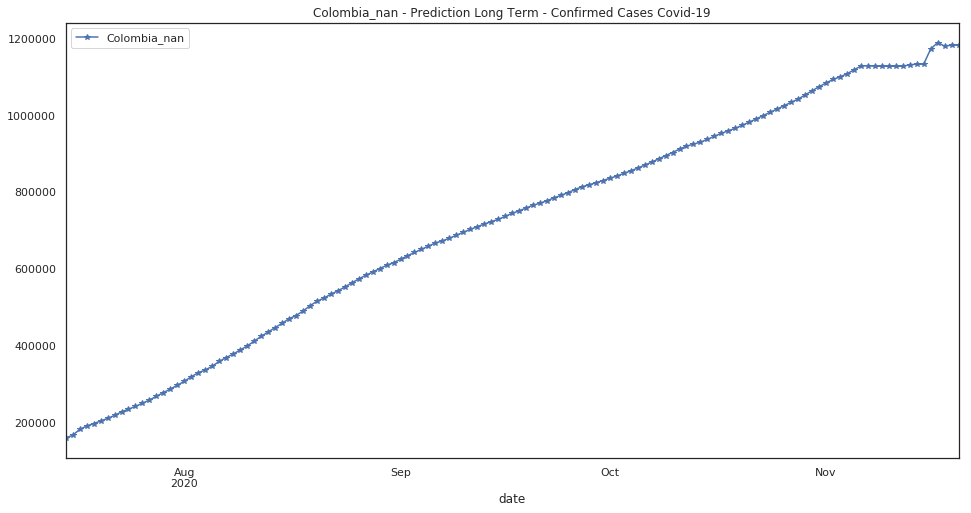

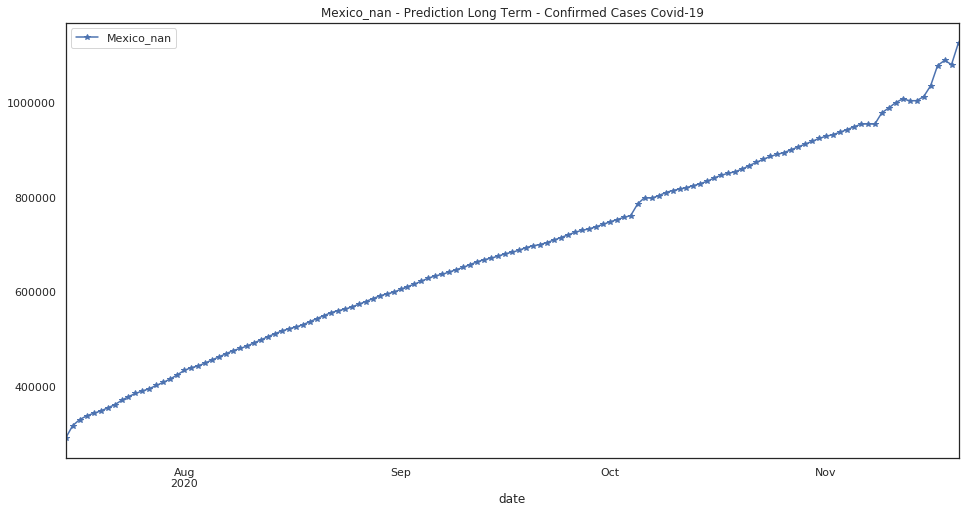

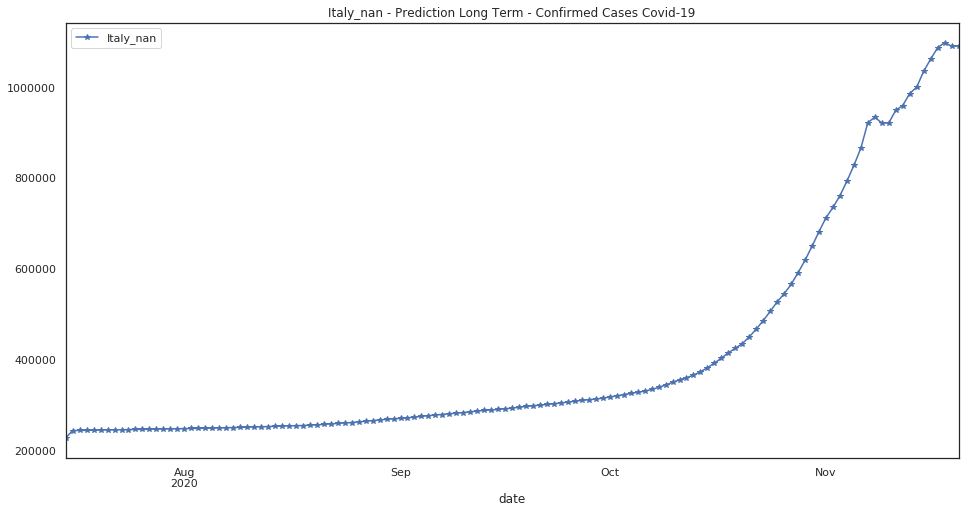

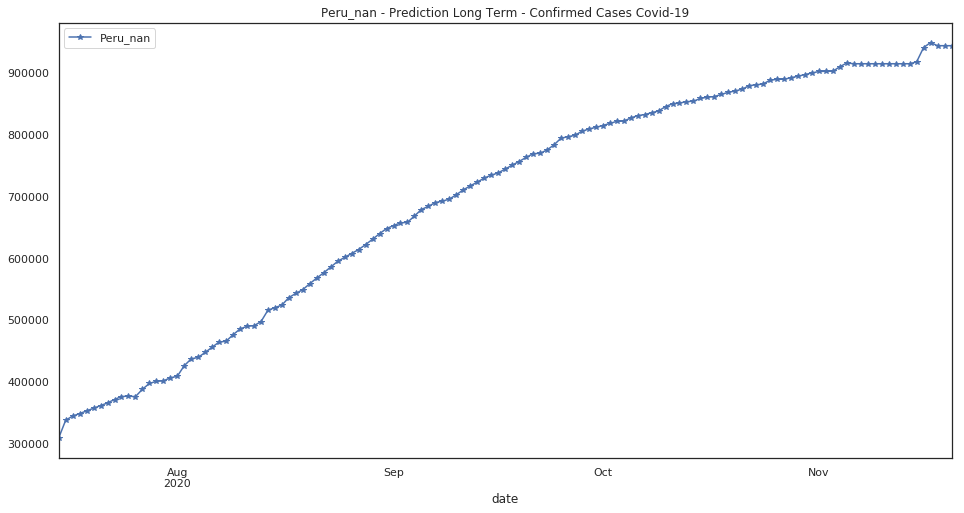

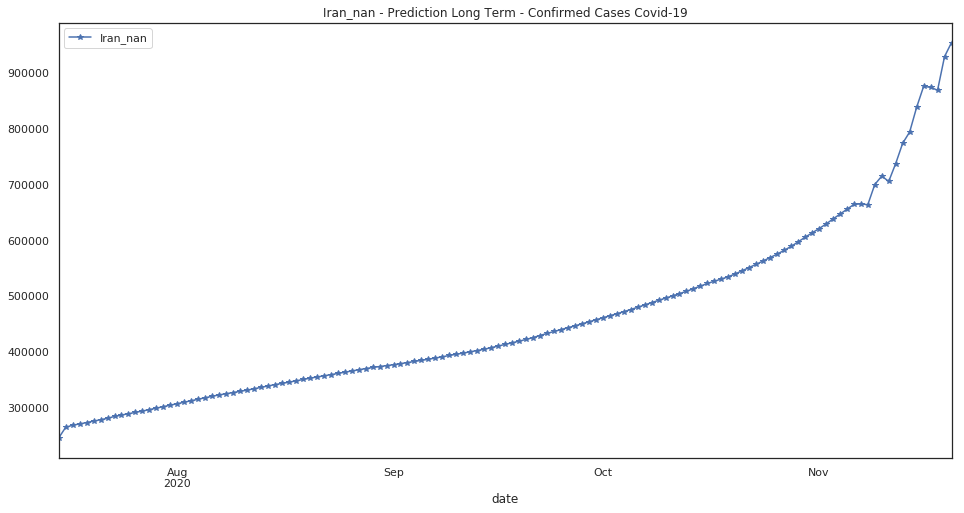

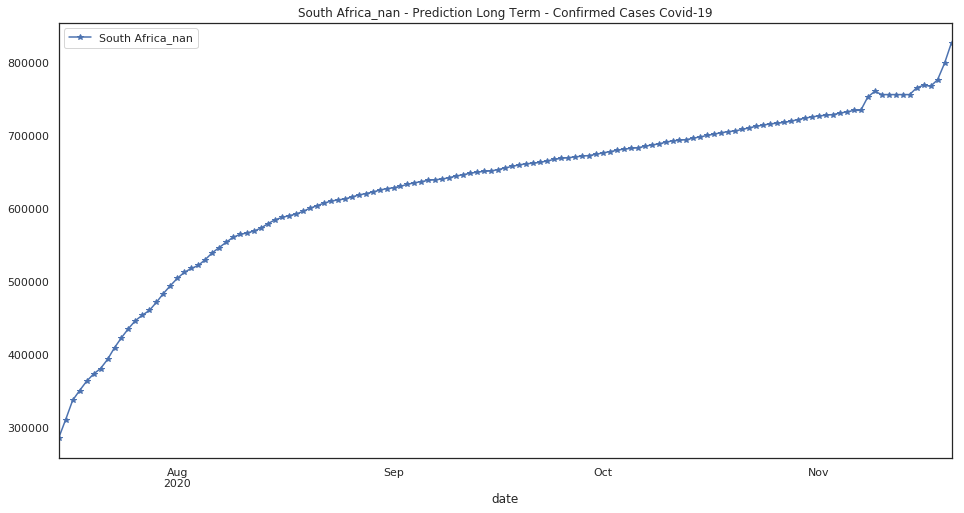

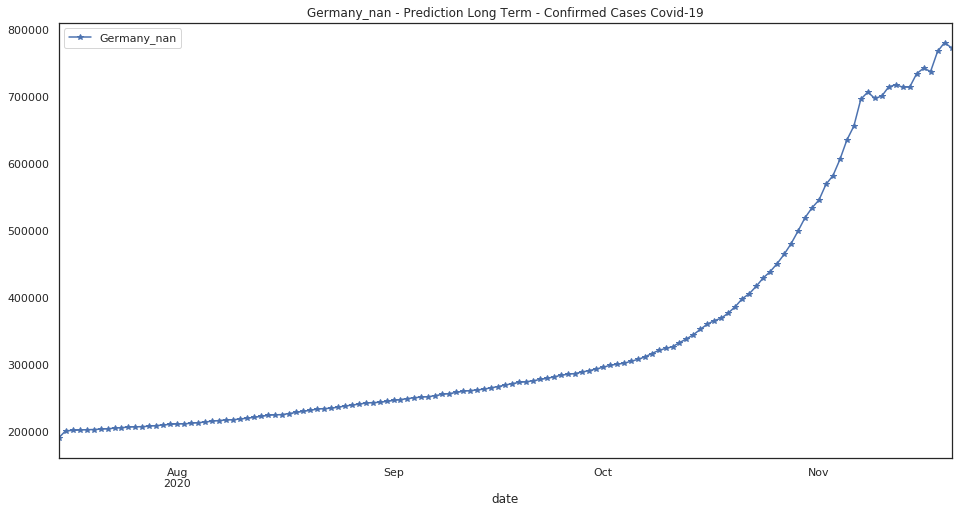

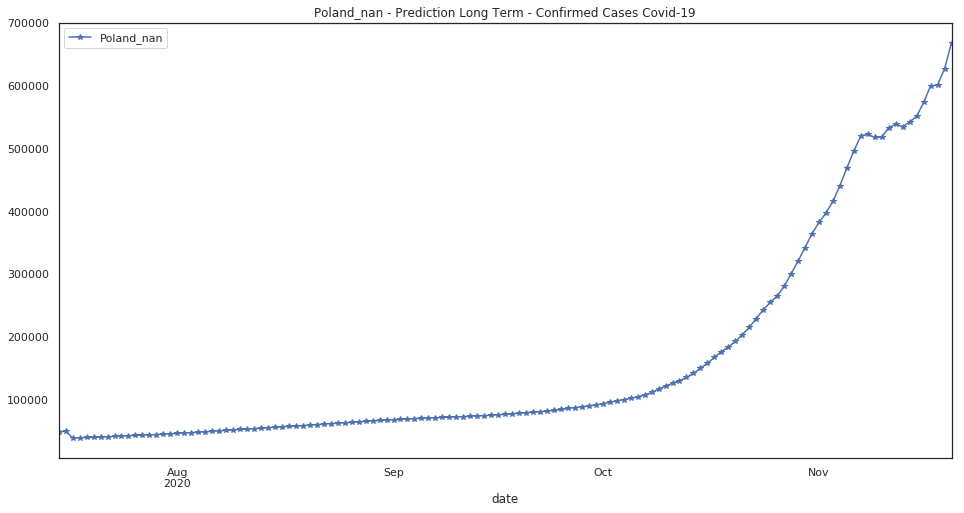

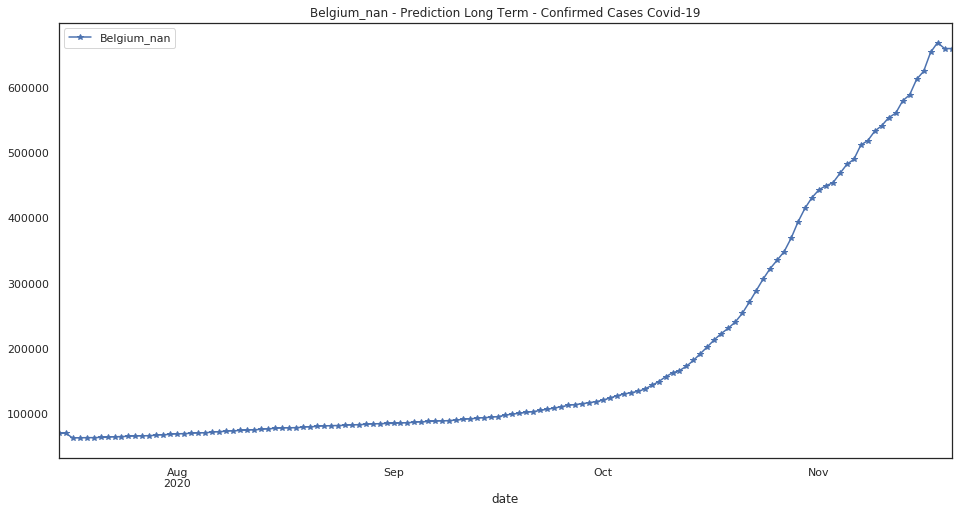

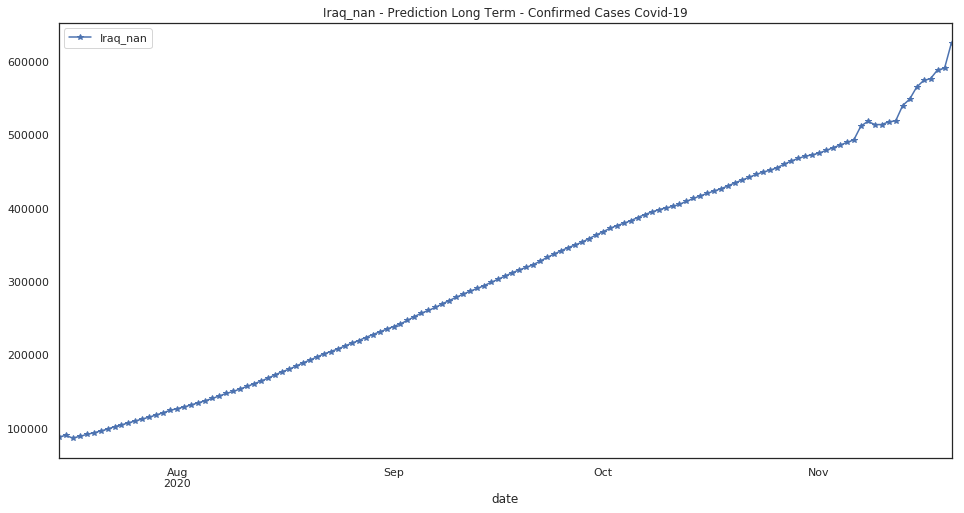

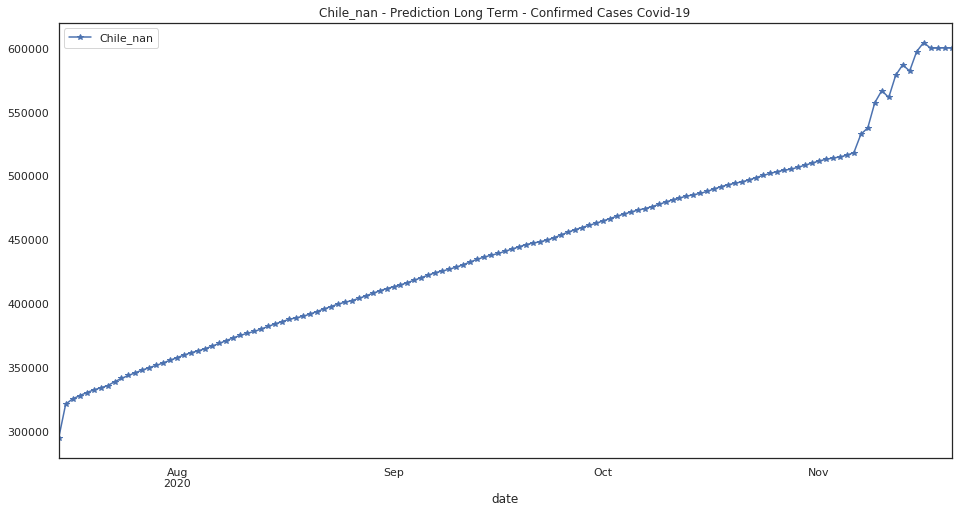

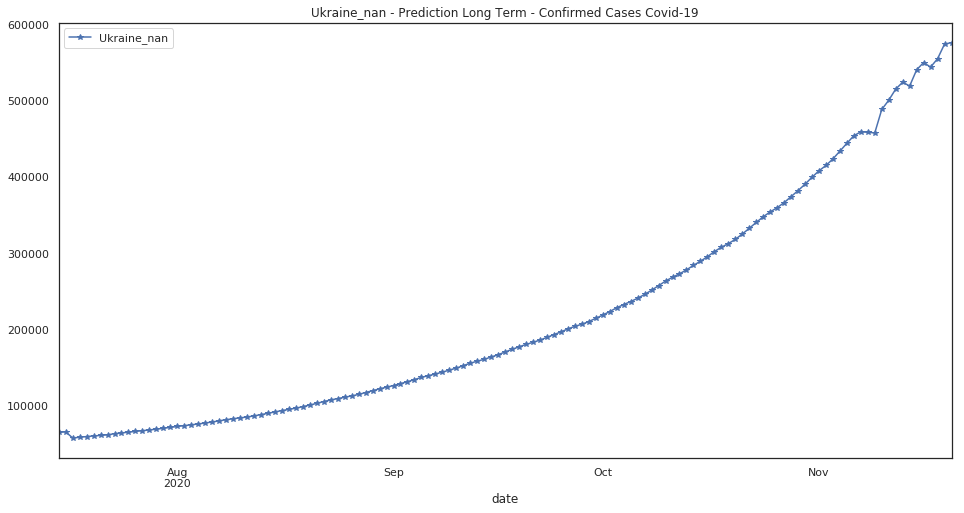

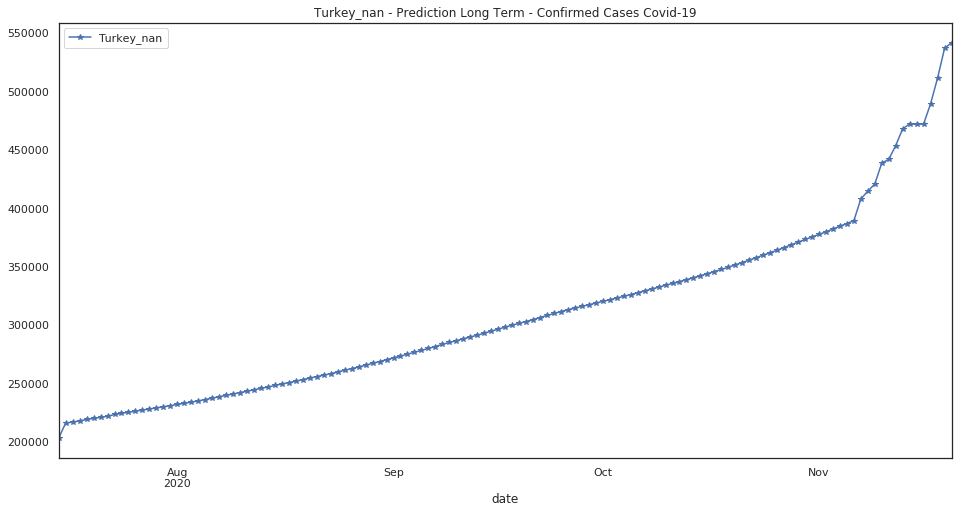

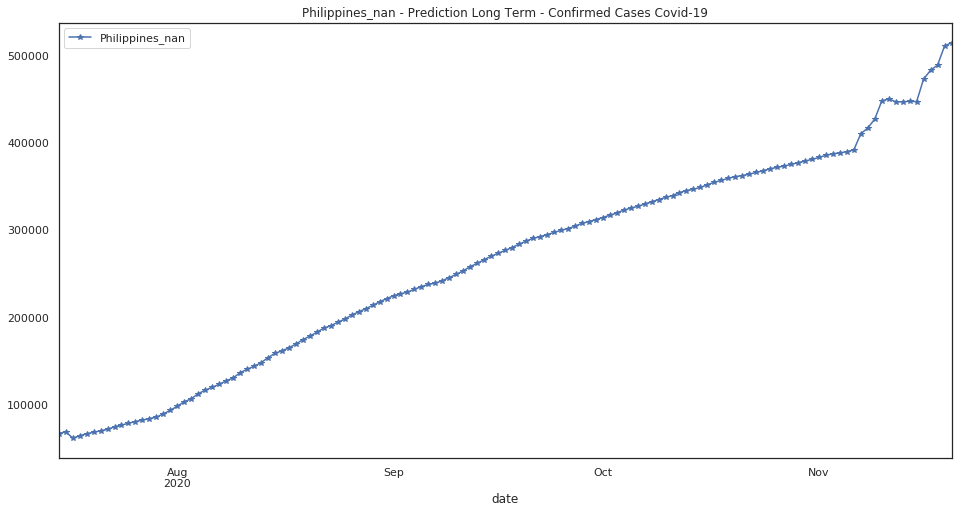

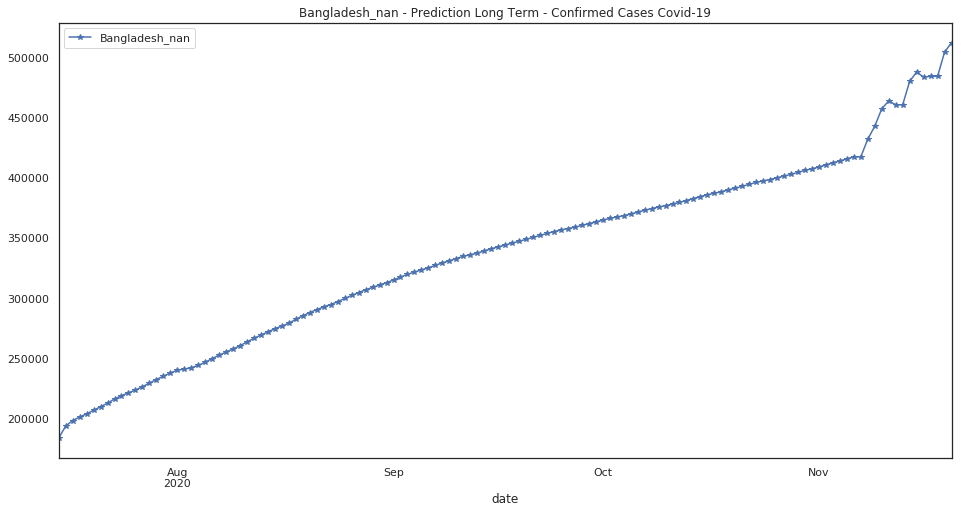

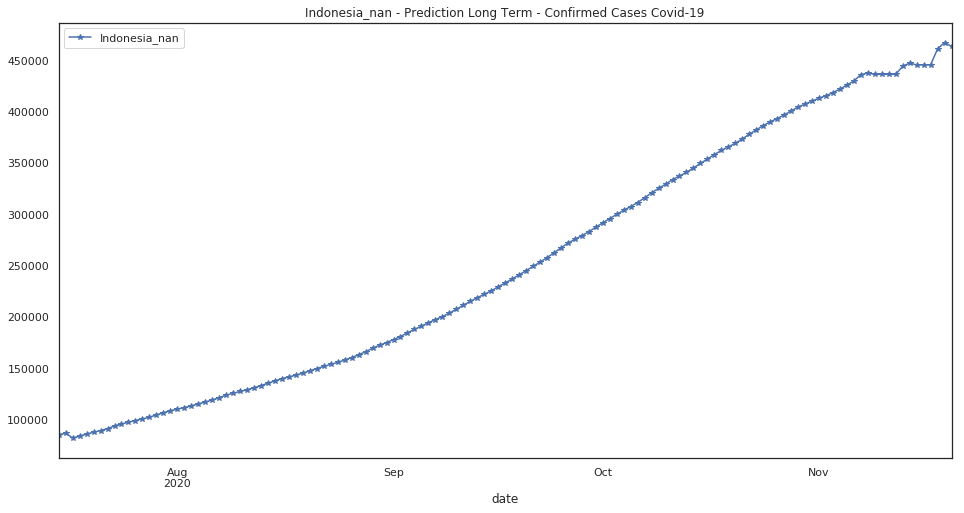

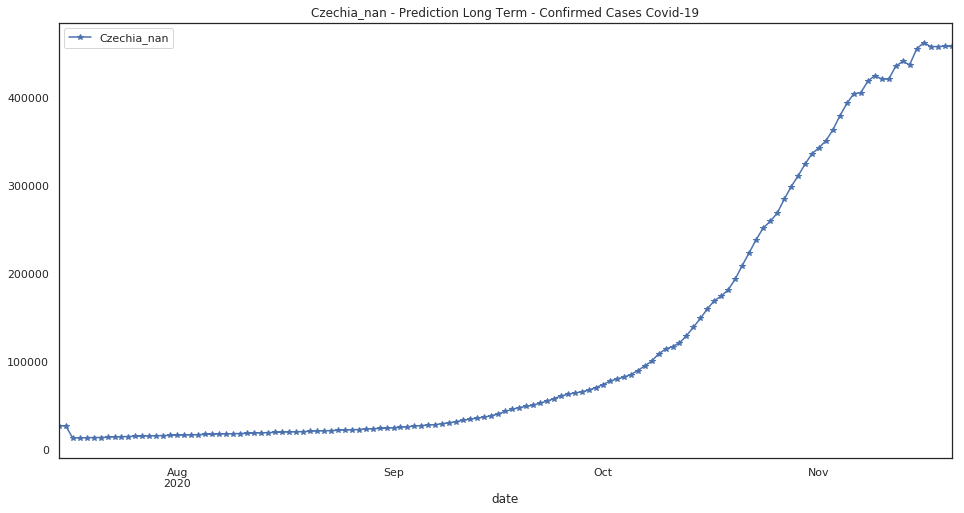

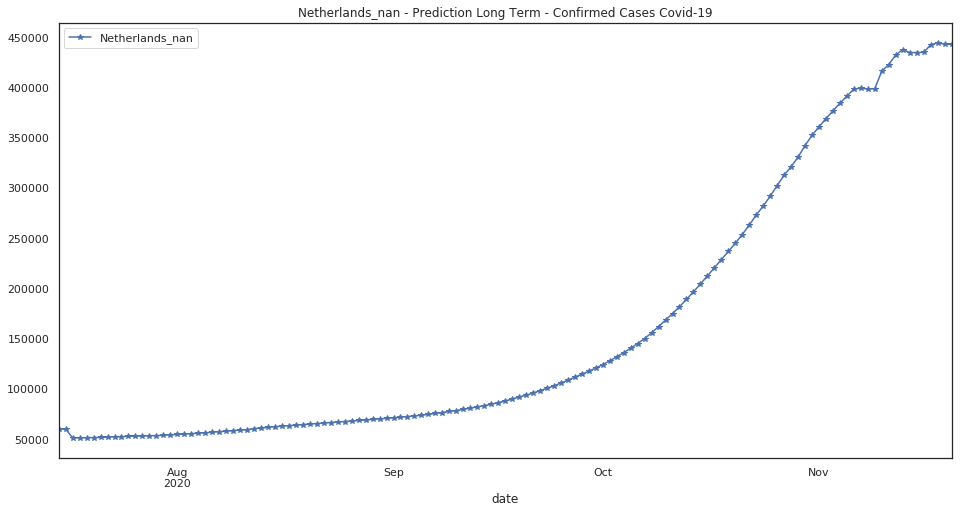

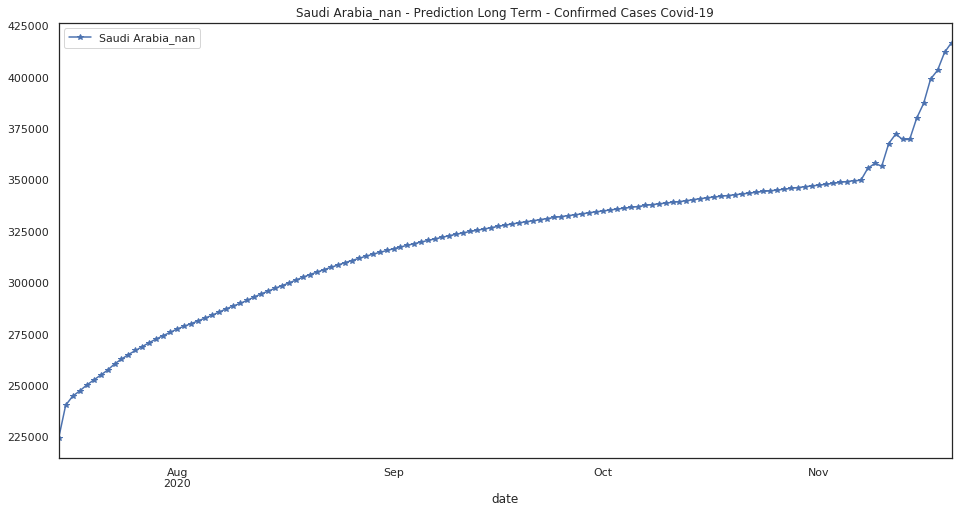

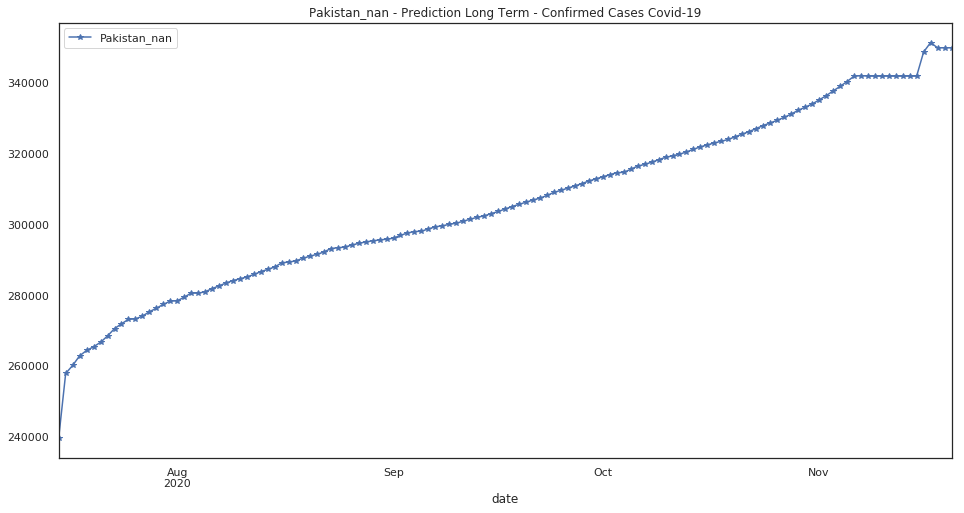

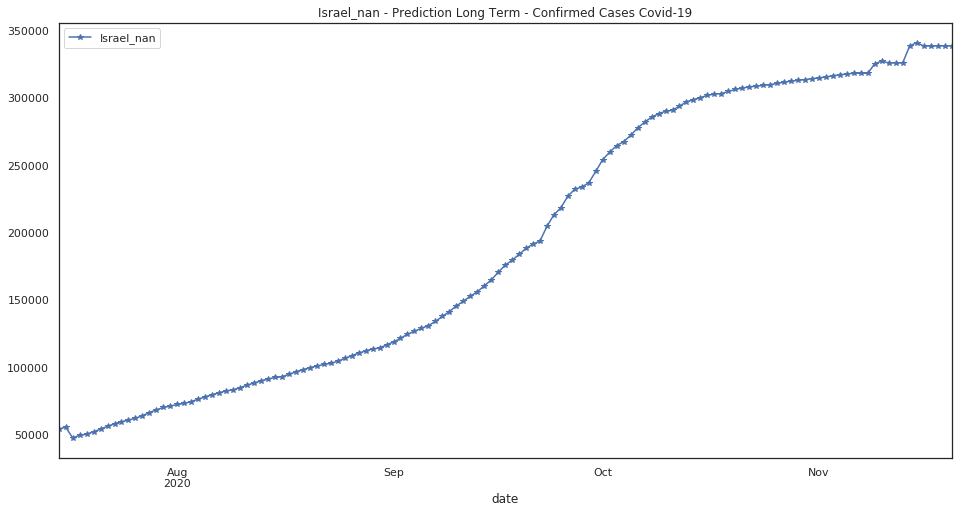

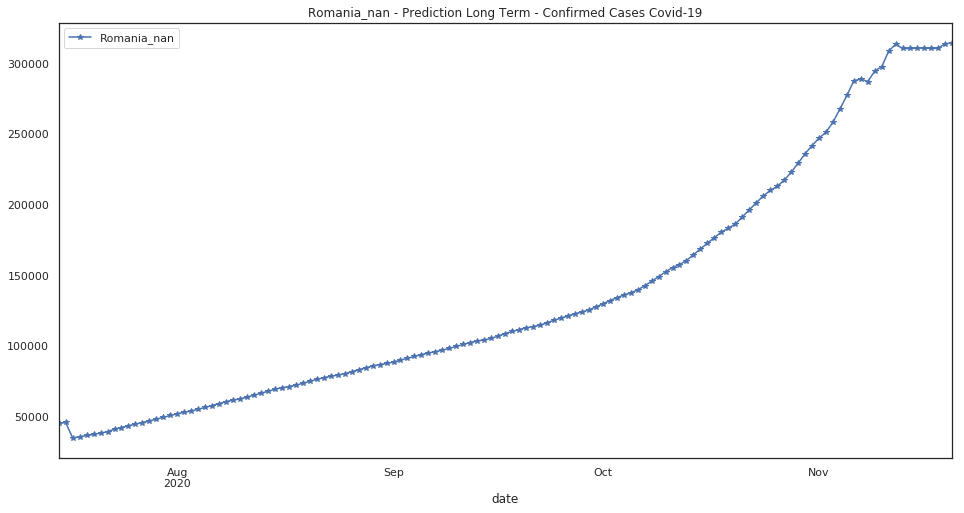

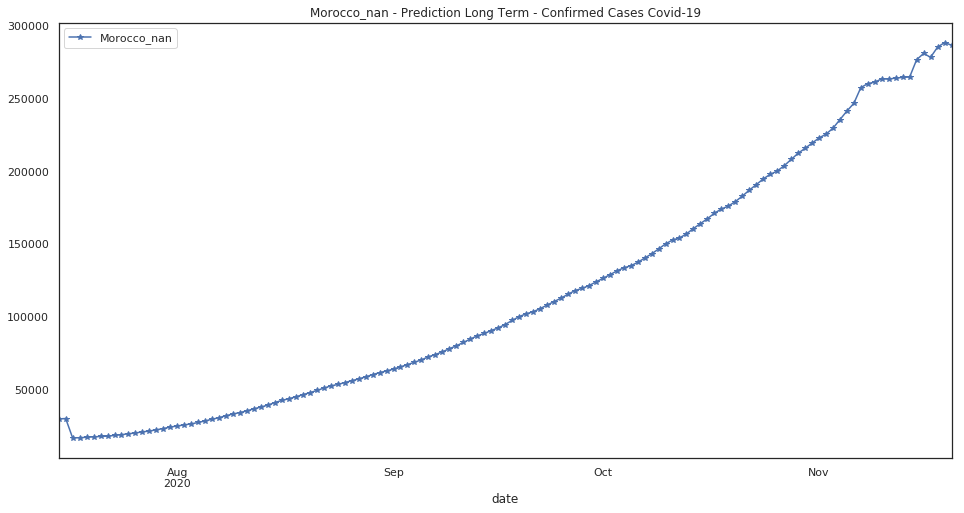

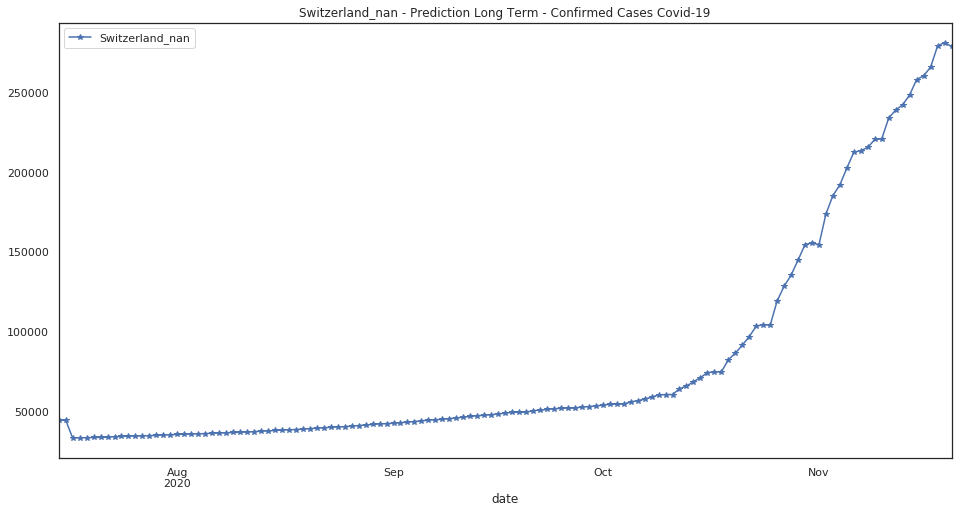

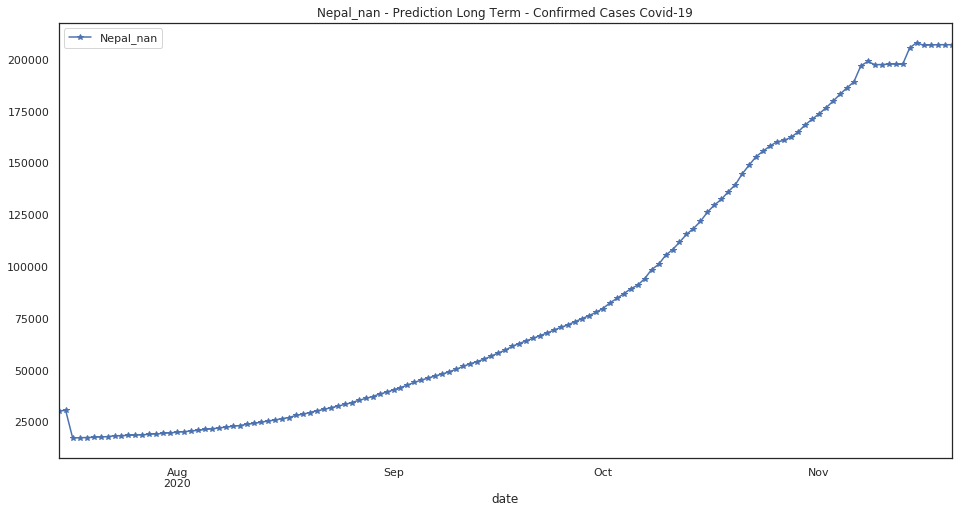

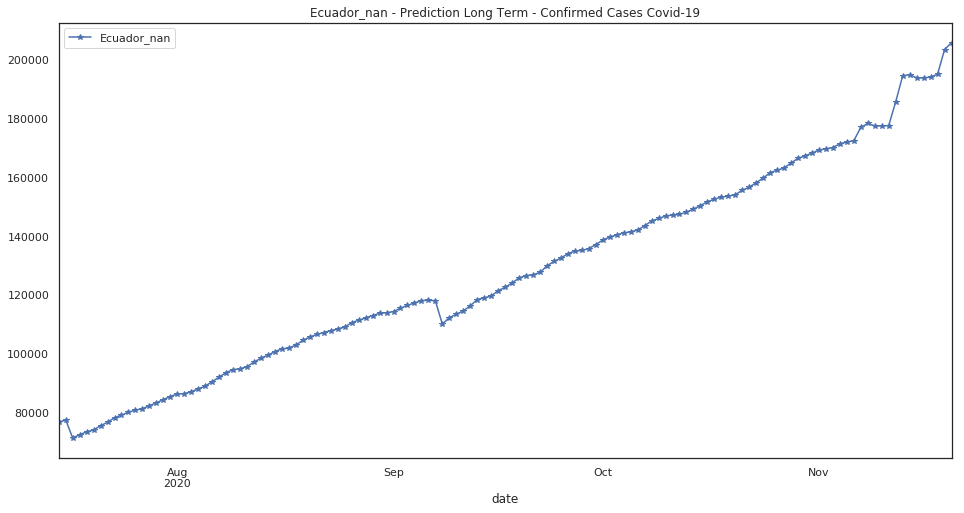

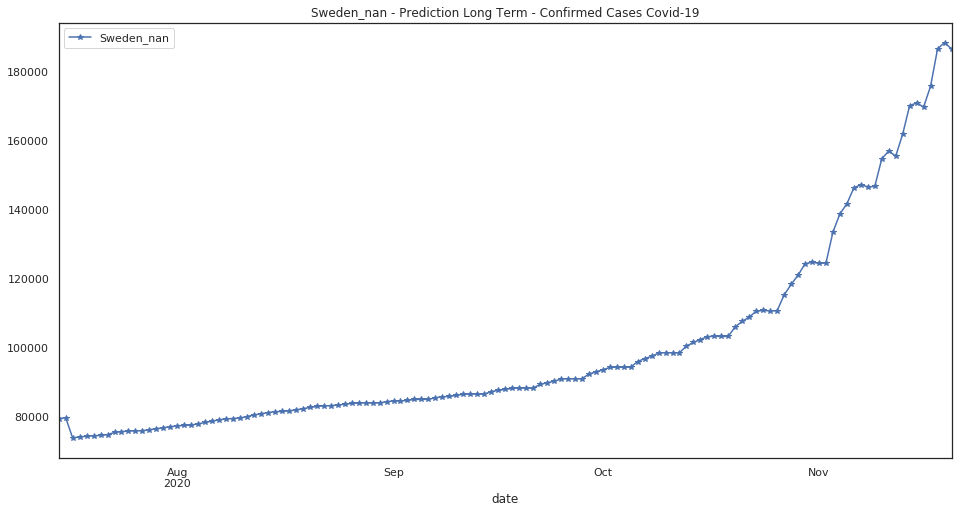

In [77]:
#
rgsx=region[:35]
for i in range (0,len(rgsx)):
        rg_print=rgsx[i]
        pred_prg=pd.DataFrame()
        pred_prg=pred[rg_print]
        pred_prg[:].plot(marker='*',figsize=(16,8),title =rg_print+' - Prediction Long Term - Confirmed Cases Covid-19')
        plt.legend(loc = 'upper left')
        plt.show()
#

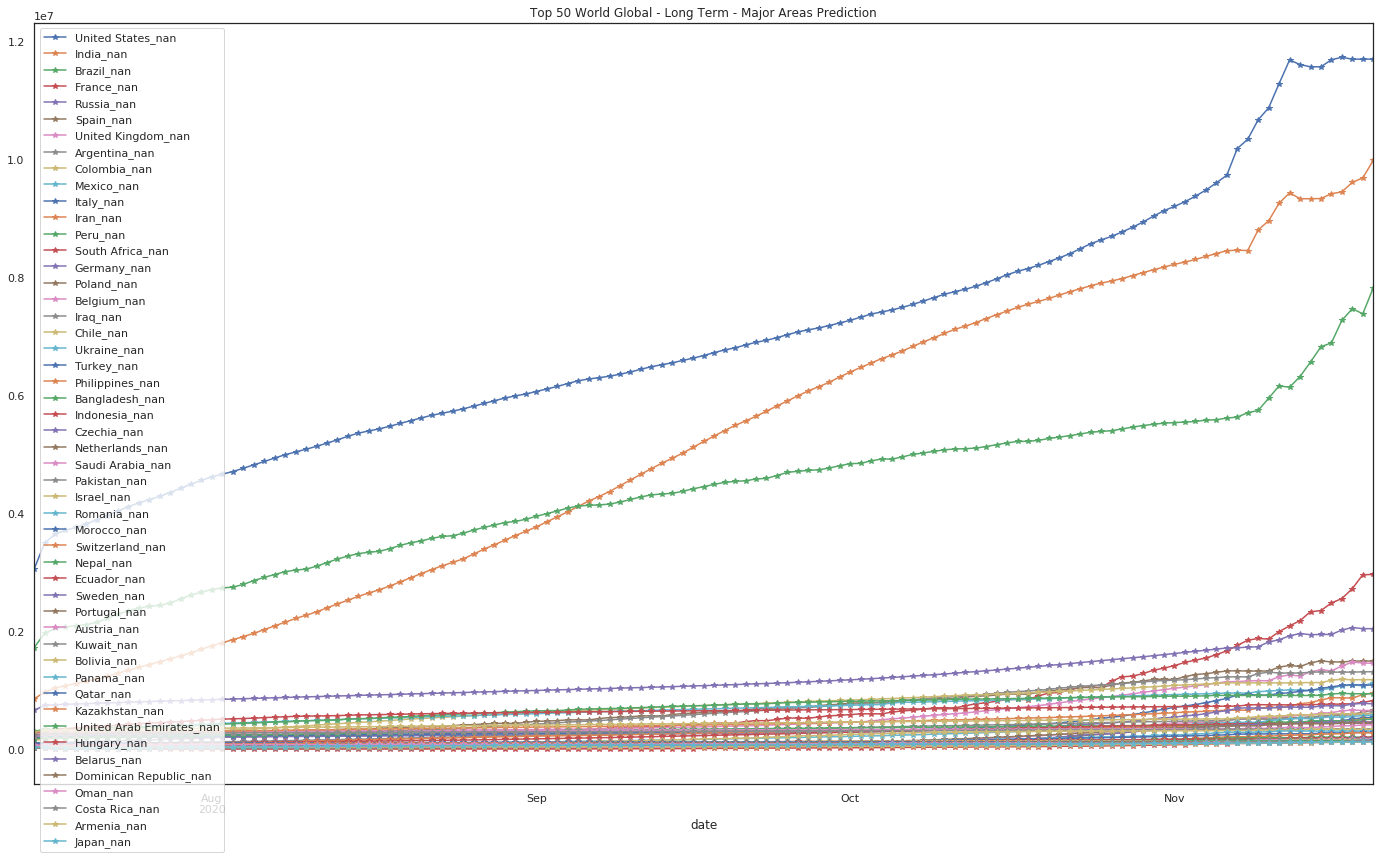

In [78]:
#region=my_train_list
pv2=pred
pv2=pv2.reindex(pv2.max().sort_values(ascending=False).index, axis=1)
pv2[:].iloc[:,0:50].plot(marker='*',figsize=(24,14),title ='Top 50 World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()

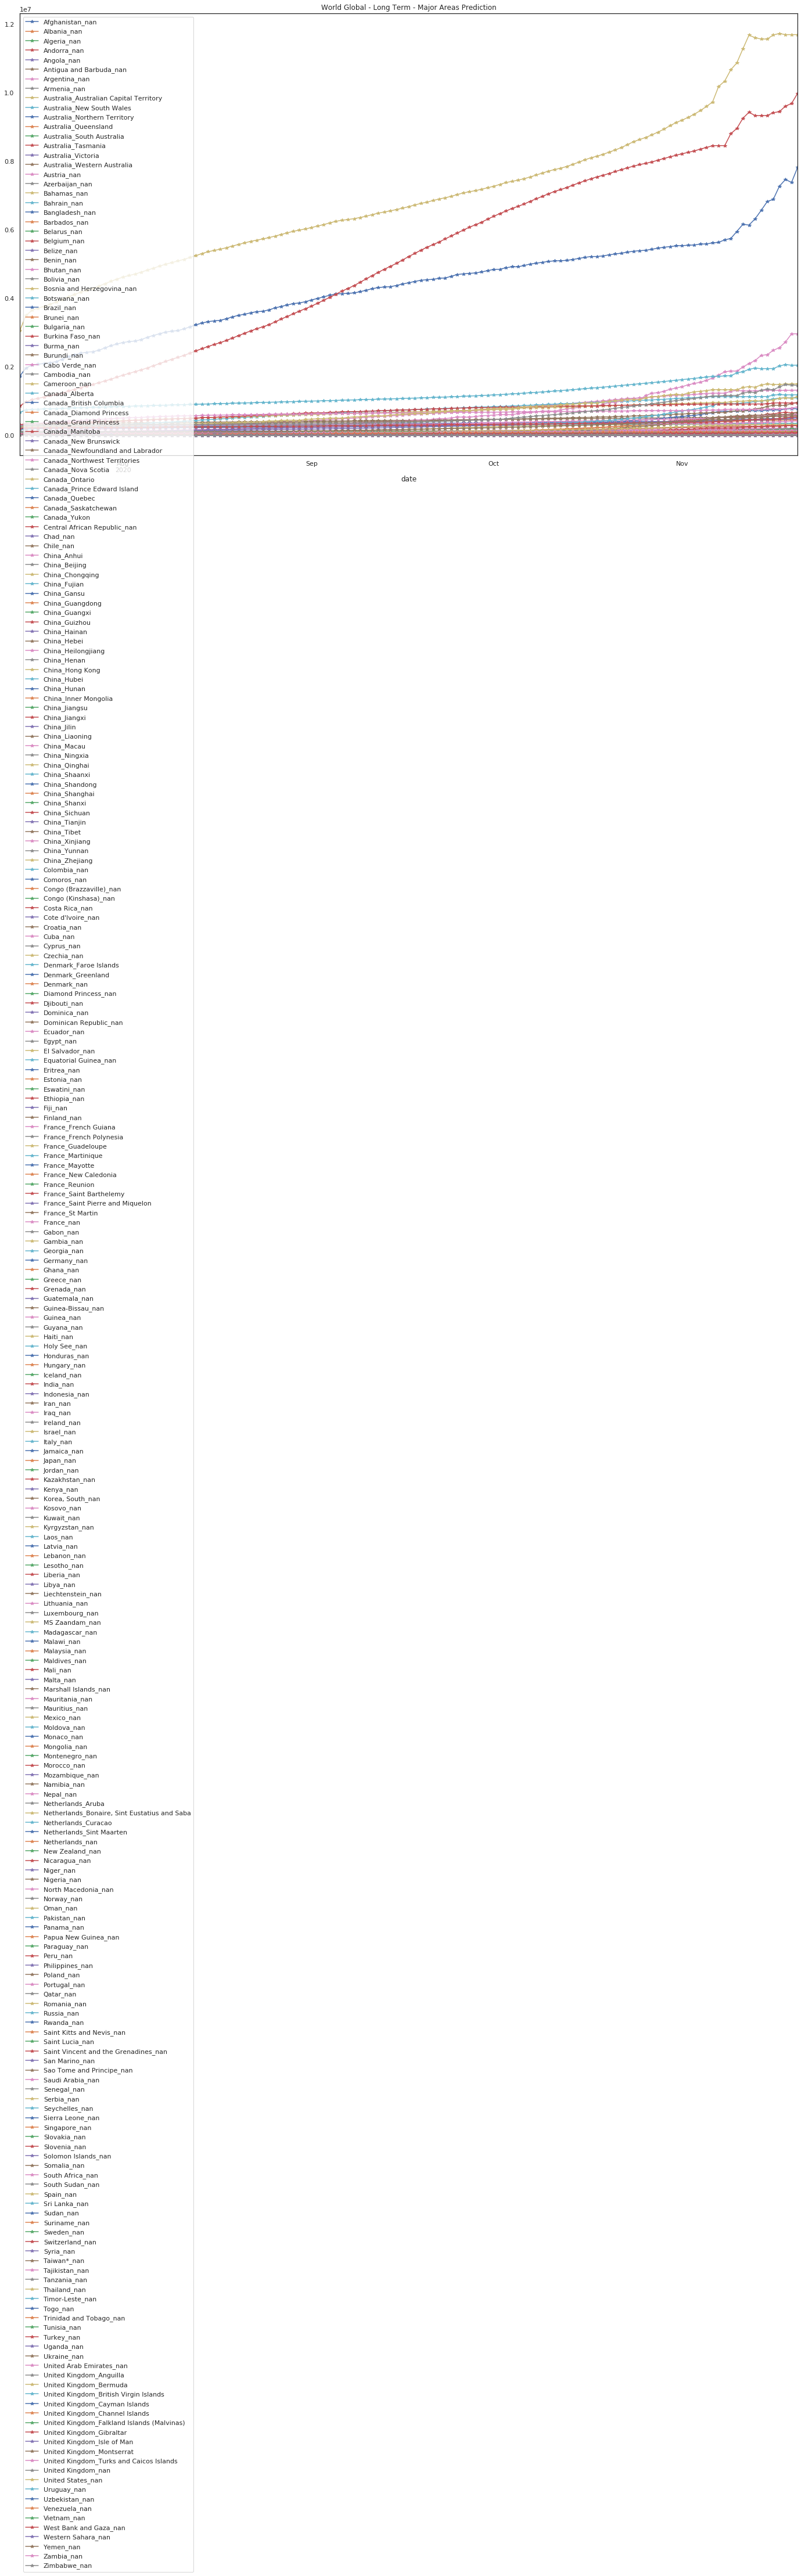

In [79]:
#region=my_train_list
pv2=pred
pv2[:].plot(marker='*',figsize=(24,14),title ='World Global - Long Term - Major Areas Prediction')
plt.legend(loc = 'upper left')
plt.show()


## Prediction Heatmap

In [80]:
pv1=pv2[:] #p  #p2.append(p3).append(p4).append(p5).append(p6).append(p8).append(p9).append(p11)
p=pd.DataFrame(pv1)

In [81]:
p[45:]

region      Afghanistan_nan  Albania_nan  Algeria_nan  Andorra_nan  \
date                                                                 
2020-08-29          38279.0       9359.0      43864.0       1124.0   
2020-08-30          38297.0       9492.0      44232.0       1364.0   
2020-08-31          38298.0       9590.0      44584.0       1409.0   
2020-09-01          38327.0       9638.0      44926.0       1176.0   
2020-09-02          38367.0       9812.0      45254.0       1368.0   
2020-09-03          38409.0       9885.0      45567.0       1269.0   
2020-09-04          38429.0      10014.0      45872.0       1461.0   
2020-09-05          38454.0      10140.0      46170.0       1245.0   
2020-09-06          38521.0      10280.0      46463.0       1454.0   
2020-09-07          38607.0      10414.0      46752.0       1494.0   
2020-09-08          38639.0      10568.0      47037.0       1261.0   
2020-09-09          38674.0      10731.0      47315.0       1540.0   
2020-09-10          38702.0      10885.0      47587.0       1301.0   
2020-09-11          38736.0      11044.0      47852.0       1591.0   
2020-09-12          38770.0      11207.0      48109.0       1344.0   
2020-09-13          38840.0      11375.0      48357.0       1610.0   
2020-09-14          38891.0      11541.0      48600.0       1691.0   
2020-09-15          38937.0      11699.0      48838.0       1438.0   
2020-09-16          38980.0      11864.0      49070.0       1784.0   
2020-09-17          39002.0      12008.0      49298.0       1483.0   
2020-09-18          39017.0      12146.0      49518.0       1839.0   
2020-09-19          39051.0      12301.0      49729.0       1564.0   
2020-09-20          39161.0      12429.0      49933.0       1877.0   
2020-09-21          39189.0      12575.0      50131.0       1979.0   
2020-09-22          39225.0      12719.0      50322.0       1681.0   
2020-09-23          39271.0      12861.0      50508.0       2072.0   
2020-09-24          39297.0      13003.0      50688.0       1753.0   
2020-09-25          39318.0      13116.0      50863.0       2144.0   
2020-09-26          39327.0      13237.0      51024.0       1836.0   
2020-09-27          39360.0      13357.0      51178.0       2155.0   
...                     ...          ...          ...          ...   
2020-10-22          40728.0      18266.0      55449.0       3811.0   
2020-10-23          40803.0      18574.0      55722.0       4371.0   
2020-10-24          40889.0      18877.0      55975.0       4038.0   
2020-10-25          40956.0      19183.0      56238.0       4409.0   
2020-10-26          41058.0      19478.0      56514.0       4658.0   
2020-10-27          41148.0      19771.0      56800.0       4325.0   
2020-10-28          41261.0      20082.0      57117.0       4606.0   
2020-10-29          41378.0      20348.0      57424.0       4590.0   
2020-10-30          41450.0      20683.0      57742.0       4862.0   
2020-10-31          41546.0      20912.0      58036.0       4773.0   
2020-11-01          41621.0      21269.0      58363.0       4887.0   
2020-11-02          41749.0      21548.0      58670.0       5040.0   
2020-11-03          41841.0      21928.0      59062.0       5049.0   
2020-11-04          41933.0      22298.0      59591.0       5283.0   
2020-11-05          42049.0      22715.0      60219.0       5045.0   
2020-11-06          42096.0      23192.0      60850.0       5207.0   
2020-11-07          42754.0      23235.0      62501.0       5460.0   
2020-11-08          42768.0      23849.0      62739.0       5436.0   
2020-11-09          43389.0      23711.0      65446.0       5419.0   
2020-11-10          43470.0      23903.0      65873.0       5411.0   
2020-11-11          43555.0      23887.0      65884.0       5480.0   
2020-11-12          43562.0      24254.0      65871.0       5300.0   
2020-11-13          45306.0      24122.0      69455.0       5383.0   
2020-11-14          46112.0      24288.0      70031.0       5553.0   
2020-11-15

In [82]:
pfname='data/p+'+str(num_days_R_prediction)+'_confirmed_daily.csv'
p.to_csv(pfname, index = False, header=True)

In [83]:
#!pip install gmplot
# Import the necessary libraries
import pandas as pd
import gmplot
# For improved table display in the notebook
#from IPython.display import display
import random 

In [84]:
heatmap=confirmed[['region','Lat','Long']]
p_m=p.T # pred.T #
### JOAO - Change Global HeapMap print - USA is too small, as USA States datasets are not used! 
#heatmap=heatmap[heatmap['region'].isin(region)]  ## heatmap for region dataset only 
heatmap=heatmap[heatmap['region'].isin(confirmed['region'])] ## Global heatmap
p_m=p_m.reset_index()
heatmap_m=heatmap.merge(p_m,how='left',on='region')


In [85]:
heatmap_m[:]

region        Lat        Long  \
0                               Afghanistan_nan  33.939110   67.709953   
1                                   Albania_nan  41.153300   20.168300   
2                                   Algeria_nan  28.033900    1.659600   
3                                   Andorra_nan  42.506300    1.521800   
4                                    Angola_nan -11.202700   17.873900   
5                       Antigua and Barbuda_nan  17.060800  -61.796400   
6                                 Argentina_nan -38.416100  -63.616700   
7                                   Armenia_nan  40.069100   45.038200   
8        Australia_Australian Capital Territory -35.473500  149.012400   
9                     Australia_New South Wales -33.868800  151.209300   
10                 Australia_Northern Territory -12.463400  130.845600   
11                         Australia_Queensland -27.469800  153.025100   
12                    Australia_South Australia -34.928500  138.600700   
13                           Australia_Tasmania -42.882100  147.327200   
14                           Australia_Victoria -37.813600  144.963100   
15                  Australia_Western Australia -31.950500  115.860500   
16                                  Austria_nan  47.516200   14.550100   
17                               Azerbaijan_nan  40.143100   47.576900   
18                                  Bahamas_nan  25.025885  -78.035889   
19                                  Bahrain_nan  26.027500   50.550000   
20                               Bangladesh_nan  23.685000   90.356300   
21                                 Barbados_nan  13.193900  -59.543200   
22                                  Belarus_nan  53.709800   27.953400   
23                                  Belgium_nan  50.833300    4.469936   
24                                   Belize_nan  17.189900  -88.497600   
25                                    Benin_nan   9.307700    2.315800   
26                                   Bhutan_nan  27.514200   90.433600   
27                                  Bolivia_nan -16.290200  -63.588700   
28                   Bosnia and Herzegovina_nan  43.915900   17.679100   
29                                 Botswana_nan -22.328500   24.684900   
..                                          ...        ...         ...   
244                                Thailand_nan  15.870032  100.992541   
245                             Timor-Leste_nan  -8.874217  125.727539   
246                                    Togo_nan   8.619500    0.824800   
247                     Trinidad and Tobago_nan  10.691800  -61.222500   
248                                 Tunisia_nan  33.886917    9.537499   
249                                  Turkey_nan  38.963700   35.243300   
250                           United States_nan  40.000000 -100.000000   
251                                  Uganda_nan   1.373333   32.290275   
252                                 Ukraine_nan  48.379400   31.165600   
253                    United Arab Emirates_nan  23.424076   53.847818   
254                     United Kingdom_Anguilla  18.220600  -63.068600   
255                      United Kingdom_Bermuda  32.307800  -64.750500   
256       United Kingdom_British Virgin Islands  18.420700  -64.640000   
257               United Kingdom_Cayman Islands  19.313300  -81.254600   
258              United Kingdom_Channel Islands  49.372300   -2.364400   
259  United Kingdom_Falkland Islands (Malvinas) -51.796300  -59.523600   
260                    United Kingdom_Gibraltar  36.140800   -5.353600   
261                  United Kingdom_Isle of Man  54.236100   -4.548100   
262                   United Kingdom_Montserrat  16.742498  -62.187366   
263     United Kingdom_Turks and Caicos Islands  21.694000  -71.797900   
264                          United Kingdom_nan  55.378100   -3.436000   
265                                 Uruguay_nan -32.522800  -55.765800   
266                              Uzbekistan_n

In [86]:
#!pip install folium
import folium
import re

lat=40.99474
lang=6.87237

p21_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat,lng,num,totpred,ldaygrowth in zip(heatmap_m.Lat,heatmap_m.Long,range(0,heatmap_m.shape[0]), heatmap_m[heatmap_m.columns[-1]],  (heatmap_m[heatmap_m.columns[-1]]-heatmap_m[heatmap_m.columns[ndayarray]])/ndaysavg ):
    use_color=heatmap_m['region'][num][0]
    print_region=re.sub('_nan',  '', heatmap_m['region'][num])
    popup = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred))+' 1DayChangePred='+str(round(ldaygrowth))+' Date='+date_pred , parse_html=True)
    #
    folium.Marker(
                    [lat,lng],
                    popup=popup,
                    icon=folium.Icon(color=colors[use_color])
            ).add_to(p21_cluster)
p21_cluster

In [87]:
# Top 50 Regions in the World impacted
#
max_cont=max_countries_map
region_m2=region[:max_cont]
#
heatmap_m2=heatmap_m[heatmap_m['region'].isin(region_m2)].reset_index()
#
heatmap_m2[:]

index                    region        Lat        Long  \
0       6             Argentina_nan -38.416100  -63.616700   
1       7               Armenia_nan  40.069100   45.038200   
2      16               Austria_nan  47.516200   14.550100   
3      20            Bangladesh_nan  23.685000   90.356300   
4      22               Belarus_nan  53.709800   27.953400   
5      23               Belgium_nan  50.833300    4.469936   
6      27               Bolivia_nan -16.290200  -63.588700   
7      30                Brazil_nan -14.235000  -51.925300   
8      52             Canada_Quebec  52.939900  -73.549100   
9      57                 Chile_nan -35.675100  -71.543000   
10     91              Colombia_nan   4.570900  -74.297300   
11     95            Costa Rica_nan   9.748900  -83.753400   
12    100               Czechia_nan  49.817500   15.473000   
13    107    Dominican Republic_nan  18.735700  -70.162700   
14    108               Ecuador_nan  -1.831200  -78.183400   
15    128                France_nan  46.227600    2.213700   
16    133               Germany_nan  51.165691   10.451526   
17    145               Hungary_nan  47.162500   19.503300   
18    147                 India_nan  20.593684   78.962880   
19    148             Indonesia_nan  -0.789300  113.921300   
20    149                  Iran_nan  32.427908   53.688046   
21    150                  Iraq_nan  33.223191   43.679291   
22    152                Israel_nan  31.046051   34.851612   
23    153                Israel_nan  31.046051   34.851612   
24    154                 Italy_nan  41.871940   12.567380   
25    156                 Japan_nan  36.204824  138.252924   
26    158            Kazakhstan_nan  48.019600   66.923700   
27    162                Kuwait_nan  29.311660   47.481766   
28    184                Mexico_nan  23.634500 -102.552800   
29    189               Morocco_nan  31.791700   -7.092600   
30    192                 Nepal_nan  28.166700   84.250000   
31    197           Netherlands_nan  52.132600    5.291300   
32    204                  Oman_nan  21.512583   55.923255   
33    205              Pakistan_nan  30.375300   69.345100   
34    206                Panama_nan   8.538000  -80.782100   
35    209                  Peru_nan  -9.190000  -75.015200   
36    210           Philippines_nan  12.879721  121.774017   
37    211                Poland_nan  51.919400   19.145100   
38    212              Portugal_nan  39.399900   -8.224500   
39    213                 Qatar_nan  25.354800   51.183900   
40    214               Romania_nan  45.943200   24.966800   
41    215                Russia_nan  61.524010  105.318756   
42    222          Saudi Arabia_nan  23.885942   45.079162   
43    232          South Africa_nan -30.559500   22.937500   
44    234                 Spain_nan  40.463667   -3.749220   
45    238                Sweden_nan  60.128161   18.643501   
46    239           Switzerland_nan  46.818200    8.227500   
47    249                Turkey_nan  38.963700   35.243300   
48    250         United States_nan  40.000000 -100.000000   
49    252               Ukraine_nan  48.379400   31.165600   
50    253  United Arab Emirates_nan  23.424076   53.847818   
51    264        United Kingdom_nan  55.378100   -3.436000   

    2020-07-15 00:00:00  2020-07-16 00:00:00  2020-07-17 00:00:00  \
0              112134.0             115296.0             118073.0   
1               44200.0              44682.0              33559.0   
2               32158.0              32259.0              19270.0   
3              183809.0             193590.0             198303.0   
4               72401.0              72557.0              65623.0   
5               70166.0              70484.0              63238.0   
6               60903.0              62588.0              54737.0   
7             1725359.0            1966748.0            2050897.0   
8               64938.0              65062.0              57001.0   
9              294755.0    

In [88]:
import folium
import re

lat=40.99474
lang=6.87237

p21_reg_cluster=folium.Map(location=[lat,lang],zoom_start=2)
from folium import plugins
cluster=plugins.MarkerCluster().add_to(p21_reg_cluster)

colors={'A':'darkgreen','B':'darkpurple','C':'pink','D':'beige','E':'red','F':'lightblue','G':'darkblue','H':'cadetblue','I':'gray',
        'J':'lightred','K':'blue','L':'orange','M':'lightgreen','N':'orange','O':'purple','P':'lightgray','Q':'darkred','R':'green',
        'S':'black','T':'blue','U':'purple','V':'green','X':'blue','Y':'beige','W':'pink','Z':'white'}

date_pred=(datetime.today()+pd.DateOffset(days=num_days_R_prediction)).strftime('%Y-%m-%d')
ndaysavg=num_days_R_prediction
ndayarray=-1-num_days_R_prediction

for lat2,lng2,num2,totpred2,ldaygrowth2 in zip(heatmap_m2.Lat,heatmap_m2.Long,range(0,heatmap_m2.shape[0]), heatmap_m2[heatmap_m2.columns[-1]], (heatmap_m2[heatmap_m2.columns[-1]]-heatmap_m2[heatmap_m2.columns[ndayarray]])/ndaysavg ):
    use_color2=heatmap_m2['region'][num2][0]
    print_region=re.sub('_nan',  '', heatmap_m2['region'][num2])
    popup2 = folium.Popup( print_region+' ConfirmedPred='+str(round(totpred2))+' 1DayChangePred='+str(round(ldaygrowth2))+' Date='+date_pred , parse_html=True)  
    #
    folium.Marker(
                    [lat2,lng2],
                    popup=popup2,
                    icon=folium.Icon(color=colors[use_color2])
            ).add_to(p21_reg_cluster)
p21_reg_cluster

In [89]:
#
datemap=datetime.today().strftime('%Y-%m-%d')
p21_cluster.save("heatmaps/Heatmap_Folium-Global-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")
#
p21_reg_cluster.save("heatmaps/Heatmap_Folium-Regional-"+datemap+"-pred"+str(num_days_R_prediction)+"Days.html")

In [90]:
print("Stats and Forecast Done for Today!")
print("I'm done with this past month of March, April and May!")
print(" April-May-June-July are going to be hard with this Global Lock-Down!")

Stats and Forecast Done for Today!
I'm done with this past month of March, April and May!
 April-May-June-July are going to be hard with this Global Lock-Down!


In [91]:
exit()